# Cicle Historical

### Ciclo 01




# 0.0. Solution Planning ( IOT )

## Input - Entrada

### O problema de negócio

## Output - Saída

## Tasks - Processo

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
from datetime import datetime as dtime
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from scipy import stats as ss
import xgboost as xgb

from boruta import BorutaPy

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values #no curso ele usa a função .as_matrix() que foi descontinuada.
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr =  max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (k-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
        
pd.options.display.float_format = '{:.2f}'.format

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def root_mean_squared_percentage_error(y, yhat):
    return np.sqrt(np.mean(np.square((y - yhat) / y)))

def ml_error(model_name, y, yhat):
    # MAE
    mae_cnat = mean_absolute_error(y['prv_nt_cnat'], yhat['prv_nt_cnat'])
    mae_chum = mean_absolute_error(y['prv_nt_chum'], yhat['prv_nt_chum'])
    mae_ling = mean_absolute_error(y['prv_nt_ling'], yhat['prv_nt_ling'])
    mae_mat = mean_absolute_error(y['prv_nt_mat'], yhat['prv_nt_mat'])
    mae_redacao = mean_absolute_error(y['prv_nt_redacao'], yhat['prv_nt_redacao'])
    mae = [mae_cnat, mae_chum, mae_ling, mae_mat, mae_redacao]
    
    # MAPE
    mape_cnat = mean_absolute_percentage_error(y['prv_nt_cnat'], yhat['prv_nt_cnat'])
    mape_chum = mean_absolute_percentage_error(y['prv_nt_chum'], yhat['prv_nt_chum'])
    mape_ling = mean_absolute_percentage_error(y['prv_nt_ling'], yhat['prv_nt_ling'])
    mape_mat = mean_absolute_percentage_error(y['prv_nt_mat'], yhat['prv_nt_mat'])
    mape_redacao = mean_absolute_percentage_error(y['prv_nt_redacao'], yhat['prv_nt_redacao'])
    mape = [mape_cnat, mape_chum, mape_ling, mape_mat, mape_redacao]
    
    # RMSE
    rmse_cnat = np.sqrt(mean_squared_error(y['prv_nt_cnat'], yhat['prv_nt_cnat']))
    rmse_chum = np.sqrt(mean_squared_error(y['prv_nt_chum'], yhat['prv_nt_chum']))
    rmse_ling = np.sqrt(mean_squared_error(y['prv_nt_ling'], yhat['prv_nt_ling']))
    rmse_mat = np.sqrt(mean_squared_error(y['prv_nt_mat'], yhat['prv_nt_mat']))
    rmse_redacao = np.sqrt(mean_squared_error(y['prv_nt_redacao'], yhat['prv_nt_redacao']))
    rmse = [rmse_cnat, rmse_chum, rmse_ling, rmse_mat, rmse_redacao]
    
    df = pd.DataFrame([mae, mape, rmse]).T
    df.columns = ['MAE', 'MAPE', 'RMSE']
    df.index = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']
    df.index.names = [model_name]
    
    mcrmse = sum(rmse)/5
    
    print('MCRMSE: ', mcrmse)
    
    return df, mcrmse

def cross_validation(model, k, data, Verbose = True):
    kfold = KFold(n_splits=k, shuffle=True, random_state=28)
    mae_list = []
    mape_list = []    
    rmse_list = []

    i=1
    x_ = data.drop(['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'], axis=1).copy()
    y_ = data[['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']].copy()
    for train_cv, val_cv in kfold.split(x_, y_):        
        if Verbose == True:      
            print(f'Fold Number {i}/{k}')            
        else:
            pass      
        x_train_fold = x_.iloc[train_cv].copy()
        y_train_fold = y_.iloc[train_cv].copy()
        x_val_fold = x_.iloc[val_cv].copy()
        y_val_fold = y_.iloc[val_cv].copy()
        y_val_fold['prv_nt_cnat'] = np.expm1(y_val_fold['prv_nt_cnat'])
        y_val_fold['prv_nt_chum'] = np.expm1(y_val_fold['prv_nt_chum'])
        y_val_fold['prv_nt_ling'] = np.expm1(y_val_fold['prv_nt_ling'])
        y_val_fold['prv_nt_mat'] = np.expm1(y_val_fold['prv_nt_mat'])
        y_val_fold['prv_nt_redacao'] = np.expm1(y_val_fold['prv_nt_redacao'])
        
        if (model == xgb):
            y_indice = y_train.columns.tolist()
            yhat_xgb = []
            for p in y_indice:
                #model
                model_xgb = model.XGBRegressor().fit(x_train_fold, y_train_fold[p])
                
                #prediction
                yhat_xgb_ = model_xgb.predict(x_val_fold)
                yhat_xgb.append(yhat_xgb_)
    
            yhat = pd.DataFrame(yhat_xgb).T
            yhat.columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']
        else:
            model_fit = model.fit(x_train_fold, y_train_fold)
            yhat_ = model_fit.predict(x_val_fold)
            yhat = pd.DataFrame(yhat_, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])
        
        yhat['prv_nt_cnat'] = np.expm1(yhat['prv_nt_cnat'])
        yhat['prv_nt_chum'] = np.expm1(yhat['prv_nt_chum'])
        yhat['prv_nt_ling'] = np.expm1(yhat['prv_nt_ling'])
        yhat['prv_nt_mat'] = np.expm1(yhat['prv_nt_mat'])
        yhat['prv_nt_redacao'] = np.expm1(yhat['prv_nt_redacao'])
        
        # MAE
        mae_cnat = mean_absolute_error(y_val_fold['prv_nt_cnat'], yhat['prv_nt_cnat'])
        mae_chum = mean_absolute_error(y_val_fold['prv_nt_chum'], yhat['prv_nt_chum'])
        mae_ling = mean_absolute_error(y_val_fold['prv_nt_ling'], yhat['prv_nt_ling'])
        mae_mat = mean_absolute_error(y_val_fold['prv_nt_mat'], yhat['prv_nt_mat'])
        mae_redacao = mean_absolute_error(y_val_fold['prv_nt_redacao'], yhat['prv_nt_redacao'])
        mae = [mae_cnat, mae_chum, mae_ling, mae_mat, mae_redacao]
        mae_list.append(mae)
        
        # MAPE
        mape_cnat = mean_absolute_percentage_error(y_val_fold['prv_nt_cnat'], yhat['prv_nt_cnat'])
        mape_chum = mean_absolute_percentage_error(y_val_fold['prv_nt_chum'], yhat['prv_nt_chum'])
        mape_ling = mean_absolute_percentage_error(y_val_fold['prv_nt_ling'], yhat['prv_nt_ling'])
        mape_mat = mean_absolute_percentage_error(y_val_fold['prv_nt_mat'], yhat['prv_nt_mat'])
        mape_redacao = mean_absolute_percentage_error(y_val_fold['prv_nt_redacao'], yhat['prv_nt_redacao'])
        mape = [mape_cnat, mape_chum, mape_ling, mape_mat, mape_redacao]
        mape_list.append(mape)

        # RMSE
        rmse_cnat = np.sqrt(mean_squared_error(y_val_fold['prv_nt_cnat'], yhat['prv_nt_cnat']))
        rmse_chum = np.sqrt(mean_squared_error(y_val_fold['prv_nt_chum'], yhat['prv_nt_chum']))
        rmse_ling = np.sqrt(mean_squared_error(y_val_fold['prv_nt_ling'], yhat['prv_nt_ling']))
        rmse_mat = np.sqrt(mean_squared_error(y_val_fold['prv_nt_mat'], yhat['prv_nt_mat']))
        rmse_redacao = np.sqrt(mean_squared_error(y_val_fold['prv_nt_redacao'], yhat['prv_nt_redacao']))
        rmse = [rmse_cnat, rmse_chum, rmse_ling, rmse_mat, rmse_redacao]
        rmse_list.append(rmse)

        i+=1
        
    mae = [str(np.mean(pd.DataFrame(mae_list)[0]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[0]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[1]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[1]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[2]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[2]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[3]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[3]).round(4)),
        str(np.mean(pd.DataFrame(mae_list)[4]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mae_list)[4]).round(4))]
    mape = [str(np.mean(pd.DataFrame(mape_list)[0]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[0]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[1]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[1]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[2]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[2]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[3]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[3]).round(4)),
            str(np.mean(pd.DataFrame(mape_list)[4]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(mape_list)[4]).round(4))]
    rmse = [str(np.mean(pd.DataFrame(rmse_list)[0]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[0]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[1]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[1]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[2]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[2]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[3]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[3]).round(4)),
            str(np.mean(pd.DataFrame(rmse_list)[4]).round(4)) + ' +/ -' + str(np.std(pd.DataFrame(rmse_list)[4]).round(4))]
    df = pd.DataFrame([mae, mape, rmse]).T
    df.columns = ['MAE', 'MAPE', 'RMSE']
    df.index = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']
    df.index.names = [type(model).__name__]
    
    mcrmse_avg = np.mean((pd.DataFrame(rmse_list)[0] + pd.DataFrame(rmse_list)[1] + pd.DataFrame(rmse_list)[2] + pd.DataFrame(rmse_list)[3] + pd.DataFrame(rmse_list)[4])/5)
    mcrmse_dp = np.std((pd.DataFrame(rmse_list)[0] + pd.DataFrame(rmse_list)[1] + pd.DataFrame(rmse_list)[2] + pd.DataFrame(rmse_list)[3] + pd.DataFrame(rmse_list)[4])/5)
    
    mcrmse = pd.DataFrame([mcrmse_avg, mcrmse_dp]).T
    
    print('MCRMSE: ' + str(mcrmse_avg) + ' +/ -' + str(mcrmse_dp))

    return df, mcrmse

In [4]:
from tqdm.notebook import tqdm

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm([x for x in df.columns if 'NU_NOTA_' not in x]):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## 0.2. Load dataset

In [5]:
# load data
df_raw = reduce_mem_usage(pd.read_csv('../../train.csv'))

df_raw.head()

Memory usage of dataframe is 2981.62 MB


  0%|          | 0/113 [00:00<?, ?it/s]

Memory usage after optimization is: 732.86 MB
Decreased by 75.4%


,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_TEMPO_ADICIONAL,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.00,F,0,1,1,3200607.00,Aracruz,32.00,ES,1,10,1,1.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1100023,Ariquemes,11,RO,1,1,1,1,426.50,487.40,530.90,415.30,1,1.00,680.00,B,A,A,A,2,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.00,F,1,3,1,3106200.00,Belo Horizonte,31.00,MG,1,3,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3106200,Belo Horizonte,31,MG,1,1,1,1,463.00,452.30,456.60,407.20,0,1.00,520.00,B,C,D,B,2,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.00,M,0,3,1,3106200.00,Belo Horizonte,31.00,MG,2,0,2,1.00,0,31075168.00,3139409.00,Manhuaçu,31.00,MG,2.00,1.00,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3139409,Manhuaçu,31,MG,1,1,1,1,381.70,474.40,530.60,622.80,0,1.00,600.00,E,B,C,D,3,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.00,M,1,1,1,2506301.00,Guarabira,25.00,PB,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2506301,Guarabira,25,PB,1,1,1,1,426.70,343.90,444.20,507.00,1,1.00,660.00,C,E,B,B,4,B,A,B,D,A,A,B,B,A,A,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.00,M,1,1,1,2304400.00,Fortaleza,23.00,CE,1,1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304400,Fortaleza,23,CE,1,1,1,1,623.70,609.10,637.10,805.30,0,1.00,840.00,G,E,E,B,2,L,D,E,E,B,A,B,A,B,A,B,A,A,E,B,B,C,B,B,B


In [7]:
#df_raw.to_csv('../../data/raw.csv', index=False)

# <font color='red'> 1.0. Data Description </font>

In [8]:
df1 = df_raw.copy()
df1.head()

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_TEMPO_ADICIONAL,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.00,F,0,1,1,3200607.00,Aracruz,32.00,ES,1,10,1,1.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1100023,Ariquemes,11,RO,1,1,1,1,426.50,487.40,530.90,415.30,1,1.00,680.00,B,A,A,A,2,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.00,F,1,3,1,3106200.00,Belo Horizonte,31.00,MG,1,3,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3106200,Belo Horizonte,31,MG,1,1,1,1,463.00,452.30,456.60,407.20,0,1.00,520.00,B,C,D,B,2,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.00,M,0,3,1,3106200.00,Belo Horizonte,31.00,MG,2,0,2,1.00,0,31075168.00,3139409.00,Manhuaçu,31.00,MG,2.00,1.00,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3139409,Manhuaçu,31,MG,1,1,1,1,381.70,474.40,530.60,622.80,0,1.00,600.00,E,B,C,D,3,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.00,M,1,1,1,2506301.00,Guarabira,25.00,PB,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2506301,Guarabira,25,PB,1,1,1,1,426.70,343.90,444.20,507.00,1,1.00,660.00,C,E,B,B,4,B,A,B,D,A,A,B,B,A,A,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.00,M,1,1,1,2304400.00,Fortaleza,23.00,CE,1,1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304400,Fortaleza,23,CE,1,1,1,1,623.70,609.10,637.10,805.30,0,1.00,840.00,G,E,E,B,2,L,D,E,E,B,A,B,A,B,A,B,A,A,E,B,B,C,B,B,B


## 1.1. Rename columuns

In [9]:
df1.columns

Index(['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA',
       'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       ...
       'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025'],
      dtype='object', length=118)

In [10]:
# storing columns names
cols_old = [
    #01 DADOS DO PARTICIPANTE
    'PT_NU_INSCRICAO', 'PT_CO_MUNICIPIO_RESIDENCIA', 'PT_NO_MUNICIPIO_RESIDENCIA', 'PT_CO_UF_RESIDENCIA', 'PT_SG_UF_RESIDENCIA', 'PT_IDADE', 'PT_SEXO', 
    'PT_ESTADO_CIVIL', 'PT_COR_RACA', 'PT_NACIONALIDADE','PT_CO_MUNICIPIO_NASCIMENTO', 'PT_NM_MUNICIPIO_NASCIMENTO', 'PT_CO_UF_NASCIMENTO', 'PT_SG_UF_NASCIMENTO', 
    'PT_CONCLUSAO_ENSMEDIO', 'PT_ANO_CONC_ENSMEDIO', 'PT_TP_ESCOLA', 'PT_TP_ENSINO', 'PT_TREINEIRO',
    #02 DADOS DA ESCOLA
    'ESC_CODIGO', 'ESC_CO_MUNICIPIO', 'ESC_NO_MUNICIPIO', 'ESC_CO_UF', 'ESC_SG_UF', 'ESC_TP_DEPENDENCIA_ADM', 'ESC_TP_LOCALIZACAO', 'ESC_SIT_FUNC',
    #03 DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIALIZADO
    'PT_BAIXA_VISAO', 'PT_CEGUEIRA', 'PT_SURDEZ', 'PT_DEFICIENCIA_AUDITIVA', 'PT_SURDO_CEGUEIRA', 'PT_DEFICIENCIA_FISICA', 'PT_DEFICIENCIA_MENTAL', 'PT_DEFICIT_ATENCAO', 'PT_DISLEXIA',
    'PT_DISCALCULIA', 'PT_AUTISMO', 'PT_VISAO_MONOCULAR', 'PT_OUTRA_DEF',
    #DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIFICO
    'PT_GESTANTE', 'PT_LACTANTE', 'PT_IDOSO', 'PT_ESTUDA_CLASSE_HOSPITALAR',
    #DADOS DOS PEDIDOS DE RECURSOS ESPECIALIZADOS E ESPECÍFICOS PARA REALIZAÇÃO DAS PROVAS
    'PRV_SEM_RECURSO', 'PRV_IN_BRAILLE', 'PRV_AMPLIADA_24', 'PRV_AMPLIADA_18', 'PRV_AUX_LEITURA', 'PRV_ACESSO_FC_SALA', 'PRV_TRANSCRICAO', 'PRV_LIBRAS', 'PRV_TEMPO_ADICIONAL', 
    'PRV_LEITURA_LABIAL', 'PRV_MESA_CADEIRA_RODAS', 'PRV_MESA_CADEIRA_SEPARADA', 'PRV_APOIO_PERNA', 'PRV_GUIA_INTERPRETE', 'PRV_COMPUTADOR', 'PRV_CADEIRA_ESPECIAL', 
    'PRV_CADEIRA_CANHOTO', 'PRV_CADEIRA_ACOLCHOADA', 'PRV_PROVA_DEITADO', 'PRV_MOBILIARIO_OBESO',  'PRV_LAMINA_OVERLAY', 'PRV_PROTETOR_AURICULAR', 'PRV_MEDIDOR_GLICOSE', 
    'PRV_MAQUINA_BRAILE', 'PRV_SOROBAN', 'PRV_MARCA_PASSO', 'PRV_SONDA', 'PRV_MEDICAMENTOS', 'PRV_SALA_INDIVIDUAL', 'PRV_SALA_ESPECIAL',
    'PRV_SALA_ACOMPANHANTE', 'PRV_MOBILIARIO_ESPECIFICO', 'PRV_MATERIAL_ESPECIFICO', 'PRV_NOME_SOCIAL',
    #DADOS DO LOCAL DE APLICAÇÃO DA PROVA
    'PRV_CO_MUNICIPIO', 'PRV_NO_MUNICIPIO', 'PRV_CO_UF', 'PRV_SG_UF',
    #DADOS DA PROVA OBJETIVA
    'PRV_PRESENCA_CNAT', 'PRV_PRESENCA_CHUM', 'PRV_PRESENCA_LING', 'PRV_PRESENCA_MAT', 'PRV_NT_CNAT', 'PRV_NT_CHUM', 'PRV_NT_LING', 'PRV_NT_MAT', 'PRV_LINGUA',
    #DADOS DA REDAÇÃO
    'PRV_STATUS_REDACAO', 'PRV_NT_REDACAO',
    #DADOS DO QUESTIONÁRIO SOCIOECONÔMICO
    'Q001_pai_estudo', 'Q002_mae_estudo', 'Q003_pai_ocup', 'Q004_mae_ocup', 'Q005_res_ocup', 
    'Q006_fam_renda', 'Q007_res_empreg', 'Q008_res_banh', 'Q009_res_quarto', 'Q010_res_carro',
    'Q011_res_moto', 'Q012_res_gelad', 'Q013_res_freezer', 'Q014_res_mlr', 'Q015_res_msr', 
    'Q016_res_mc_ondas', 'Q017_res_mll', 'Q018_res_aspipo', 'Q019_res_tv', 'Q020_res_dvd',
    'Q021_res_tv_assin', 'Q022_res_cel', 'Q023_res_telfx', 'Q024_res_comp', 'Q025_res_internet']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

## 1.2. Data dimensions

In [11]:
df1.shape

(3311925, 118)

## 1.3. Data types

In [12]:
df1.dtypes

pt_nu_inscricao                category
pt_co_municipio_residencia        int32
pt_no_municipio_residencia     category
pt_co_uf_residencia                int8
pt_sg_uf_residencia            category
pt_idade                        float16
pt_sexo                        category
pt_estado_civil                    int8
pt_cor_raca                        int8
pt_nacionalidade                   int8
pt_co_municipio_nascimento      float32
pt_nm_municipio_nascimento     category
pt_co_uf_nascimento             float16
pt_sg_uf_nascimento            category
pt_conclusao_ensmedio              int8
pt_ano_conc_ensmedio               int8
pt_tp_escola                       int8
pt_tp_ensino                    float16
pt_treineiro                       int8
esc_codigo                      float32
esc_co_municipio                float32
esc_no_municipio               category
esc_co_uf                       float16
esc_sg_uf                      category
esc_tp_dependencia_adm          float16


## 1.4. Check NA



In [13]:
df1.isna().sum()

pt_nu_inscricao                      0
pt_co_municipio_residencia           0
pt_no_municipio_residencia           0
pt_co_uf_residencia                  0
pt_sg_uf_residencia                  0
pt_idade                            34
pt_sexo                              0
pt_estado_civil                      0
pt_cor_raca                          0
pt_nacionalidade                     0
pt_co_municipio_nascimento       94562
pt_nm_municipio_nascimento       94562
pt_co_uf_nascimento              94562
pt_sg_uf_nascimento              94562
pt_conclusao_ensmedio                0
pt_ano_conc_ensmedio                 0
pt_tp_escola                         0
pt_tp_ensino                   1441571
pt_treineiro                         0
esc_codigo                     2566547
esc_co_municipio               2566547
esc_no_municipio               2566547
esc_co_uf                      2566547
esc_sg_uf                      2566547
esc_tp_dependencia_adm         2566547
esc_tp_localizacao       

## 1.5. Replace NA

In [14]:
#df1 = df1.dropna()
#df1.shape

In [15]:
print("Perc dos dados restante após remoção de todos os NA: %.2f" % (572715/3311925*100))

Perc dos dados restante após remoção de todos os NA: 17.29


### 1.5.1. Analise NA

In [16]:
df1_ = df1.copy()

#### pt_idade : 34 - Sem variável alvo: 5

In [17]:
df1[(df1['pt_idade'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(5, 118)

In [18]:
# como são pouco os valores, será removido os NA de idade
df1_ = df1_.dropna(subset='pt_idade')
df1_.shape

(3311891, 118)

#### pt_co_municipio_nascimento (e derivadas): 94562 - Sem variável alvo: 25200*
- Verificar se essa variável faz sentido manter no modelo. Neste caos estaríamos salvado 69.362 registros

In [19]:
df1[(df1['pt_co_municipio_nascimento'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(25200, 118)

In [20]:
# Para este ciclo será removido as features relacionadas a dados de nascimento
df1_ = df1_.drop(columns=['pt_co_municipio_nascimento', 'pt_nm_municipio_nascimento', 'pt_co_uf_nascimento', 'pt_sg_uf_nascimento'])
df1_.shape

(3311891, 114)

#### pt_tp_ensino: 1441571 - Sem variável alvo: 410229*

In [21]:
df1[(df1['pt_tp_ensino'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(410229, 118)

In [22]:
df1_ = df1_.drop(columns=['pt_tp_ensino'])
df1_.shape

(3311891, 113)

#### esc_codigo e derivadas: 2566547 - Sem variável alvo: 776070*

In [23]:
df1[(df1['esc_codigo'].isna()) & (df1['prv_nt_cnat'].isna())].shape

(776070, 118)

In [24]:
# remover os dados da escola - avaliar no próximo ciclo
df1_ = df1_.drop(columns=['esc_codigo', 'esc_co_municipio', 'esc_no_municipio', 'esc_co_uf', 'esc_sg_uf', 'esc_tp_dependencia_adm', 'esc_tp_localizacao', 'esc_sit_func'])
df1_.shape

(3311891, 105)

#### nota das provas: Ciências da Natureza / Ciências Humanas / Linguagens e Codigos / Matematica - Os valores NA referem-se a ausência ou eliminação da prova

In [25]:
# prova de ciências naturais
df1_['prv_nt_cnat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_cnat'] == 0) | (x['prv_presenca_cnat'] == 2) else x['prv_nt_cnat'], axis=1)

# prova de ciências naturais
df1_['prv_nt_chum'] = df1_.apply(lambda x: 0 if (x['prv_presenca_chum'] == 0) | (x['prv_presenca_chum'] == 2) else x['prv_nt_chum'], axis=1)

# prova de linguagens e codigo
df1_['prv_nt_ling'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_ling'], axis=1)

# prova de matematica
df1_['prv_nt_mat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_mat'] == 0) | (x['prv_presenca_mat'] == 2) else x['prv_nt_mat'], axis=1)

#### nota das provas: Redação - Os valores NA referem-se a ausência ou eliminação da prova

In [26]:
# prova de redação
df1_['prv_nt_redacao'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_redacao'], axis=1)

df1_['prv_status_redacao'] = df1_.apply(lambda x: 10 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_status_redacao'], axis=1)

In [27]:
# existe uma anula que esteve presente em todas as provas, porém não é indicada a nota da redação. Este dado será removido do DF
df1_[df1_['prv_status_redacao'].isna()]

,pt_nu_inscricao,pt_co_municipio_residencia,pt_no_municipio_residencia,pt_co_uf_residencia,pt_sg_uf_residencia,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_co_municipio,prv_no_municipio,prv_co_uf,prv_sg_uf,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_lingua,prv_status_redacao,prv_nt_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet
3262808,0dcc0831-4b71-4d15-b9e5-11d4819841f6,2804805,Nossa Senhora do Socorro,28,SE,16.00,F,1,2,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2804805,Nossa Senhora do Socorro,28,SE,1,1,1,1,390.90,355.20,479.50,527.50,1,NaN,NaN,E,E,C,A,5,B,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A


In [28]:
df1_ = df1_.dropna(subset='prv_status_redacao')
df1_.shape

(3311890, 105)

- removendo as features problemáticas foi possível manter 99,999% da base de dados (Removido apenas 35 registros)

## 1.6. Change dtypes

In [29]:
#not changing now
df1_.dtypes

pt_nu_inscricao                category
pt_co_municipio_residencia        int32
pt_no_municipio_residencia     category
pt_co_uf_residencia                int8
pt_sg_uf_residencia            category
pt_idade                        float16
pt_sexo                        category
pt_estado_civil                    int8
pt_cor_raca                        int8
pt_nacionalidade                   int8
pt_conclusao_ensmedio              int8
pt_ano_conc_ensmedio               int8
pt_tp_escola                       int8
pt_treineiro                       int8
pt_baixa_visao                     int8
pt_cegueira                        int8
pt_surdez                          int8
pt_deficiencia_auditiva            int8
pt_surdo_cegueira                  int8
pt_deficiencia_fisica              int8
pt_deficiencia_mental              int8
pt_deficit_atencao                 int8
pt_dislexia                        int8
pt_discalculia                     int8
pt_autismo                         int8


## 1.7. Descriptive Statistics

In [30]:
num_attributes = df1_.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1_.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attibutes

In [31]:
describe_num(num_attributes)

,attibutes,count,mean,std,25%,50%,75%,min,max,range,skew,kurtosis,unique
0,pt_co_municipio_residencia,3311890.00,3086008.32,997400.06,2404507.00,3124104.00,3549904.00,1100015.00,5300108.00,4200093.00,0.27,-0.15,5570.00
1,prv_co_municipio,3311890.00,3087751.63,997772.56,2407104.00,3124104.00,3549805.00,1100015.00,5300108.00,4200093.00,0.27,-0.15,1727.00
2,prv_nt_cnat,3311890.00,347.86,222.31,0.00,430.70,508.10,0.00,860.90,860.90,-0.74,-1.06,4602.00
3,prv_nt_chum,3311890.00,390.48,225.43,356.40,474.60,549.60,0.00,835.10,835.10,-0.94,-0.67,4638.00
4,prv_nt_ling,3311890.00,400.70,226.22,380.70,502.70,553.00,0.00,801.70,801.70,-1.08,-0.57,4066.00
5,prv_nt_mat,3311890.00,380.83,250.69,0.00,450.00,557.20,0.00,985.50,985.50,-0.54,-1.04,5975.00
6,prv_status_redacao,3311890.00,3.18,3.79,1.00,1.00,4.00,1.00,10.00,9.00,1.21,-0.50,9.00
7,prv_nt_redacao,3311890.00,439.67,291.91,0.00,540.00,640.00,0.00,1000.00,1000.00,-0.43,-1.06,50.00


### 1.7.2. Categorical Attibutes

In [32]:
cat_attributes.apply( lambda x: x.unique().shape[0])

pt_nu_inscricao                3311890
pt_no_municipio_residencia        5299
pt_co_uf_residencia                 27
pt_sg_uf_residencia                 27
pt_idade                            82
pt_sexo                              2
pt_estado_civil                      5
pt_cor_raca                          6
pt_nacionalidade                     5
pt_conclusao_ensmedio                4
pt_ano_conc_ensmedio                14
pt_tp_escola                         3
pt_treineiro                         2
pt_baixa_visao                       2
pt_cegueira                          2
pt_surdez                            2
pt_deficiencia_auditiva              2
pt_surdo_cegueira                    2
pt_deficiencia_fisica                2
pt_deficiencia_mental                2
pt_deficit_atencao                   2
pt_dislexia                          2
pt_discalculia                       2
pt_autismo                           2
pt_visao_monocular                   2
pt_outra_def             

In [ ]:
df1_.to_csv('data/c1/c01_01_enem.csv', index=False)

## 1.8 SEPARANDO EM TREINO E TESTE

In [33]:
df1 = df1_.copy()

In [34]:
df1.head()

,pt_nu_inscricao,pt_co_municipio_residencia,pt_no_municipio_residencia,pt_co_uf_residencia,pt_sg_uf_residencia,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_co_municipio,prv_no_municipio,prv_co_uf,prv_sg_uf,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_lingua,prv_status_redacao,prv_nt_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.00,F,0,1,1,1,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1100023,Ariquemes,11,RO,1,1,1,1,426.50,487.40,530.90,415.30,1,1.00,680.00,B,A,A,A,2,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.00,F,1,3,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3106200,Belo Horizonte,31,MG,1,1,1,1,463.00,452.30,456.60,407.20,0,1.00,520.00,B,C,D,B,2,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.00,M,0,3,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3139409,Manhuaçu,31,MG,1,1,1,1,381.70,474.40,530.60,622.80,0,1.00,600.00,E,B,C,D,3,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.00,M,1,1,1,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2506301,Guarabira,25,PB,1,1,1,1,426.70,343.90,444.20,507.00,1,1.00,660.00,C,E,B,B,4,B,A,B,D,A,A,B,B,A,A,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.00,M,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304400,Fortaleza,23,CE,1,1,1,1,623.70,609.10,637.10,805.30,0,1.00,840.00,G,E,E,B,2,L,D,E,E,B,A,B,A,B,A,B,A,A,E,B,B,C,B,B,B


In [35]:
#Training dataset
c = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat','prv_nt_redacao']
X = df1.drop(c, axis=1 ).copy()
y = df1[c].copy()

#Test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=45)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2649512, 100) (2649512, 5)
(662378, 100) (662378, 5)


In [36]:
df1_train.shape

NameError: name 'df1_train' is not defined

In [37]:
df1_train = X_train.copy()
df1_train['prv_nt_cnat'] = y_train['prv_nt_cnat'].copy()
df1_train['prv_nt_chum'] = y_train['prv_nt_chum'].copy()
df1_train['prv_nt_ling'] = y_train['prv_nt_ling'].copy()
df1_train['prv_nt_mat'] = y_train['prv_nt_mat'].copy()
df1_train['prv_nt_redacao'] = y_train['prv_nt_redacao'].copy()

df_teste = X_test.copy()
df_teste['prv_nt_cnat'] = y_test['prv_nt_cnat'].copy()
df_teste['prv_nt_chum'] = y_test['prv_nt_chum'].copy()
df_teste['prv_nt_ling'] = y_test['prv_nt_ling'].copy()
df_teste['prv_nt_mat'] = y_test['prv_nt_mat'].copy()
df_teste['prv_nt_redacao'] = y_test['prv_nt_redacao'].copy()

In [39]:
df1_train.to_csv('../../data/c1/c01_01_enem_treino_.csv', index=False)
df_teste.to_csv('../../data/c1/c01_01_enem_teste_.csv', index=False)

# <font color='red'> 2.0. Feature Engineering </font>

In [40]:
df2 = reduce_mem_usage(pd.read_csv('../../data/c1/c01_01_enem_treino_.csv'))
#df2 = df1_.copy()
df2.head()

Memory usage of dataframe is 2122.49 MB


  0%|          | 0/105 [00:00<?, ?it/s]

Memory usage after optimization is: 395.76 MB
Decreased by 81.4%


,pt_nu_inscricao,pt_co_municipio_residencia,pt_no_municipio_residencia,pt_co_uf_residencia,pt_sg_uf_residencia,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_co_municipio,prv_no_municipio,prv_co_uf,prv_sg_uf,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_lingua,prv_status_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao
0,9d982e42-a1f9-4b0e-9b4d-322ae42ef594,3205002,Serra,32,ES,19.00,F,1,3,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3205002,Serra,32,ES,0,0,0,0,1,10.00,H,F,F,D,3,C,A,C,C,B,A,B,B,B,A,B,A,A,C,B,A,D,B,A,B,0.00,0.00,0.00,0.00,0.00
1,376c1241-64e6-4ab0-8bad-3084ff5e26f9,1720903,Taguatinga,17,TO,17.00,M,1,3,1,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1720903,Taguatinga,17,TO,0,0,0,0,1,10.00,E,D,A,A,4,A,A,C,E,A,A,B,B,B,A,B,A,A,B,A,A,C,A,A,A,0.00,0.00,0.00,0.00,0.00
2,42d5342f-f625-450b-9e06-2168a112676c,1302603,Manaus,13,AM,28.00,F,1,3,1,1,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1302603,Manaus,13,AM,1,1,1,1,0,1.00,E,E,C,D,4,H,A,C,E,B,A,B,B,B,A,A,A,A,A,A,A,E,A,C,B,507.50,390.50,522.00,522.50,720.00
3,54c7d711-e938-461b-bebf-8f0f714fa61b,3118601,Contagem,31,MG,20.00,F,1,3,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3118601,Contagem,31,MG,1,1,1,1,0,1.00,E,C,B,C,3,C,A,B,C,B,A,B,A,A,A,B,A,A,B,B,A,B,B,B,B,388.75,456.25,481.25,457.00,700.00
4,c91f6c69-fe8c-487e-b280-301f15d1707d,2411908,São Francisco do Oeste,24,RN,29.00,M,1,1,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2409407,Pau dos Ferros,24,RN,0,0,0,0,1,10.00,B,B,A,A,1,A,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,B,0.00,0.00,0.00,0.00,0.00


##  2.1. PARTICIPANTE - LOCAL
**FEATURES:** pt_co_municipio_residencia / pt_co_uf_residencia / pt_no_municipio_residencia / pt_sg_uf_residencia
- No total temos 5570 municipios em 27 estados

Considerações:
- Deverá ser considerado a granulidade destes dados em termos de predição para o modelo. Existe relevância na localização geográfica que justifica ter dados tão detalhados?
- Talvez seja interessante analisar uma clusterização em cima destes dados para melhorar a predição do modelo.

In [41]:
df_est_municp = df2[['pt_co_municipio_residencia', 'pt_co_uf_residencia', 'pt_no_municipio_residencia', 'pt_sg_uf_residencia']]
df_est_municp.head()

,pt_co_municipio_residencia,pt_co_uf_residencia,pt_no_municipio_residencia,pt_sg_uf_residencia
0,3205002,32,Serra,ES
1,1720903,17,Taguatinga,TO
2,1302603,13,Manaus,AM
3,3118601,31,Contagem,MG
4,2411908,24,São Francisco do Oeste,RN


In [42]:
# Quantidade de Municipios por Estado
aux = df_est_municp.drop_duplicates(subset='pt_co_municipio_residencia')
aux[['pt_sg_uf_residencia', 'pt_no_municipio_residencia']].groupby('pt_sg_uf_residencia').count()

,pt_no_municipio_residencia
pt_sg_uf_residencia,
AC,22
AL,102
AM,62
AP,16
BA,417
CE,184
DF,1
ES,78
GO,246


In [43]:
print('Total de municipios no dataset: ', aux.shape[0])

Total de municipios no dataset:  5570


In [44]:
df2['pt_no_municipio_residencia'] = df2['pt_no_municipio_residencia'].apply(lambda x: x.lower())

##  2.1. PARTICIPANTE - DADOS PESSOAIS
**FEATURES:** pt_idade / pt_sexo / pt_estado_civil / pt_cor_raca / pt_nacionalidade / pt_co_municipio_nascimento / pt_nm_municipio_nascimento / pt_nm_municipio_nascimento 
              pt_co_uf_nascimento / pt_sg_uf_nascimento / pt_conclusao_ensmedio / pt_ano_conc_ensmedio / pt_tp_escola / pt_tp_ensino / pt_treineiro
- No total temos 5553 municipios em 27 estados
Considerações:
- Deverá ser considerado a granulidade destes dados em termos de predição para o modelo. Existe relevância na localização geográfica que justifica ter dados tão detalhados?
- Talvez seja interessante analisar uma clusterização em cima destes dados para melhorar a predição do modelo.

### pt_sexo

In [45]:
df2['pt_sexo'] = df2['pt_sexo'].apply(lambda x: x.lower())

### pt_estado_civil

In [46]:
dict_ = {0:'nd', 1:'solteiro', 2:'casado', 3:'divorciado', 4:'viuvo'}
df2['pt_estado_civil'] = df2['pt_estado_civil'].map(dict_)

### pt_cor_raca

In [47]:
dict_ = {0:'nd', 1:'branca', 2:'preta', 3:'parda', 4:'amarela', 5:'indigina'}
df2['pt_cor_raca'] = df2['pt_cor_raca'].map(dict_)

### pt_nacionalidade

In [48]:
dict_ = {0:'nd', 1:'br_nato', 2:'br_natur', 3:'estrang', 4:'br_nasc_estrang'}
df2['pt_nacionalidade'] = df2['pt_nacionalidade'].map(dict_)

### <font color='blue'>REMOVIDO AS COLUNAS DE DADOS DE NASCIMENTO</font>
'pt_co_municipio_nascimento', 'pt_nm_municipio_nascimento', 'pt_co_uf_nascimento', 'pt_sg_uf_nascimento'

### pt_conclusao_ensmedio

In [49]:
dict_ = {1:'concluido', 2:'term_ano_corrente', 3:'term_prox_ano', 4:'nao_conc_n_ensmed'}
df2['pt_conclusao_ensmedio'] = df2['pt_conclusao_ensmedio'].map(dict_)

### pt_ano_conc_ensmedio

In [50]:
dict_ = {0:'nd', 1:'2018', 2:'2017', 3:'2016', 4:'2015', 5:'2014', 6:'2013', 7:'2012', 8:'2011', 9:'2010', 10:'2009',11:'2008', 12:'2007', 13:'antes_2007'}
df2['pt_ano_conc_ensmedio'] = df2['pt_ano_conc_ensmedio'].map(dict_)

### pt_tp_escola

In [51]:
dict_ = {0:'nd', 1:'publica', 2:'privada', 3:'exterior'}
df2['pt_tp_escola'] = df2['pt_tp_escola'].map(dict_)

### <font color='blue'>REMOVIDO COLUNA TIPO DE ENSINO</font>
'pt_tp_ensino'

### pt_treineiro

In [52]:
# Está invertido o dicionario de dados
#dict_ = {0: 1, 1: 0}
#df2['pt_treineiro'] = df2['pt_treineiro'].map(dict_)

##  2.2. DADOS DA ESCOLA
**FEATURES:** 'esc_codigo', 'esc_co_municipio', 'esc_no_municipio', 'esc_co_uf', 'esc_sg_uf', 'esc_tp_dependencia_adm', 'esc_tp_localizacao', 'esc_sit_func'
Considerações:
- Removidos neste ciclo devido a grande quantidade de NAs. Verificar se influciará ou não no modelo.

##  2.3. ATENDIMENTO ESPECIALIZADO
**FEATURES:** 'pt_baixa_visao', 'pt_cegueira', 'pt_surdez', 'pt_deficiencia_auditiva', 'pt_surdo_cegueira', 'pt_deficiencia_fisica', 'pt_deficiencia_mental', 'pt_deficit_atencao',
 'pt_dislexia', 'pt_discalculia', 'pt_autismo', 'pt_visao_monocular', 'pt_outra_def',
Considerações:
- <s>Apenas inverter o sim=0 para sim=1 para concordar com o conceito binário.</s> Aperentemente o dicionario de dados esta errado

In [53]:
#dict_ = {0: 1, 1: 0}
#df2['pt_baixa_visao'] = df2['pt_baixa_visao'].map(dict_)
#df2['pt_cegueira'] = df2['pt_cegueira'].map(dict_)
#df2['pt_surdez'] = df2['pt_surdez'].map(dict_)
#df2['pt_deficiencia_auditiva'] = df2['pt_deficiencia_auditiva'].map(dict_)
#df2['pt_surdo_cegueira'] = df2['pt_surdo_cegueira'].map(dict_)
#df2['pt_deficiencia_fisica'] = df2['pt_deficiencia_fisica'].map(dict_)
#df2['pt_deficiencia_mental'] = df2['pt_deficiencia_mental'].map(dict_)
#df2['pt_deficit_atencao'] = df2['pt_deficit_atencao'].map(dict_)
#df2['pt_dislexia'] = df2['pt_dislexia'].map(dict_)
#df2['pt_discalculia'] = df2['pt_discalculia'].map(dict_)
#df2['pt_autismo'] = df2['pt_autismo'].map(dict_)
#df2['pt_visao_monocular'] = df2['pt_visao_monocular'].map(dict_)
#df2['pt_outra_def'] = df2['pt_outra_def'].map(dict_)

##  2.4. ATENDIMENTO ESPECIFICO
**FEATURES:**  'pt_gestante', 'pt_lactante', 'pt_idoso', 'pt_estuda_classe_hospitalar',
Considerações:
- <s>Apenas inverter o sim=0 para sim=1 para concordar com o conceito binário.</s> Aperentemente o dicionario de dados esta errado

##  2.5. RECURSOS ESPECIALIZADOS PARA REALIZAÇÃO DAS PROVAS
**FEATURES:**  'prv_sem_recurso', 'prv_in_braille', 'prv_ampliada_24', 'prv_ampliada_18', 'prv_aux_leitura', 'prv_acesso_fc_sala', 'prv_transcricao', 'prv_libras', 'prv_tempo_adicional',
 'prv_leitura_labial', 'prv_mesa_cadeira_rodas', 'prv_mesa_cadeira_separada', 'prv_apoio_perna', 'prv_guia_interprete', 'prv_computador', 'prv_cadeira_especial', 'prv_cadeira_canhoto',
 'prv_cadeira_acolchoada', 'prv_prova_deitado', 'prv_mobiliario_obeso', 'prv_lamina_overlay', 'prv_protetor_auricular',  'prv_medidor_glicose', 'prv_maquina_braile', 'prv_soroban', 'prv_marca_passo',
 'prv_sonda', 'prv_medicamentos', 'prv_sala_individual', 'prv_sala_especial', 'prv_sala_acompanhante', 'prv_mobiliario_especifico', 'prv_material_especifico', 'prv_nome_social',
Considerações:
- <s>Apenas inverter o sim=0 para sim=1 para concordar com o conceito binário.</s> Aperentemente o dicionario de dados esta errado

##  2.6. LOCAL DE APLICAÇÃO DA PROVA
**FEATURES:**  'prv_co_municipio', 'prv_no_municipio', 'prv_co_uf', 'prv_sg_uf',

Considerações:
- Avaliar se faz sentido manter na análise.

##  2.7. DADOS DA PROVA
**FEATURES:**   'prv_presenca_cnat', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_lingua', 'prv_status_redacao',
 'prv_nt_redacao',

Considerações:
- Avaliar se faz sentido manter na análise.

In [54]:
dict_ = {0: 'faltou', 1: 'presente', 2: 'eliminado'}
df2['prv_presenca_cnat'] = df2['prv_presenca_cnat'].map(dict_)
df2['prv_presenca_chum'] = df2['prv_presenca_chum'].map(dict_)
df2['prv_presenca_ling'] = df2['prv_presenca_ling'].map(dict_)
df2['prv_presenca_mat'] = df2['prv_presenca_mat'].map(dict_)

dict_ = {0: 'ingles', 1: 'espanhol'}
df2['prv_lingua'] = df2['prv_lingua'].map(dict_)

dict_ = {1: 'ok', 2: 'anulada', 3: 'cptxt_motivador', 4: 'em_branco', 6: 'fuga_tema', 7: 'n_atend_textual', 8: 'txt_insuf', 9: 'pt_desconec', 10: 'aus_elimin'}
df2['prv_status_redacao'] = df2['prv_status_redacao'].map(dict_)

### 2.7.1. Nota Ponderada
Enem possui a seguinte classificação das notas
* Ciências da Natureza e suas Tecnologias (peso 3): 730
* Ciências Humanas e suas Tecnologias (peso 1): 625
* Linguagens, Códigos e suas Tecnologias (peso 2): 800
* Matemática e suas Tecnologias (peso 1): 650
* Redação (peso 3): 900

In [55]:
 df2['nota_ponderada'] = (df2['prv_nt_cnat']*3 + df2['prv_nt_chum']*1 + df2['prv_nt_ling']*2 + df2['prv_nt_mat']*1 + df2['prv_nt_redacao']*3)/10

##  2.8. QUESTIONARIOS SOCIOECONOMICOS
**FEATURES:**   'q001_pai_estudo', 'q002_mae_estudo', 'q003_pai_ocup', 'q004_mae_ocup', 'q005_res_ocup', 'q006_fam_renda', 'q007_res_empreg', 'q008_res_banh', 'q009_res_quarto', 'q010_res_carro',
 'q011_res_moto', 'q012_res_gelad', 'q013_res_freezer', 'q014_res_mlr', 'q015_res_msr', 'q016_res_mc_ondas', 'q017_res_mll', 'q018_res_aspipo', 'q019_res_tv', 'q020_res_dvd', 'q021_res_tv_assin',
 'q022_res_cel', 'q023_res_telfx', 'q024_res_comp', 'q025_res_internet'

Considerações:
- Avaliar se faz sentido manter na análise.

In [56]:
dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
df2['q001_pai_estudo'] = df2['q001_pai_estudo'].map(dict_)

dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
df2['q002_mae_estudo'] = df2['q002_mae_estudo'].map(dict_)

dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
df2['q003_pai_ocup'] = df2['q003_pai_ocup'].map(dict_)

dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
df2['q004_mae_ocup'] = df2['q004_mae_ocup'].map(dict_)

# q005_res_ocup - não precisa

dict_ = {'A': 'A_nenhuma', 'B': 'B_ate_998', 'C': 'C_998_1497', 'D': 'D_1497_1996', 'E': 'E_1996_2495', 'F': 'F_2495_2994', 'G': 'G_2994_3992', 'H': 'H_3992_4990', 'I': 'I_4990_5988', 'J': 'J_5988_6986', 'K': 'K_6986_7984', 'L': 'L_7984_8982',
         'M': 'M_8982_9980', 'N': 'N_9980_11976', 'O': 'O_11976_14960', 'P': 'P_14960_19960', 'Q': 'Q_maior_19960'}
df2['q006_fam_renda'] = df2['q006_fam_renda'].map(dict_)

dict_ = {'A': '0_sem', 'B': '1a2_sem', 'C': '3a4_sem', 'D': '5oum_sem'}
df2['q007_res_empreg'] = df2['q007_res_empreg'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q008_res_banh'] = df2['q008_res_banh'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q009_res_quarto'] = df2['q009_res_quarto'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q010_res_carro'] = df2['q010_res_carro'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q011_res_moto'] = df2['q011_res_moto'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q012_res_gelad'] = df2['q012_res_gelad'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q013_res_freezer'] = df2['q013_res_freezer'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q014_res_mlr'] = df2['q014_res_mlr'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q015_res_msr'] = df2['q015_res_msr'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q016_res_mc_ondas'] = df2['q016_res_mc_ondas'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q017_res_mll'] = df2['q017_res_mll'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q018_res_aspipo'] = df2['q018_res_aspipo'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q019_res_tv'] = df2['q019_res_tv'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q020_res_dvd'] = df2['q020_res_dvd'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q021_res_tv_assin'] = df2['q021_res_tv_assin'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q022_res_cel'] = df2['q022_res_cel'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q023_res_telfx'] = df2['q023_res_telfx'].map(dict_)

dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df2['q024_res_comp'] = df2['q024_res_comp'].map(dict_)

dict_ = {'A': 0, 'B': 1}
df2['q025_res_internet'] = df2['q025_res_internet'].map(dict_)

In [57]:
df2['q006_fam_renda'].value_counts()

C_998_1497       682416
B_ate_998        662576
D_1497_1996      259305
E_1996_2495      247240
G_2994_3992      157137
A_nenhuma        120391
F_2495_2994      117477
H_3992_4990      100274
I_4990_5988       74669
J_5988_6986       41931
N_9980_11976      32108
K_6986_7984       30107
Q_maior_19960     29567
O_11976_14960     26051
L_7984_8982       22988
P_14960_19960     22645
M_8982_9980       22630
Name: q006_fam_renda, dtype: int64

In [58]:
df2.columns.tolist()

['pt_nu_inscricao',
 'pt_co_municipio_residencia',
 'pt_no_municipio_residencia',
 'pt_co_uf_residencia',
 'pt_sg_uf_residencia',
 'pt_idade',
 'pt_sexo',
 'pt_estado_civil',
 'pt_cor_raca',
 'pt_nacionalidade',
 'pt_conclusao_ensmedio',
 'pt_ano_conc_ensmedio',
 'pt_tp_escola',
 'pt_treineiro',
 'pt_baixa_visao',
 'pt_cegueira',
 'pt_surdez',
 'pt_deficiencia_auditiva',
 'pt_surdo_cegueira',
 'pt_deficiencia_fisica',
 'pt_deficiencia_mental',
 'pt_deficit_atencao',
 'pt_dislexia',
 'pt_discalculia',
 'pt_autismo',
 'pt_visao_monocular',
 'pt_outra_def',
 'pt_gestante',
 'pt_lactante',
 'pt_idoso',
 'pt_estuda_classe_hospitalar',
 'prv_sem_recurso',
 'prv_in_braille',
 'prv_ampliada_24',
 'prv_ampliada_18',
 'prv_aux_leitura',
 'prv_acesso_fc_sala',
 'prv_transcricao',
 'prv_libras',
 'prv_tempo_adicional',
 'prv_leitura_labial',
 'prv_mesa_cadeira_rodas',
 'prv_mesa_cadeira_separada',
 'prv_apoio_perna',
 'prv_guia_interprete',
 'prv_computador',
 'prv_cadeira_especial',
 'prv_cadeira

In [59]:
df2.head()

,pt_nu_inscricao,pt_co_municipio_residencia,pt_no_municipio_residencia,pt_co_uf_residencia,pt_sg_uf_residencia,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_co_municipio,prv_no_municipio,prv_co_uf,prv_sg_uf,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_lingua,prv_status_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada
0,9d982e42-a1f9-4b0e-9b4d-322ae42ef594,3205002,serra,32,ES,19.00,f,solteiro,parda,br_nato,term_ano_corrente,nd,privada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3205002,Serra,32,ES,faltou,faltou,faltou,faltou,espanhol,aus_elimin,H_naosabe,F_c_ens_sup,F_naosei,D_tb_liberal,3,C_998_1497,0_sem,2,2,1,0,1,1,1,0,1,0,0,2,1,0,3,1,0,1,0.00,0.00,0.00,0.00,0.00,0.00
1,376c1241-64e6-4ab0-8bad-3084ff5e26f9,1720903,taguatinga,17,TO,17.00,m,solteiro,parda,br_nato,term_prox_ano,nd,publica,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1720903,Taguatinga,17,TO,faltou,faltou,faltou,faltou,espanhol,aus_elimin,E_c_ens_medio,D_nc_ens_medio,A_tb_rural,A_tb_rural,4,A_nenhuma,0_sem,2,4,0,0,1,1,1,0,1,0,0,1,0,0,2,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,42d5342f-f625-450b-9e06-2168a112676c,1302603,manaus,13,AM,28.00,f,solteiro,parda,br_nato,concluido,2009,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1302603,Manaus,13,AM,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,E_c_ens_medio,C_tb_oficial,D_tb_liberal,4,H_3992_4990,0_sem,2,4,1,0,1,1,1,0,0,0,0,0,0,0,4,0,2,1,507.50,390.50,522.00,522.50,720.00,564.00
3,54c7d711-e938-461b-bebf-8f0f714fa61b,3118601,contagem,31,MG,20.00,f,solteiro,parda,br_nato,concluido,2017,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3118601,Contagem,31,MG,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,C_c_ens_fund,B_tb_auxiliar,C_tb_oficial,3,C_998_1497,0_sem,1,2,1,0,1,0,0,0,1,0,0,1,1,0,1,1,1,1,388.75,456.25,481.25,457.00,700.00,514.00
4,c91f6c69-fe8c-487e-b280-301f15d1707d,2411908,são francisco do oeste,24,RN,29.00,m,solteiro,branca,br_nato,concluido,2016,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2409407,Pau dos Ferros,24,RN,faltou,faltou,faltou,faltou,espanhol,aus_elimin,B_nc_ens_fund,B_nc_ens_fund,A_tb_rural,A_tb_rural,1,A_nenhuma,0_sem,1,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0.00,0.00,0.00,0.00,0.00,0.00


In [147]:
df2.to_csv('../../data/c1/c01_02_enem_.csv', index=False)

# <font color='red'> 3.0. Variable Filtering </font>

In [26]:
#df3 = feature_eng(df2)
#df3 = df2.copy()
#df3.columns

## 3.1. Row Filtering

## 3.2. Column Filtering

In [27]:
#df3.to_csv('../data/C04_03.csv', index=False)

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [5]:
df4 = reduce_mem_usage(pd.read_csv('../../data/c1/c01_02_enem_.csv'))
#df4 = df2.copy()
df4.shape

Memory usage of dataframe is 2142.70 MB


  0%|          | 0/106 [00:00<?, ?it/s]

Memory usage after optimization is: 398.28 MB
Decreased by 81.4%


(2649512, 106)

In [6]:
df4.dtypes

pt_nu_inscricao                category
pt_co_municipio_residencia        int32
pt_no_municipio_residencia     category
pt_co_uf_residencia                int8
pt_sg_uf_residencia            category
pt_idade                        float16
pt_sexo                        category
pt_estado_civil                category
pt_cor_raca                    category
pt_nacionalidade               category
pt_conclusao_ensmedio          category
pt_ano_conc_ensmedio           category
pt_tp_escola                   category
pt_treineiro                       int8
pt_baixa_visao                     int8
pt_cegueira                        int8
pt_surdez                          int8
pt_deficiencia_auditiva            int8
pt_surdo_cegueira                  int8
pt_deficiencia_fisica              int8
pt_deficiencia_mental              int8
pt_deficit_atencao                 int8
pt_dislexia                        int8
pt_discalculia                     int8
pt_autismo                         int8


In [7]:
df4.iloc[:, 75:-6].head()

,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet
0,H_naosabe,F_c_ens_sup,F_naosei,D_tb_liberal,3,C_998_1497,0_sem,2,2,1,0,1,1,1,0,1,0,0,2,1,0,3,1,0,1
1,E_c_ens_medio,D_nc_ens_medio,A_tb_rural,A_tb_rural,4,A_nenhuma,0_sem,2,4,0,0,1,1,1,0,1,0,0,1,0,0,2,0,0,0
2,E_c_ens_medio,E_c_ens_medio,C_tb_oficial,D_tb_liberal,4,H_3992_4990,0_sem,2,4,1,0,1,1,1,0,0,0,0,0,0,0,4,0,2,1
3,E_c_ens_medio,C_c_ens_fund,B_tb_auxiliar,C_tb_oficial,3,C_998_1497,0_sem,1,2,1,0,1,0,0,0,1,0,0,1,1,0,1,1,1,1
4,B_nc_ens_fund,B_nc_ens_fund,A_tb_rural,A_tb_rural,1,A_nenhuma,0_sem,1,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1


In [8]:
# covertendo os dados para string - PARTICIPANTE
df4.iloc[:, 13:65] = df4.iloc[:, 13:65].astype('str')
df4.iloc[:, 75:-6] = df4.iloc[:, 75:-6].astype('str')

In [70]:
num_attributes = df4.select_dtypes(include=('int8', 'int32','float16'))
cat_attributes = df4.select_dtypes(exclude=('int8', 'int32', 'float16', 'datetime64[ns]'))

## 4.1. Univariate analysis

### 4.1.1. RESPONSE VARIABLE

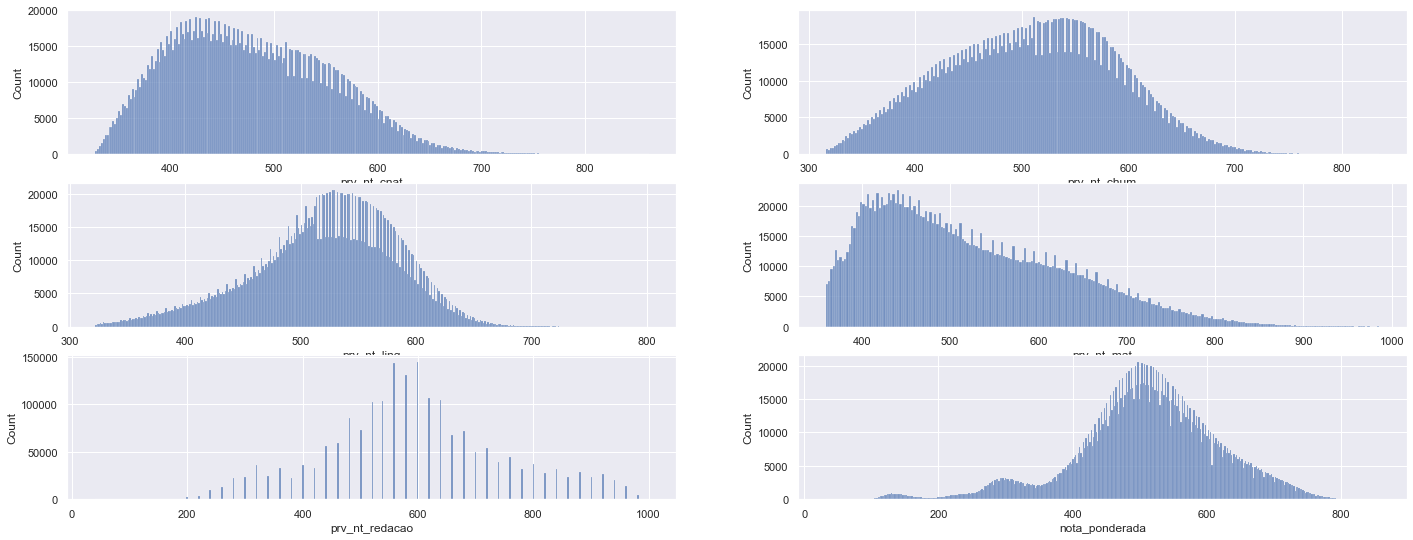

In [64]:
fig, axes = plt.subplots(3, 2)
aux = df4[df4['prv_nt_cnat']>0]
sns.histplot(ax=axes[0][0], data=aux, x='prv_nt_cnat');
aux = df4[df4['prv_nt_chum']>0]
sns.histplot(ax=axes[0][1], data=aux, x='prv_nt_chum');
aux = df4[df4['prv_nt_ling']>0]
sns.histplot(ax=axes[1][0], data=aux, x='prv_nt_ling');
aux = df4[df4['prv_nt_mat']>0]
sns.histplot(ax=axes[1][1], data=aux, x='prv_nt_mat');
aux = df4[df4['prv_nt_redacao']>0]
sns.histplot(ax=axes[2][0], data=aux, x='prv_nt_redacao');
aux = df4[df4['nota_ponderada']>0]
sns.histplot(ax=axes[2][1], data=aux, x='nota_ponderada');

### 4.1.2. NUMERICAL VARIABLE

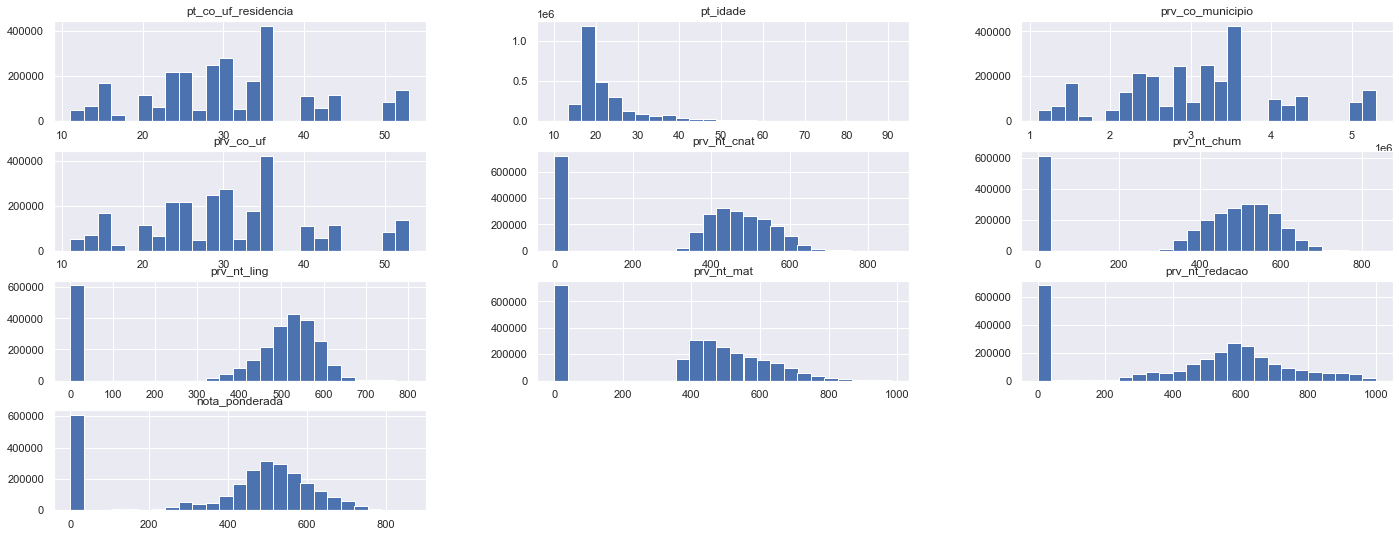

In [71]:
num_attributes.iloc[:, 1:].hist(bins=25);

### 4.1.3. CATEGORICAL VARIABLE

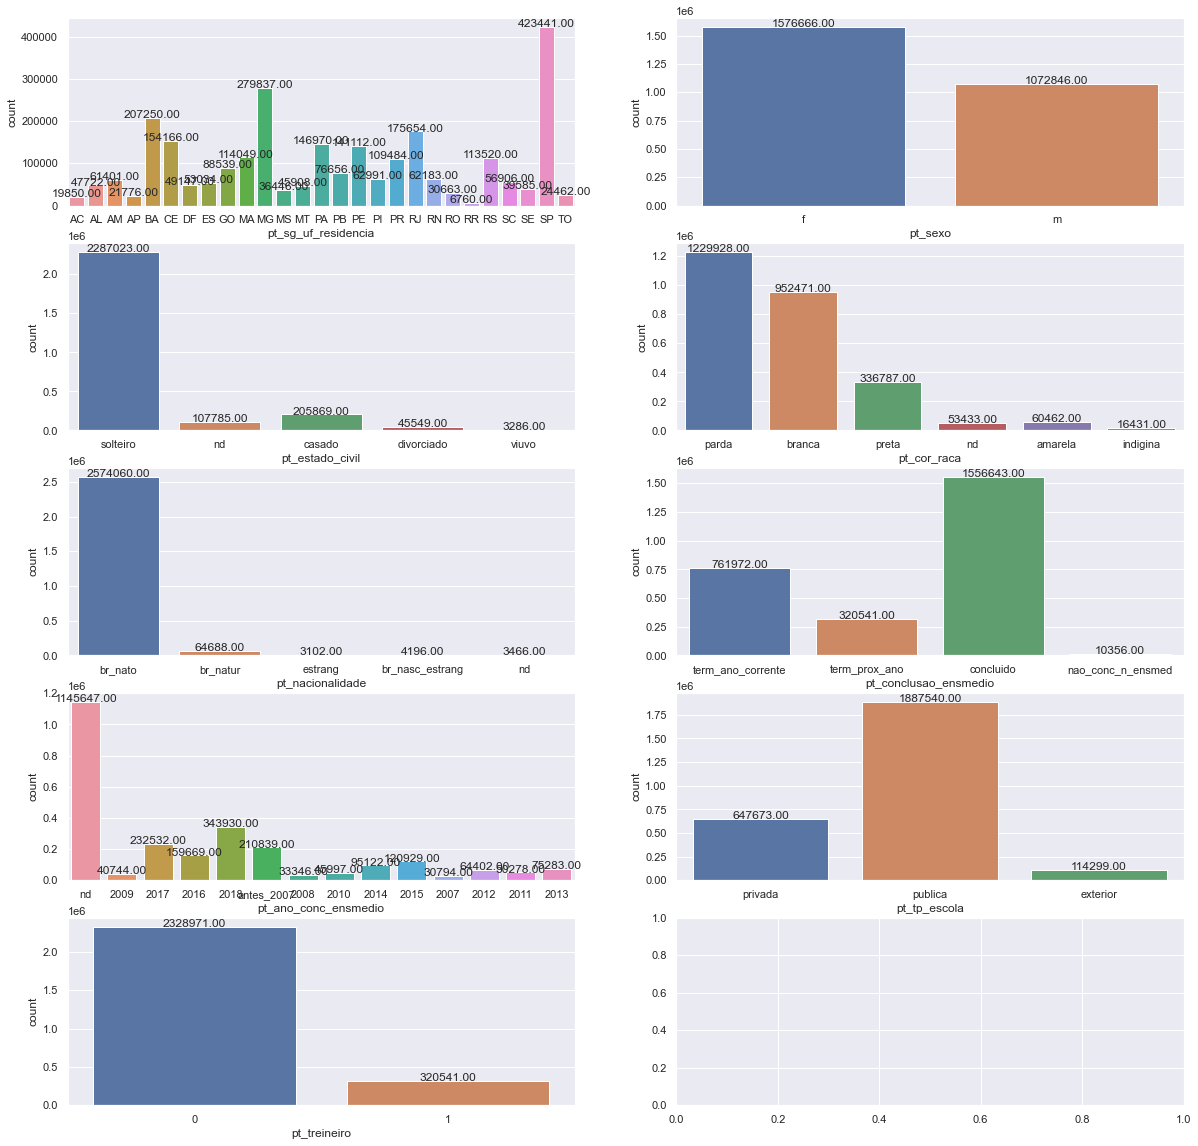

In [72]:
# DADOS GERAIS DO PARTICIPANTE
fig, axes = plt.subplots(5, 2, figsize=(20,20))
sns.countplot(ax=axes[0][0], x='pt_sg_uf_residencia', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='pt_sexo', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='pt_estado_civil', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='pt_cor_raca', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='pt_nacionalidade', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='pt_conclusao_ensmedio', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='pt_ano_conc_ensmedio', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='pt_tp_escola', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='pt_treineiro', data=cat_attributes)
show_values_on_bars(axes);

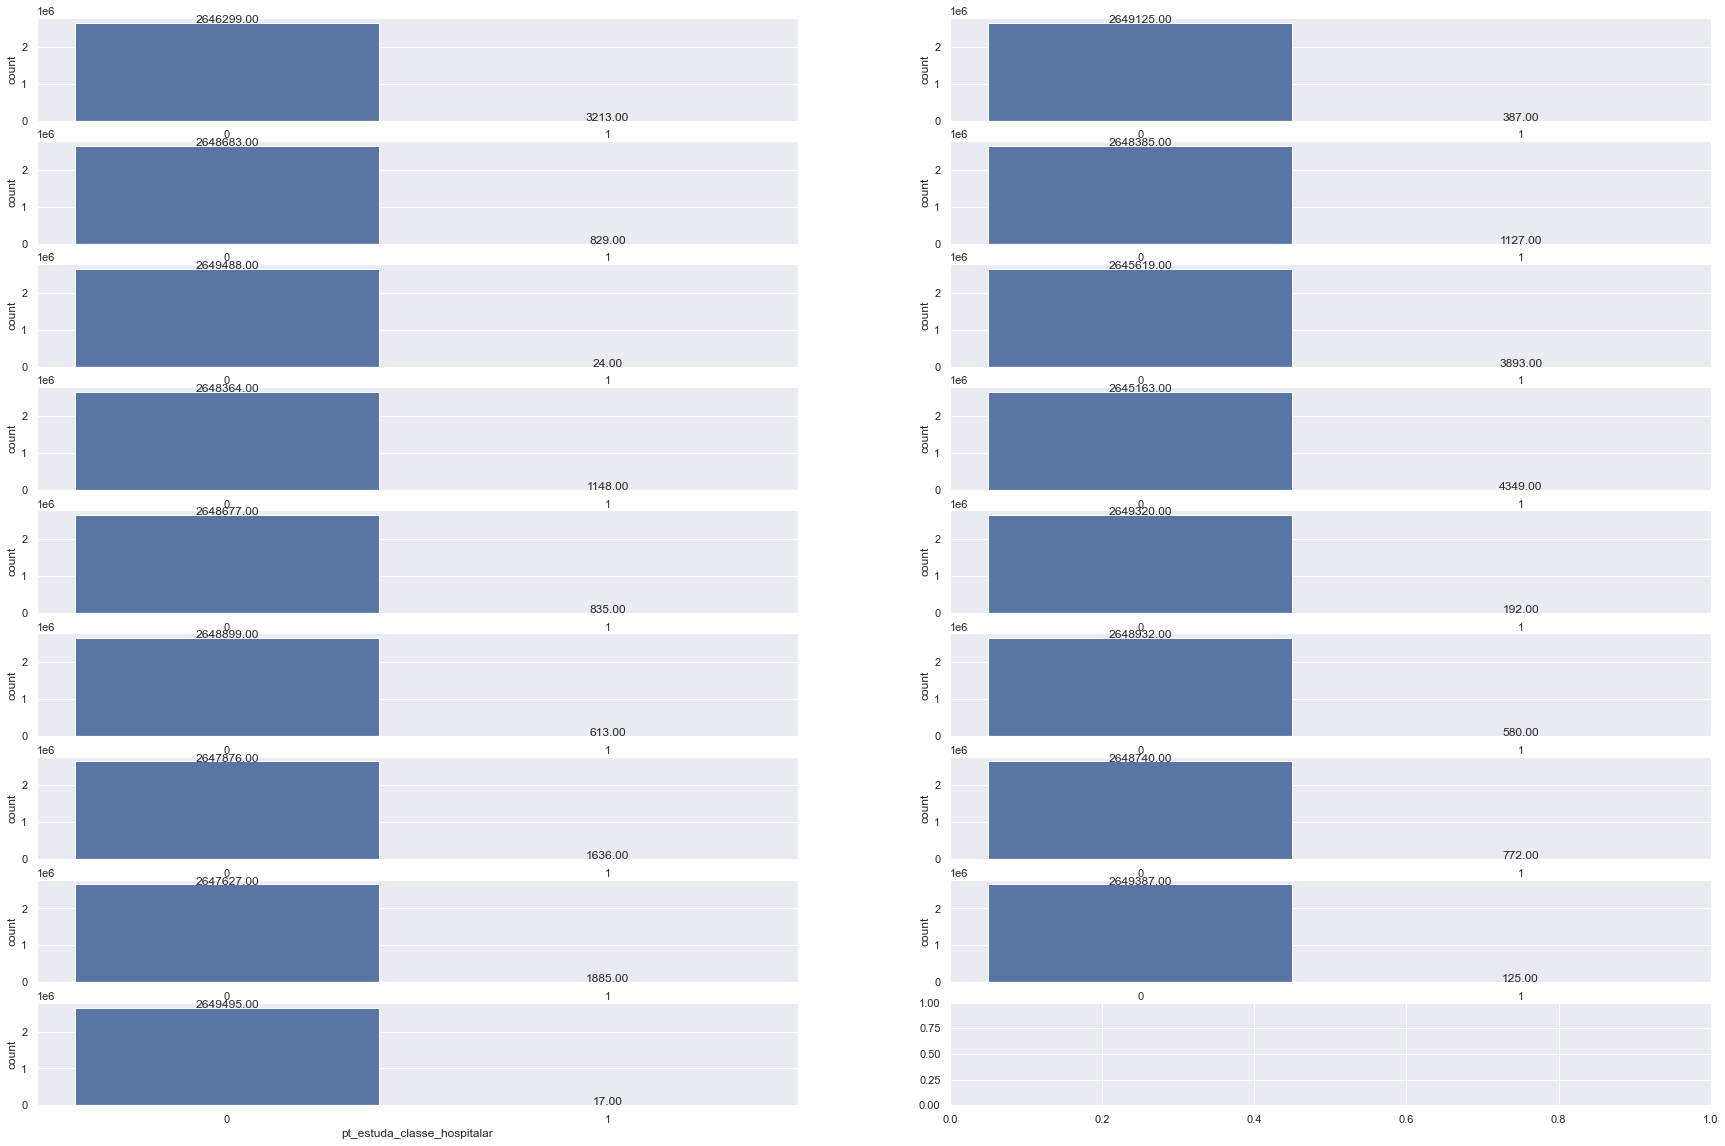

In [73]:
# DADOS ESPECIFICOS DO PARTICIPANTE
fig, axes = plt.subplots(9, 2, figsize=(30,20))
sns.countplot(ax=axes[0][0], x='pt_baixa_visao', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='pt_cegueira', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='pt_surdez', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='pt_deficiencia_auditiva', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='pt_surdo_cegueira', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='pt_deficiencia_fisica', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='pt_deficiencia_mental', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='pt_deficit_atencao', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='pt_dislexia', data=cat_attributes)
sns.countplot(ax=axes[4][1], x='pt_discalculia', data=cat_attributes)
sns.countplot(ax=axes[5][0], x='pt_autismo', data=cat_attributes)
sns.countplot(ax=axes[5][1], x='pt_visao_monocular', data=cat_attributes)
sns.countplot(ax=axes[6][0], x='pt_outra_def', data=cat_attributes)
sns.countplot(ax=axes[6][1], x='pt_gestante', data=cat_attributes)
sns.countplot(ax=axes[7][0], x='pt_lactante', data=cat_attributes)
sns.countplot(ax=axes[7][1], x='pt_idoso', data=cat_attributes)
sns.countplot(ax=axes[8][0], x='pt_estuda_classe_hospitalar', data=cat_attributes)
show_values_on_bars(axes);

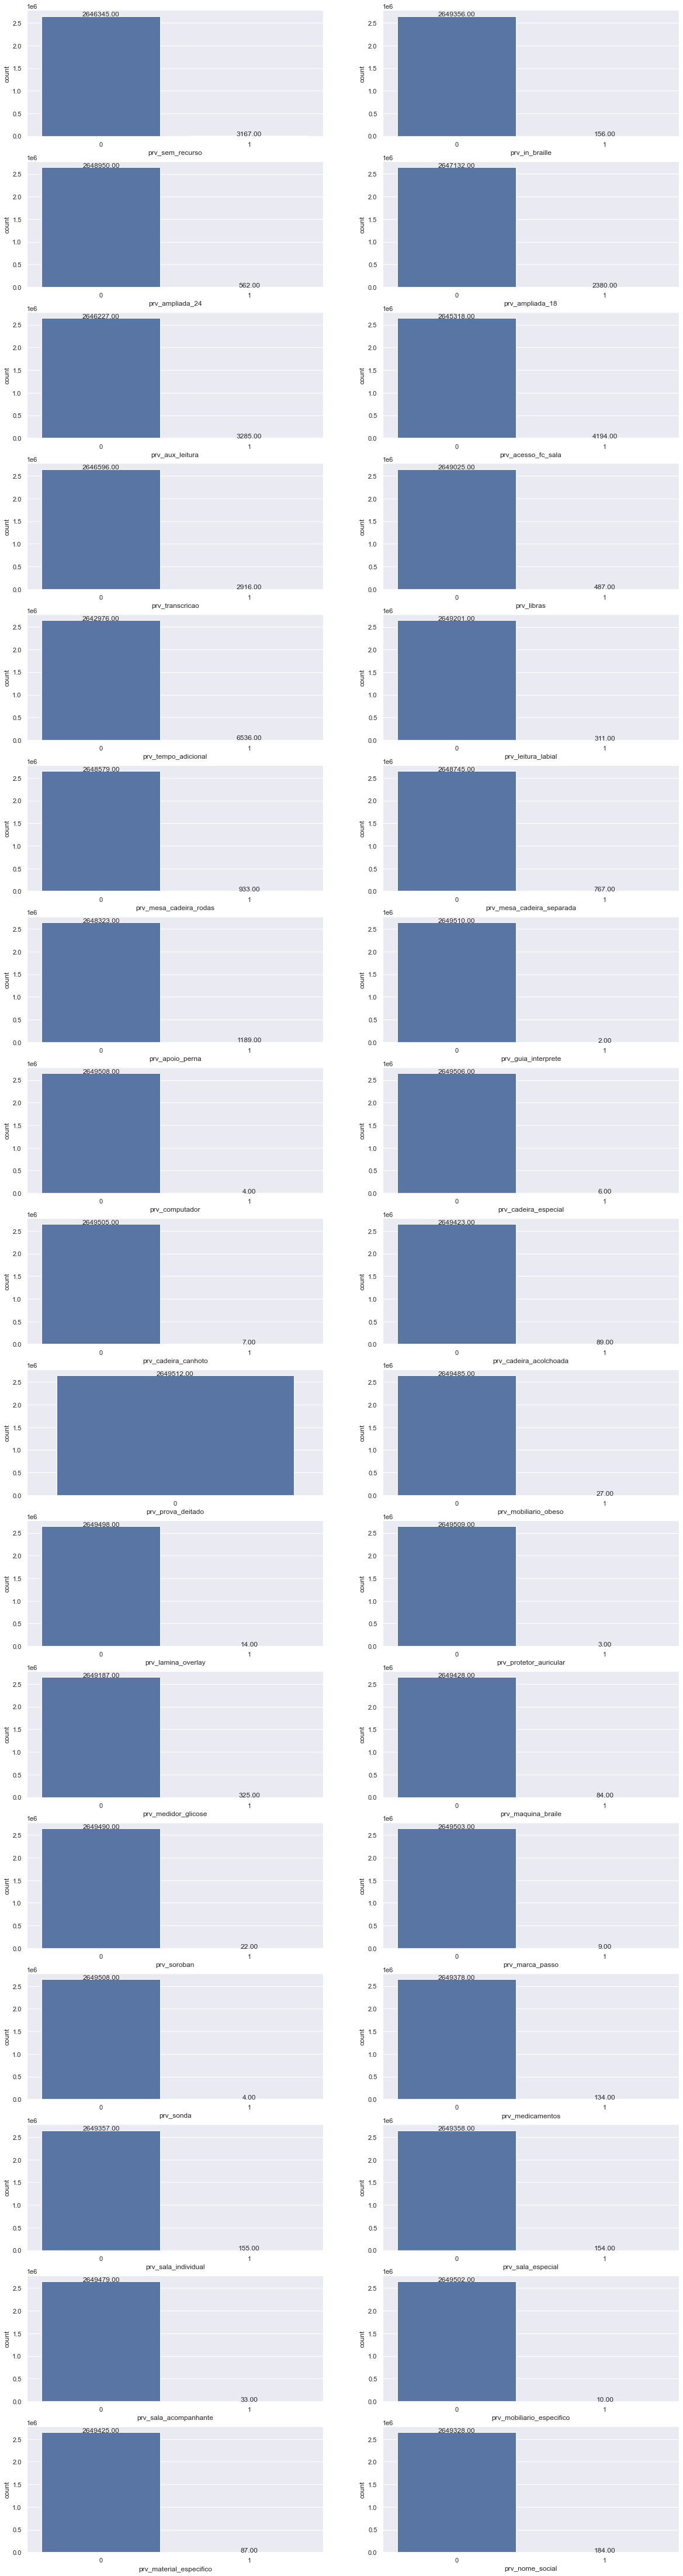

In [74]:
# DADOS ESPECIFICOS DO PARTICIPANTE
fig, axes = plt.subplots(17, 2, figsize=(20,80))
sns.countplot(ax=axes[0][0], x='prv_sem_recurso', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='prv_in_braille', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='prv_ampliada_24', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='prv_ampliada_18', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='prv_aux_leitura', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='prv_acesso_fc_sala', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='prv_transcricao', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='prv_libras', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='prv_tempo_adicional', data=cat_attributes)
sns.countplot(ax=axes[4][1], x='prv_leitura_labial', data=cat_attributes)
sns.countplot(ax=axes[5][0], x='prv_mesa_cadeira_rodas', data=cat_attributes)
sns.countplot(ax=axes[5][1], x='prv_mesa_cadeira_separada', data=cat_attributes)
sns.countplot(ax=axes[6][0], x='prv_apoio_perna', data=cat_attributes)
sns.countplot(ax=axes[6][1], x='prv_guia_interprete', data=cat_attributes)
sns.countplot(ax=axes[7][0], x='prv_computador', data=cat_attributes)
sns.countplot(ax=axes[7][1], x='prv_cadeira_especial', data=cat_attributes)
sns.countplot(ax=axes[8][0], x='prv_cadeira_canhoto', data=cat_attributes)
sns.countplot(ax=axes[8][1], x='prv_cadeira_acolchoada', data=cat_attributes)
sns.countplot(ax=axes[9][0], x='prv_prova_deitado', data=cat_attributes)
sns.countplot(ax=axes[9][1], x='prv_mobiliario_obeso', data=cat_attributes)
sns.countplot(ax=axes[10][0], x='prv_lamina_overlay', data=cat_attributes)
sns.countplot(ax=axes[10][1], x='prv_protetor_auricular', data=cat_attributes)
sns.countplot(ax=axes[11][0], x='prv_medidor_glicose', data=cat_attributes)
sns.countplot(ax=axes[11][1], x='prv_maquina_braile', data=cat_attributes)
sns.countplot(ax=axes[12][0], x='prv_soroban', data=cat_attributes)
sns.countplot(ax=axes[12][1], x='prv_marca_passo', data=cat_attributes)
sns.countplot(ax=axes[13][0], x='prv_sonda', data=cat_attributes)
sns.countplot(ax=axes[13][1], x='prv_medicamentos', data=cat_attributes)
sns.countplot(ax=axes[14][0], x='prv_sala_individual', data=cat_attributes)
sns.countplot(ax=axes[14][1], x='prv_sala_especial', data=cat_attributes)
sns.countplot(ax=axes[15][0], x='prv_sala_acompanhante', data=cat_attributes)
sns.countplot(ax=axes[15][1], x='prv_mobiliario_especifico', data=cat_attributes)
sns.countplot(ax=axes[16][0], x='prv_material_especifico', data=cat_attributes)
sns.countplot(ax=axes[16][1], x='prv_nome_social', data=cat_attributes)
show_values_on_bars(axes);

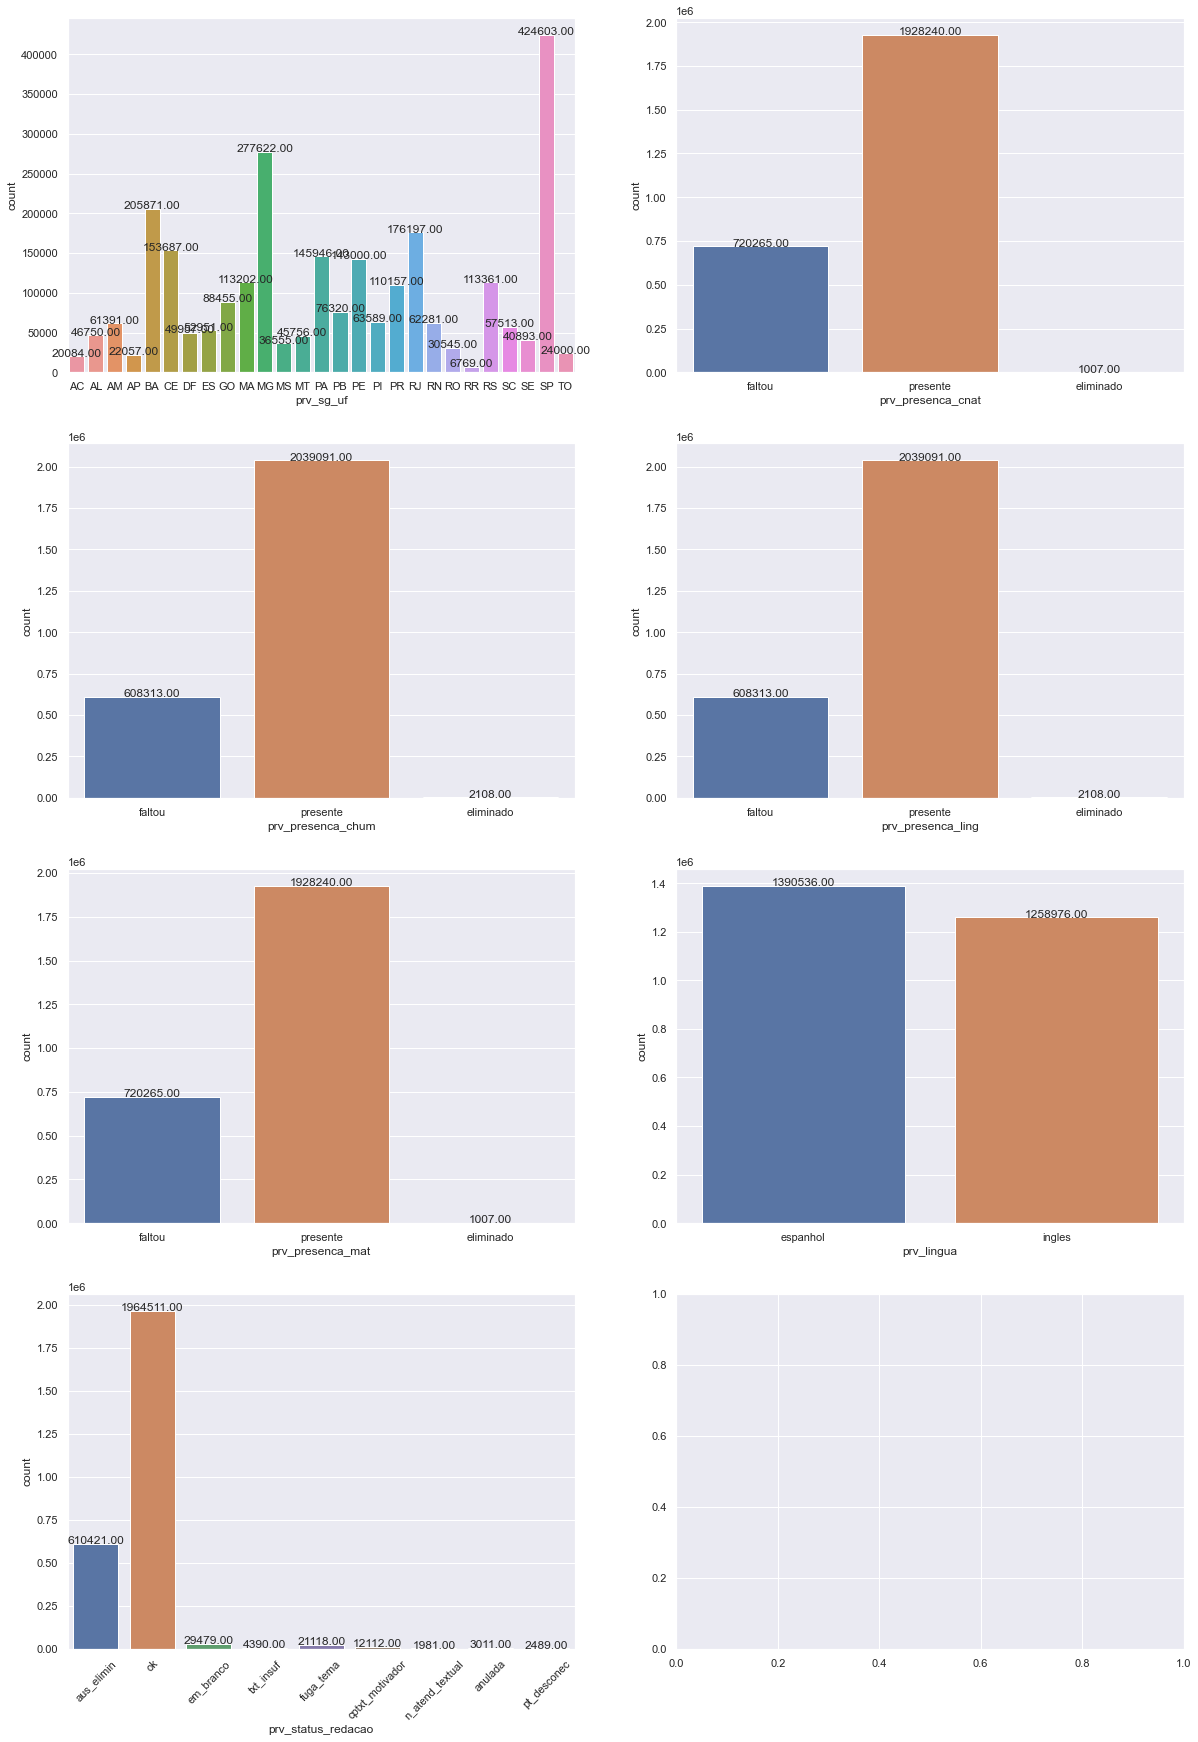

In [75]:
# DADOS DA PROVA
fig, axes = plt.subplots(4, 2, figsize=(20,30))
sns.countplot(ax=axes[0][0], x='prv_sg_uf', data=cat_attributes)
sns.countplot(ax=axes[0][1], x='prv_presenca_cnat', data=cat_attributes)
sns.countplot(ax=axes[1][0], x='prv_presenca_chum', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='prv_presenca_ling', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='prv_presenca_mat', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='prv_lingua', data=cat_attributes)
sns.countplot(ax=axes[3][0], x='prv_status_redacao', data=cat_attributes).tick_params(axis='x', labelrotation=45)
show_values_on_bars(axes);

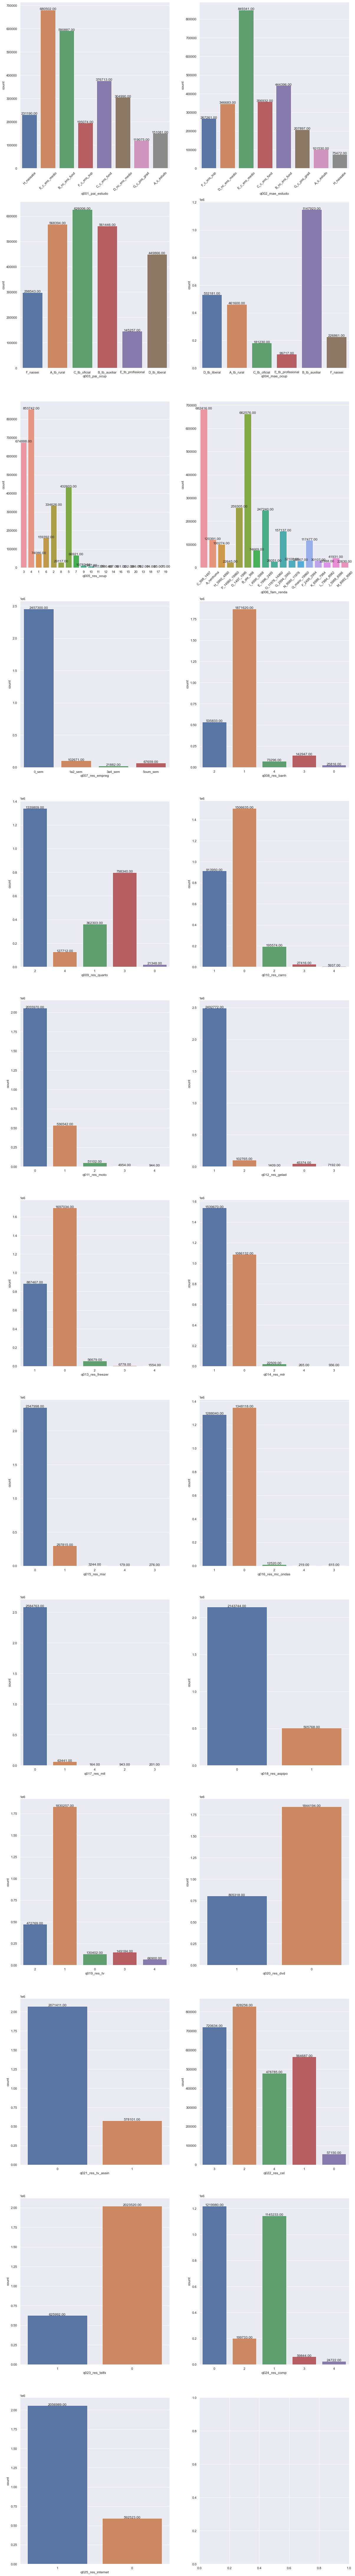

In [76]:
# DADOS QUESTIONARIO SOCIOECONOMICO
fig, axes = plt.subplots(13, 2, figsize=(20,160))
sns.countplot(ax=axes[0][0], x='q001_pai_estudo', data=cat_attributes).tick_params(axis='x', labelrotation=45)
sns.countplot(ax=axes[0][1], x='q002_mae_estudo', data=cat_attributes).tick_params(axis='x', labelrotation=45)
sns.countplot(ax=axes[1][0], x='q003_pai_ocup', data=cat_attributes)
sns.countplot(ax=axes[1][1], x='q004_mae_ocup', data=cat_attributes)
sns.countplot(ax=axes[2][0], x='q005_res_ocup', data=cat_attributes)
sns.countplot(ax=axes[2][1], x='q006_fam_renda', data=cat_attributes).tick_params(axis='x', labelrotation=45)
sns.countplot(ax=axes[3][0], x='q007_res_empreg', data=cat_attributes)
sns.countplot(ax=axes[3][1], x='q008_res_banh', data=cat_attributes)
sns.countplot(ax=axes[4][0], x='q009_res_quarto', data=cat_attributes)
sns.countplot(ax=axes[4][1], x='q010_res_carro', data=cat_attributes)
sns.countplot(ax=axes[5][0], x='q011_res_moto', data=cat_attributes)
sns.countplot(ax=axes[5][1], x='q012_res_gelad', data=cat_attributes)
sns.countplot(ax=axes[6][0], x='q013_res_freezer', data=cat_attributes)
sns.countplot(ax=axes[6][1], x='q014_res_mlr', data=cat_attributes)
sns.countplot(ax=axes[7][0], x='q015_res_msr', data=cat_attributes)
sns.countplot(ax=axes[7][1], x='q016_res_mc_ondas', data=cat_attributes)
sns.countplot(ax=axes[8][0], x='q017_res_mll', data=cat_attributes)
sns.countplot(ax=axes[8][1], x='q018_res_aspipo', data=cat_attributes)
sns.countplot(ax=axes[9][0], x='q019_res_tv', data=cat_attributes)
sns.countplot(ax=axes[9][1], x='q020_res_dvd', data=cat_attributes)
sns.countplot(ax=axes[10][0], x='q021_res_tv_assin', data=cat_attributes)
sns.countplot(ax=axes[10][1], x='q022_res_cel', data=cat_attributes)
sns.countplot(ax=axes[11][0], x='q023_res_telfx', data=cat_attributes)
sns.countplot(ax=axes[11][1], x='q024_res_comp', data=cat_attributes)
sns.countplot(ax=axes[12][0], x='q025_res_internet', data=cat_attributes)
show_values_on_bars(axes);

In [39]:
cat_attributes.head().T

,0,1,2,3,4
pt_nu_inscricao,a42faea7-8171-43c3-b868-35068e82f30d,d7b568f5-319c-4d49-b5af-385e5eadc703,8b04ed6a-c479-4bf3-8d88-9927c995f518,1ebc29c1-570e-40f4-a580-1d509e24bc91,1aec7054-9817-42d5-9268-063a4b80af3a
pt_no_municipio_residencia,manaus,ananindeua,são paulo,feira de santana,jaguaruana
pt_sg_uf_residencia,AM,PA,SP,BA,CE
pt_sexo,f,m,f,f,m
pt_estado_civil,casado,solteiro,nd,solteiro,solteiro
pt_cor_raca,parda,parda,branca,parda,parda
pt_nacionalidade,br_nato,br_nato,br_nato,br_nato,br_nato
pt_conclusao_ensmedio,concluido,concluido,concluido,concluido,concluido
pt_ano_conc_ensmedio,2017,2017,2011,2015,2018
pt_tp_escola,publica,publica,publica,publica,publica


## 4.2. ANÁLISE BIVARIADA

### 4.2.1 ESTADOS VS NOTAS
- Quantidade de participantes com melhor nota - SE melhor nota média / AM pior nota média

In [77]:
aux = df4[['pt_sg_uf_residencia', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
aux.groupby('pt_sg_uf_residencia').mean().sort_values('nota_ponderada', ascending=False)

,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada
pt_sg_uf_residencia,,,,,,
SE,358.25,395.00,406.25,388.00,467.00,407.00
MG,359.25,399.75,407.50,398.75,458.00,406.50
RN,360.50,398.00,409.25,392.75,458.25,406.50
PB,359.50,396.75,408.50,391.75,459.50,406.25
SC,357.50,406.75,413.50,397.75,449.75,405.25
RJ,355.50,400.50,410.25,390.00,457.50,405.00
SP,355.75,402.50,412.00,394.75,448.25,403.25
PI,357.50,390.75,403.25,388.50,455.50,402.50
CE,352.50,390.75,401.75,389.50,444.25,397.50


### 4.2.2 IDADE VS NOTAS
- A faixa com idade escolar tendencialmente tem a melhor médida de notas. Notas mais altas de idades mais novas e mais velhas são pontuais.

In [80]:
aux = df4[['pt_idade', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_idade').mean().reset_index()
nota['participantes'] = aux[['pt_idade', 'nota_ponderada']].groupby('pt_idade').count()['nota_ponderada'].tolist()
nota.sort_values('pt_idade', ascending=False)

,pt_idade,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
78,91.00,0.00,0.00,0.00,0.00,0.00,0.00,1
77,88.00,597.50,521.50,500.00,476.00,620.00,565.00,1
76,86.00,0.00,0.00,0.00,0.00,0.00,0.00,2
75,85.00,0.00,0.00,0.00,0.00,0.00,0.00,1
74,84.00,591.50,546.50,559.00,503.50,320.00,490.50,1
73,83.00,191.75,0.00,175.12,226.88,0.00,115.19,2
72,82.00,206.00,206.25,201.75,227.50,0.00,145.50,4
71,81.00,158.25,236.00,227.62,171.25,78.19,157.12,11
70,80.00,156.75,151.62,139.25,174.75,0.00,107.56,5
69,79.00,307.25,359.00,335.00,325.25,302.75,318.50,14


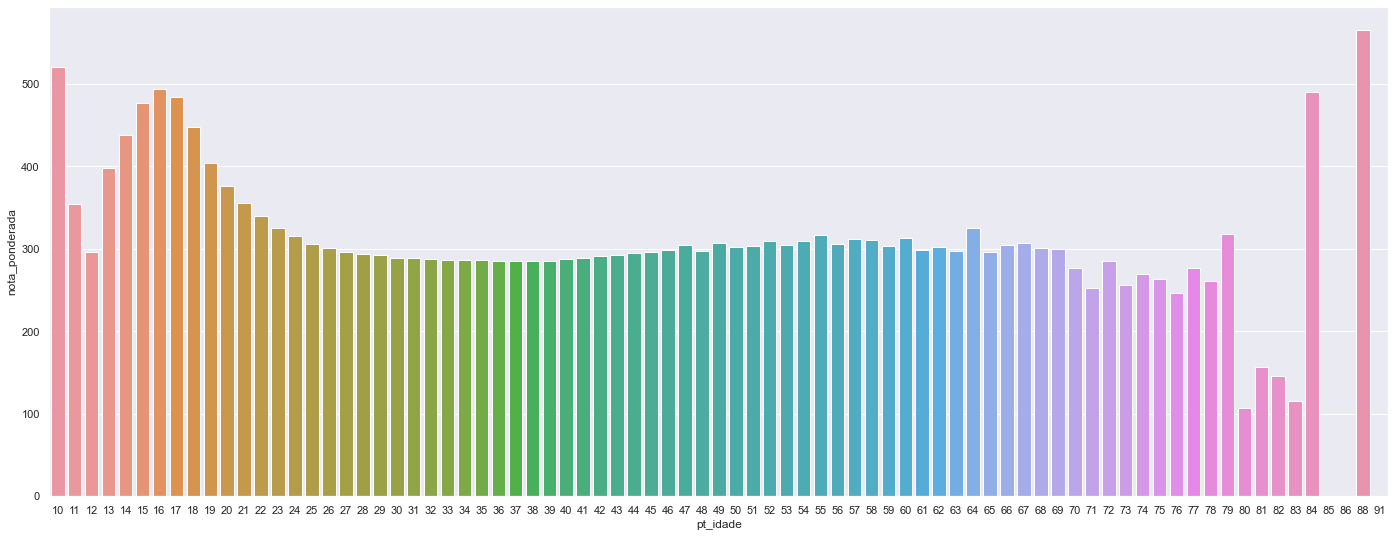

In [79]:
nota['pt_idade'] = nota['pt_idade'].astype('int')
sns.barplot(data=nota, x='pt_idade', y='nota_ponderada');

### 4.2.2 SEXO VS NOTAS
- Homens participam menos nas provas, porém tem um desempenho quase igual ao das meninas.

In [81]:
aux = df4[['pt_sexo', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_sexo').mean().reset_index()
nota['participantes'] = aux[['pt_sexo', 'nota_ponderada']].groupby('pt_sexo').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_sexo,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
1,m,356.25,395.50,400.50,399.00,432.00,396.00,1072846
0,f,342.00,386.75,400.50,368.25,444.75,391.50,1576666


### 4.2.3 ESTADO CIVIL VS NOTAS - <font color='red'>Variável não confiável</font>
- Solteiros performam melhor, sendo que casados tem pior desempenho.
- Existe um viés nos dados, onde a classificação não está feita corretamente. Há pessoas bem novas classificadas como viúvas. Essa feature não é confiável.

In [82]:
aux = df4[['pt_estado_civil', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_estado_civil').mean().reset_index()
nota['participantes'] = aux[['pt_estado_civil', 'nota_ponderada']].groupby('pt_estado_civil').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_estado_civil,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
3,solteiro,359.00,401.75,412.50,394.50,457.25,407.00,2287023
2,nd,300.50,344.00,351.75,323.50,367.25,337.50,107785
1,divorciado,276.50,320.00,326.50,292.25,325.50,307.25,45549
0,casado,263.75,304.25,310.25,278.75,309.50,292.25,205869
4,viuvo,270.75,313.50,319.00,278.25,292.50,292.00,3286


In [84]:
df4[(df4['pt_estado_civil'] == 'viuvo') & (df4['pt_idade'] < 40)].sample(100)

,pt_nu_inscricao,pt_co_municipio_residencia,pt_no_municipio_residencia,pt_co_uf_residencia,pt_sg_uf_residencia,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_co_municipio,prv_no_municipio,prv_co_uf,prv_sg_uf,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_lingua,prv_status_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada
1531875,28f4219e-5999-4db1-a427-7fe2083a3c63,3157807,santa luzia,31,MG,22.00,f,viuvo,parda,br_nato,concluido,2016,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3157807,Santa Luzia,31,MG,presente,presente,presente,presente,espanhol,ok,E_c_ens_medio,C_c_ens_fund,F_naosei,C_tb_oficial,5,E_1996_2495,0_sem,2,3,1,1,1,1,1,0,1,0,0,1,0,0,3,0,0,1,358.50,501.00,524.50,413.25,580.00,478.00
647850,d9c3c392-e942-4d55-bdac-96c1233c3e35,2313401,tianguá,23,CE,33.00,f,viuvo,parda,br_nato,concluido,antes_2007,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2313401,Tianguá,23,CE,presente,presente,presente,presente,espanhol,ok,B_nc_ens_fund,E_c_ens_medio,A_tb_rural,A_tb_rural,2,E_1996_2495,0_sem,1,2,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,427.00,404.25,502.50,430.00,460.00,450.00
324171,880e0c3b-d4f1-4b56-96e8-c1314a4fbdc7,3504404,avanhandava,35,SP,18.00,m,viuvo,branca,br_nato,term_ano_corrente,nd,privada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3541604,Promissão,35,SP,presente,presente,presente,presente,espanhol,ok,C_c_ens_fund,C_c_ens_fund,C_tb_oficial,B_tb_auxiliar,2,B_ate_998,0_sem,1,2,0,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,501.50,547.00,537.00,386.00,540.00,513.00
2589392,bc1fd1c8-0fcd-410f-a0d7-b4c76cd977a3,2111300,são luís,21,MA,23.00,m,viuvo,preta,br_nato,concluido,2014,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2111300,São Luís,21,MA,faltou,faltou,faltou,faltou,espanhol,aus_elimin,B_nc_ens_fund,A_s_estudo,A_tb_rural,A_tb_rural,7,C_998_1497,0_sem,1,3,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
1708478,0806c22c-f718-49af-8e64-30f0daf0edfa,3518800,guarulhos,35,SP,29.00,m,viuvo,branca,br_nato,concluido,2009,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3518800,Guarulhos,35,SP,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,E_c_ens_medio,B_tb_auxiliar,B_tb_auxiliar,2,C_998_1497,0_sem,1,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,1,1,521.50,569.00,543.00,541.50,480.00,520.00
1258830,7e8e4d0e-d5a3-4c58-823e-1

### 4.2.4 COR/RAÇA VS NOTAS - <font color='orange'>Variável possui viés, tendo em vista que quem declara é o participante</font>
- Declarantes de branco possuem a melhor nota.
- Declarantes de indígenas perfomam pior.
- Interessante observar que as notas de pardos e negros são parecidos.

In [85]:
aux = df4[['pt_cor_raca', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_cor_raca').mean().reset_index()
nota['participantes'] = aux[['pt_cor_raca', 'nota_ponderada']].groupby('pt_cor_raca').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_cor_raca,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
1,branca,375.25,418.75,426.25,418.00,480.75,425.75,952471
0,amarela,349.75,389.00,401.75,385.25,440.50,394.75,60462
3,nd,347.50,390.50,397.75,380.50,429.75,389.75,53433
4,parda,333.75,375.50,387.50,362.00,419.00,377.00,1229928
5,preta,323.00,366.75,379.00,345.75,404.00,365.00,336787
2,indigina,303.75,344.50,357.00,325.25,360.25,337.50,16431


### 4.2.5 NACIONALIDADE VS NOTAS
- Aparentemente quem nasce no estrangeiro performa melhor nas provas. Entretanto, a amostra é menor comparado aos brasileiros nascido aqui de fato.

In [86]:
aux = df4[['pt_nacionalidade', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_nacionalidade').mean().reset_index()
nota['participantes'] = aux[['pt_nacionalidade', 'nota_ponderada']].groupby('pt_nacionalidade').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_nacionalidade,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
0,br_nasc_estrang,403.25,442.50,450.50,456.75,504.00,452.25,4196
1,br_nato,348.25,390.75,401.00,381.25,440.25,394.00,2574060
4,nd,336.75,381.00,395.50,362.50,418.25,380.00,3466
3,estrang,341.25,378.75,387.25,381.75,396.75,375.00,3102
2,br_natur,327.25,368.25,384.75,350.25,406.75,369.00,64688


### 4.2.6 STATUS ENS MEDIO VS NOTAS
- Pessoal que presta a prova para "treinar" em média tem performance melhor.
- Quem está para concluir o ens. medio tem média melhor comparados aqueles que já concluiram.

In [87]:
aux = df4[['pt_conclusao_ensmedio', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_conclusao_ensmedio').mean().reset_index()
nota['participantes'] = aux[['pt_conclusao_ensmedio', 'nota_ponderada']].groupby('pt_conclusao_ensmedio').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_conclusao_ensmedio,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
3,term_prox_ano,416.00,466.75,479.75,463.25,521.50,470.25,320541
2,term_ano_corrente,394.25,438.50,450.50,435.50,500.25,446.00,761972
0,concluido,311.50,351.75,360.50,337.50,394.00,352.75,1556643
1,nao_conc_n_ensmed,242.25,296.25,307.25,265.50,292.00,278.00,10356


In [88]:
aux = df4[['pt_treineiro', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_treineiro').mean().reset_index()
nota['participantes'] = aux[['pt_treineiro', 'nota_ponderada']].groupby('pt_treineiro').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_treineiro,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
1,1,416.00,466.75,479.75,463.25,521.50,470.25,320541
0,0,338.25,379.75,389.75,369.25,428.25,382.75,2328971


### 4.2.7 ANO CONCLUSAO ENS MEDIO VS NOTAS
- Pessoas que não declaram o ano tem a melhor nota média.
- Aparentemente em média há uma gradual melhora na nota média. Duas hipóteses: pessoal está estudando mais, ou a prova já está ficando "manjada".

In [89]:
aux = df4[['pt_ano_conc_ensmedio', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_ano_conc_ensmedio').mean().reset_index()
nota['participantes'] = aux[['pt_ano_conc_ensmedio', 'nota_ponderada']].groupby('pt_ano_conc_ensmedio').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_ano_conc_ensmedio,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
13,nd,394.25,440.50,452.75,435.75,496.75,445.50,1145647
11,2018,354.25,393.75,405.50,388.00,463.25,404.50,343930
10,2017,334.25,373.50,385.00,365.75,436.75,382.25,232532
9,2016,323.50,363.00,373.50,353.75,419.25,369.25,159669
8,2015,307.75,347.25,357.25,335.25,394.00,350.25,120929
7,2014,299.25,338.75,348.75,324.75,379.50,339.75,95122
6,2013,289.00,328.50,337.50,313.25,362.75,327.25,75283
5,2012,281.75,320.50,328.75,304.25,348.75,317.25,64402
4,2011,276.75,316.00,323.75,298.75,342.00,311.75,50278
12,antes_2007,276.75,318.75,319.50,290.50,321.50,304.25,210839


### 4.2.8 TIPO DE ESCOLA VS NOTAS
- Aperentemente esta feature concorda com a nota das pessoas que declaram que são estrangeiras. Escolas estrangeiras possuem melhor nota.
- Pior performance são as escolas públicas.

In [90]:
aux = df4[['pt_tp_escola', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
nota = aux.groupby('pt_tp_escola').mean().reset_index()
nota['participantes'] = aux[['pt_tp_escola', 'nota_ponderada']].groupby('pt_tp_escola').count()['nota_ponderada'].tolist()
nota.sort_values('nota_ponderada', ascending=False)

,pt_tp_escola,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes
0,exterior,513.00,547.00,545.00,588.00,695.50,585.00,114299
1,privada,373.25,419.50,433.75,408.75,466.00,421.25,647673
2,publica,329.00,371.00,380.50,358.50,415.00,372.25,1887540


### 4.2.9 ATENDIMENTO ESPECIALIZADO VS NOTAS
- No geral pessoas que indicam deficiência tem performance ruim comparado aqueles que não o declaram.
- Entretanto, deve-se destcar o otimo desempenho daqueles que declararam deficit de atencao, dislexia e discalculia. Aqueles que marcam "outras deficiências" também tem um relativo melhor desepenho.

In [91]:
atend_espec = df4.iloc[:, 14:31].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

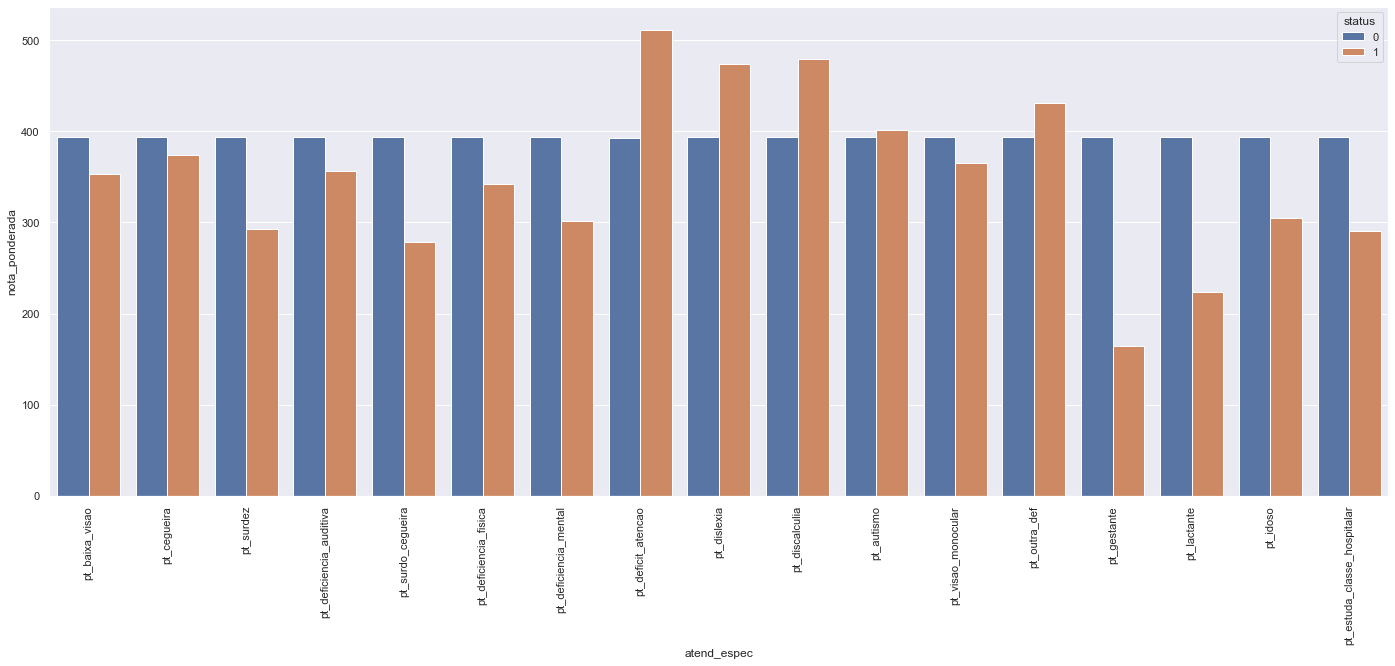

In [92]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [93]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,0,347.75,390.50,400.50,380.75,439.75,393.50,2646299,pt_baixa_visao
1,1,319.00,361.50,366.75,337.00,379.75,352.75,3213,pt_baixa_visao
0,0,347.75,390.25,400.50,380.75,439.50,393.50,2649125,pt_cegueira
1,1,331.75,385.25,390.00,345.25,410.50,373.75,387,pt_cegueira
0,0,347.75,390.25,400.50,380.75,439.75,393.50,2648683,pt_surdez
1,1,303.25,329.50,321.50,319.75,243.00,293.00,829,pt_surdez
0,0,347.75,390.25,400.50,380.75,439.50,393.50,2648385,pt_deficiencia_auditiva
1,1,331.00,361.50,359.00,353.00,380.25,356.75,1127,pt_deficiencia_auditiva
0,0,347.75,390.25,400.50,380.75,439.50,393.50,2649488,pt_surdo_cegueira
1,1,266.00,305.00,303.75,289.50,261.75,278.50,24,pt_surdo_cegueira


### 4.2.9 ATENDIMENTO ESPECIALIZADO VS NOTAS
- No geral pessoas que solicitam algum tipo de atendimento especial não superam a nota média.
- Porém temos algumas observações notáveis:
 * prv_tempo_adicional
 * prv_leitura_labial
 * prv_cadeira_cachoto
 * prv_cadeira_acolchoada
 * prv_lamida_overlay
 * prv_medidor_glicose
 * prv_maquina_braile
 * prv_marca_passo
 * prv_medicamentos
 * prv_sala_individual
 * prv_sala_especial
 * prv_sala_acompanhante
 * prv_material_especifico
 * prv_nome_social

In [94]:
atend_espec = df4.iloc[:, 31:65].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

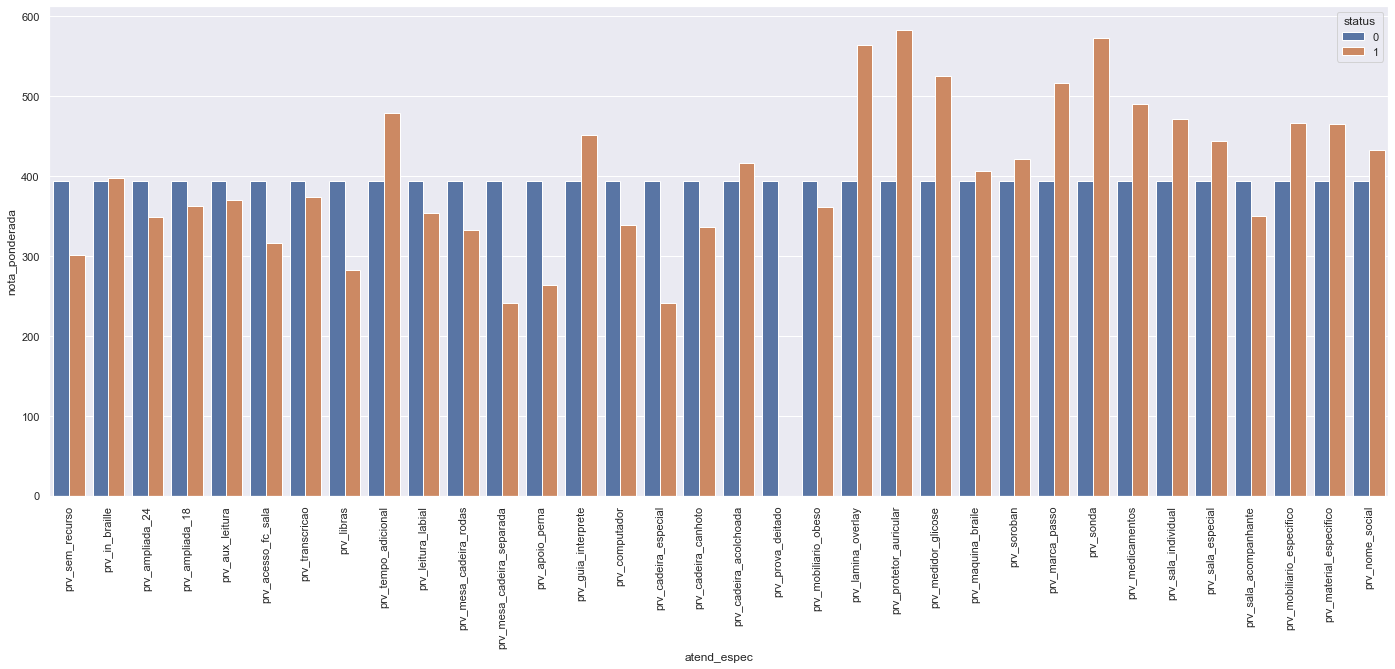

In [95]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [97]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,0,347.75,390.50,400.75,380.75,439.75,393.50,2646345,prv_sem_recurso
1,1,269.00,306.25,315.00,288.50,324.75,300.75,3167,prv_sem_recurso
0,0,347.75,390.25,400.50,380.75,439.50,393.50,2649356,prv_in_braille
1,1,341.75,409.00,411.00,356.75,454.00,397.50,156,prv_in_braille
0,0,347.75,390.25,400.50,380.75,439.50,393.50,2648950,prv_ampliada_24
1,1,317.00,361.25,364.50,332.00,370.50,348.50,562,prv_ampliada_24
0,0,347.75,390.25,400.50,380.75,439.50,393.50,2647132,prv_ampliada_18
1,1,327.00,369.75,374.50,346.75,392.75,362.50,2380,prv_ampliada_18
0,0,347.75,390.25,400.50,380.75,439.75,393.50,2646227,prv_aux_leitura
1,1,346.50,380.50,383.75,366.25,382.50,370.00,3285,prv_aux_leitura


### 4.2.10 PROVA ESTADO VS NOTAS
- O ranking do local de origem dos candidatos e onde fazem as provas é bem parecido, trocando algumas posição.
- Provável que esta variável seja correlacionada com a outra (verificar)

In [98]:
aux = df4[['prv_sg_uf', 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
aux.groupby('prv_sg_uf').mean().sort_values('nota_ponderada', ascending=False)

,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada
prv_sg_uf,,,,,,
RN,360.75,398.25,409.50,392.75,458.25,406.75
MG,359.25,399.75,407.75,399.00,458.25,406.75
SE,358.00,394.50,405.50,387.50,466.00,406.50
PB,359.75,397.25,408.75,392.00,459.75,406.50
RJ,355.50,400.50,410.25,390.00,457.25,405.00
SC,356.75,406.00,412.75,397.00,449.00,404.50
SP,355.75,402.50,411.75,394.75,448.25,403.25
PI,357.50,390.75,403.25,388.50,455.75,402.50
CE,352.75,391.00,402.00,389.75,444.50,397.75


### 4.2.11 PRESENÇA PROVA VS NOTAS
- Notas médias por dia de aplicação: aparentemente o pessoal vai melhor no segundo dia.
- Quem opta fazer a prova de inglês tem nota melhor. Interessante notar que a maioria opta em fazer a prova em espanhol...


In [99]:
atend_espec = df4.iloc[:, 69:74].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

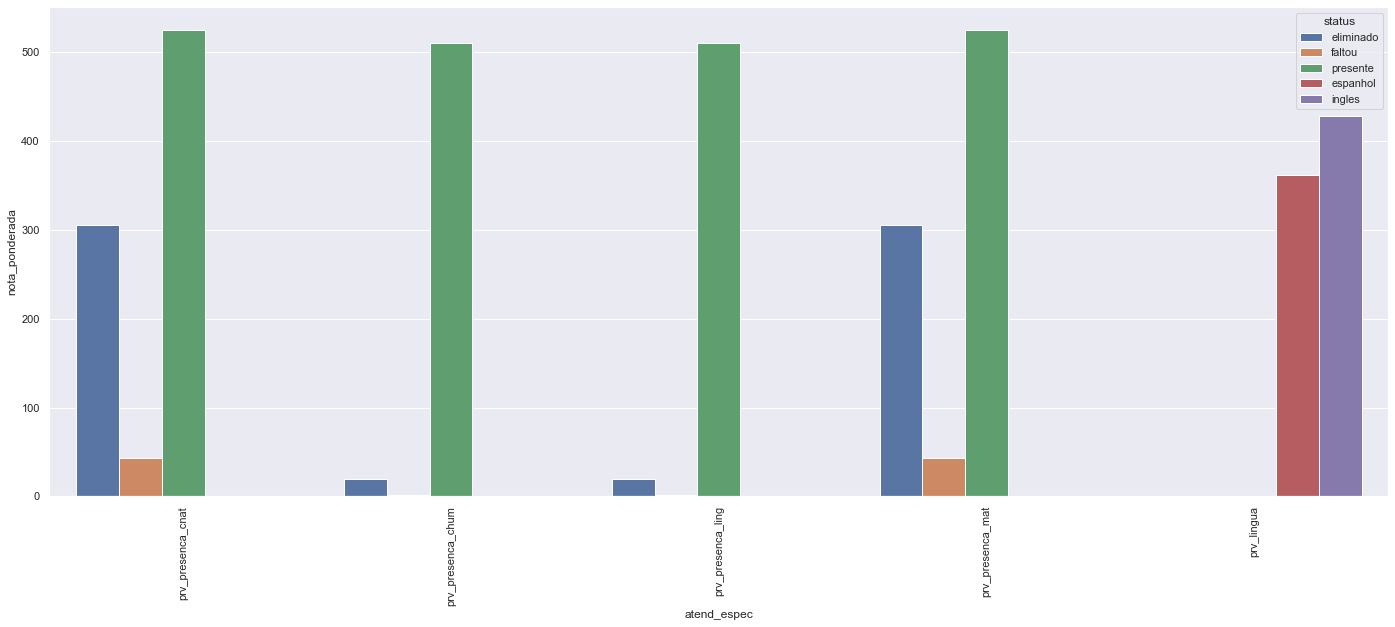

In [100]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [102]:
nota_.sort_values('status')

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,eliminado,0.00,487.75,503.50,0.00,520.50,305.75,1007,prv_presenca_cnat
0,eliminado,48.31,0.00,0.00,52.59,0.00,19.75,2108,prv_presenca_chum
0,eliminado,48.31,0.00,0.00,52.59,0.00,19.75,2108,prv_presenca_ling
0,eliminado,0.00,487.75,503.50,0.00,520.50,305.75,1007,prv_presenca_mat
0,espanhol,320.25,362.00,374.25,345.25,400.25,361.75,1390536,prv_lingua
1,faltou,0.00,73.38,77.50,0.00,67.75,43.16,720265,prv_presenca_cnat
1,faltou,3.04,0.00,0.00,3.33,0.00,1.24,608313,prv_presenca_chum
1,faltou,3.04,0.00,0.00,3.33,0.00,1.24,608313,prv_presenca_ling
1,faltou,0.00,73.38,77.50,0.00,67.75,43.16,720265,prv_presenca_mat
1,ingles,378.00,421.75,429.50,420.00,483.00,428.50,1258976,prv_lingua


### 4.2.12 STATUS REDAÇÂO VS NOTAS
- 74% dos candidatos reprovam na prova de redação com alguma inedequação na composição do texto.
- A má execução da redação praticamente derruba a nota do candidato pela metade.


In [103]:
atend_espec = df4.iloc[:, 74:75].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

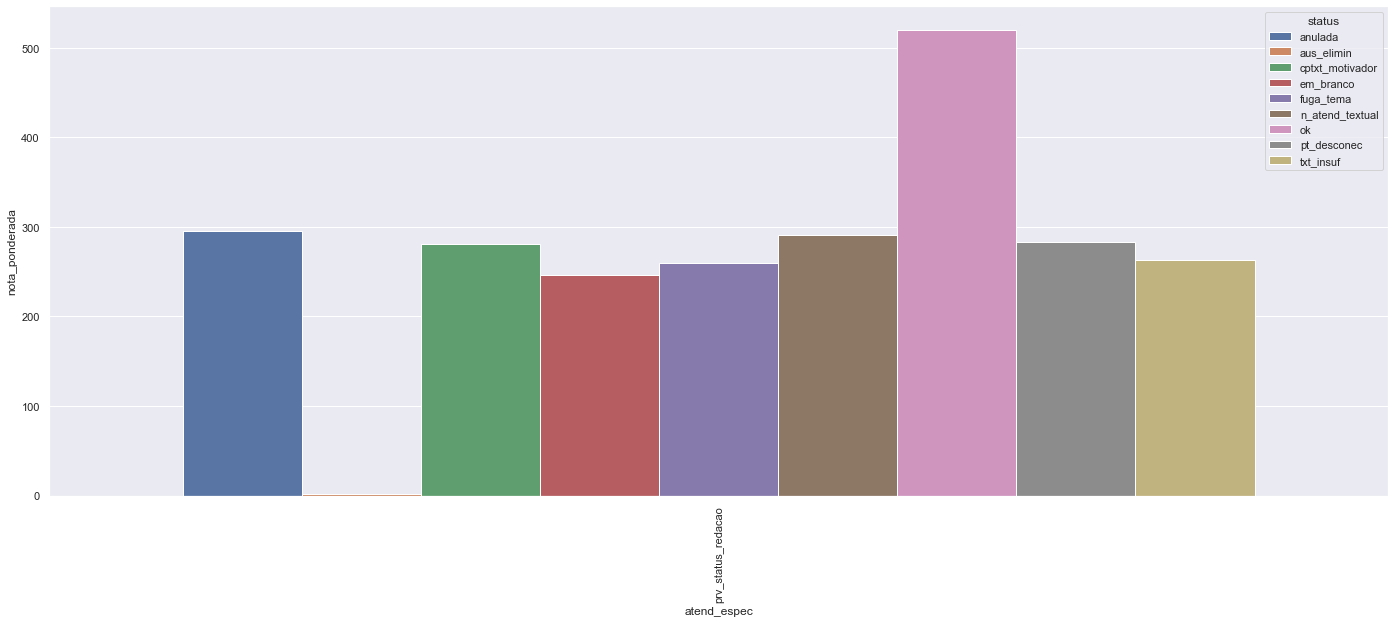

In [104]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [105]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,anulada,381.75,460.25,476.75,401.50,0.00,296.00,3011,prv_status_redacao
1,aus_elimin,3.19,0.00,0.00,3.50,0.00,1.31,610421,prv_status_redacao
2,cptxt_motivador,369.25,423.75,442.50,397.00,0.00,281.25,12112,prv_status_redacao
3,em_branco,270.00,434.00,464.50,289.25,0.00,246.25,29479,prv_status_redacao
4,fuga_tema,320.25,424.00,439.00,337.00,0.00,260.00,21118,prv_status_redacao
5,n_atend_textual,383.25,444.75,458.75,401.00,0.00,291.25,1981,prv_status_redacao
6,ok,456.00,510.00,523.00,499.75,593.00,520.50,1964511,prv_status_redacao
7,pt_desconec,360.75,444.50,464.25,379.25,0.00,283.50,2489,prv_status_redacao
8,txt_insuf,311.50,439.75,465.25,329.50,0.00,263.50,4390,prv_status_redacao


### 4.2.13 QUESTIONARIO SOCIAL VS NOTAS - Q001 / Q002 - Escolaridade dos pais
- No geral, o tempo de estudo do pai pesa mais doq a mãe no valor da nota.

In [106]:
atend_espec = df4.iloc[:, 75:77].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

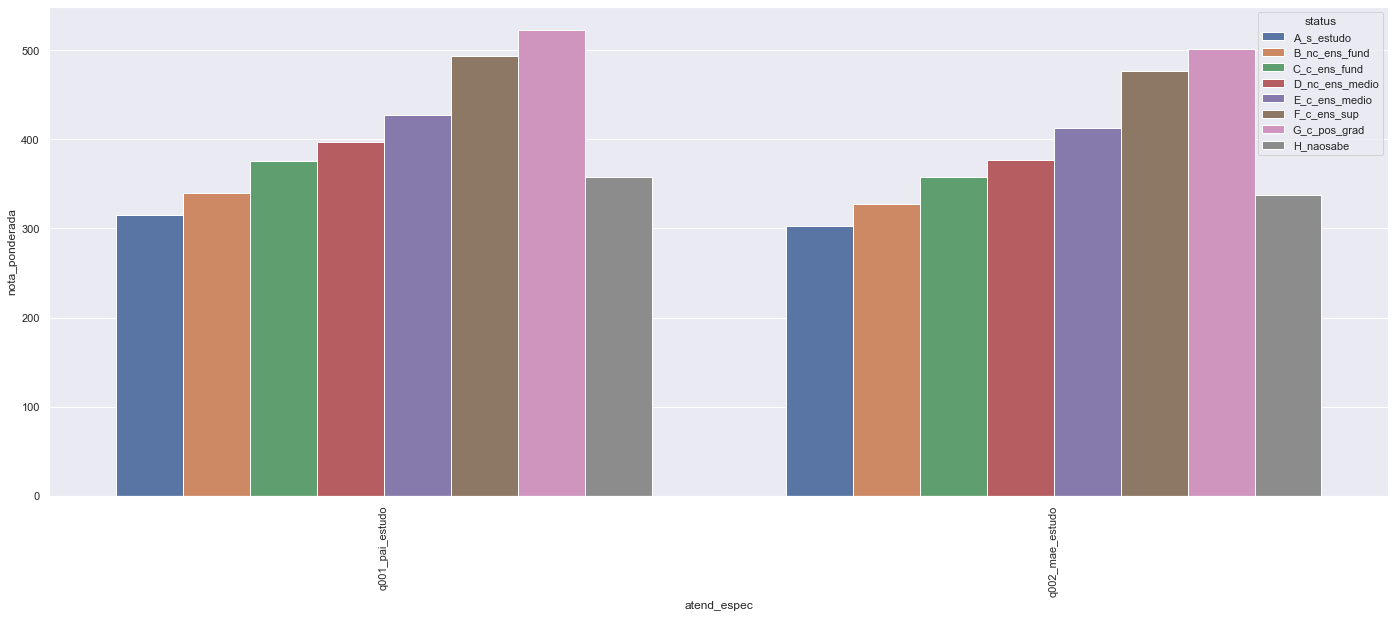

In [107]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [108]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,A_s_estudo,284.00,324.00,334.50,299.25,335.25,315.00,151081,q001_pai_estudo
1,B_nc_ens_fund,301.50,343.25,355.00,323.00,371.75,339.75,590887,q001_pai_estudo
2,C_c_ens_fund,332.00,375.50,387.75,360.50,416.75,375.75,376713,q001_pai_estudo
3,D_nc_ens_medio,349.25,393.25,405.75,381.75,443.75,396.50,304990,q001_pai_estudo
4,E_c_ens_medio,375.75,419.25,429.50,414.75,482.75,426.75,680502,q001_pai_estudo
5,F_c_ens_sup,434.50,474.75,476.50,493.00,569.00,493.00,195074,q001_pai_estudo
6,G_c_pos_grad,459.75,499.50,497.50,528.00,608.00,522.50,119075,q001_pai_estudo
7,H_naosabe,317.50,362.25,375.25,342.00,389.75,357.75,231190,q001_pai_estudo
0,A_s_estudo,274.50,315.00,324.25,286.50,317.50,302.75,101530,q002_mae_estudo
1,B_nc_ens_fund,292.00,333.75,344.75,310.50,356.00,327.75,444396,q002_mae_estudo


### 4.2.14 QUESTIONARIO SOCIAL VS NOTAS - Q003 / Q004 - Ocupação dos pais
- A nota média tanto para o pai e quanto para mãe são parecidas. Não há diferença discrepante.

In [109]:
atend_espec = df4.iloc[:, 77:79].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

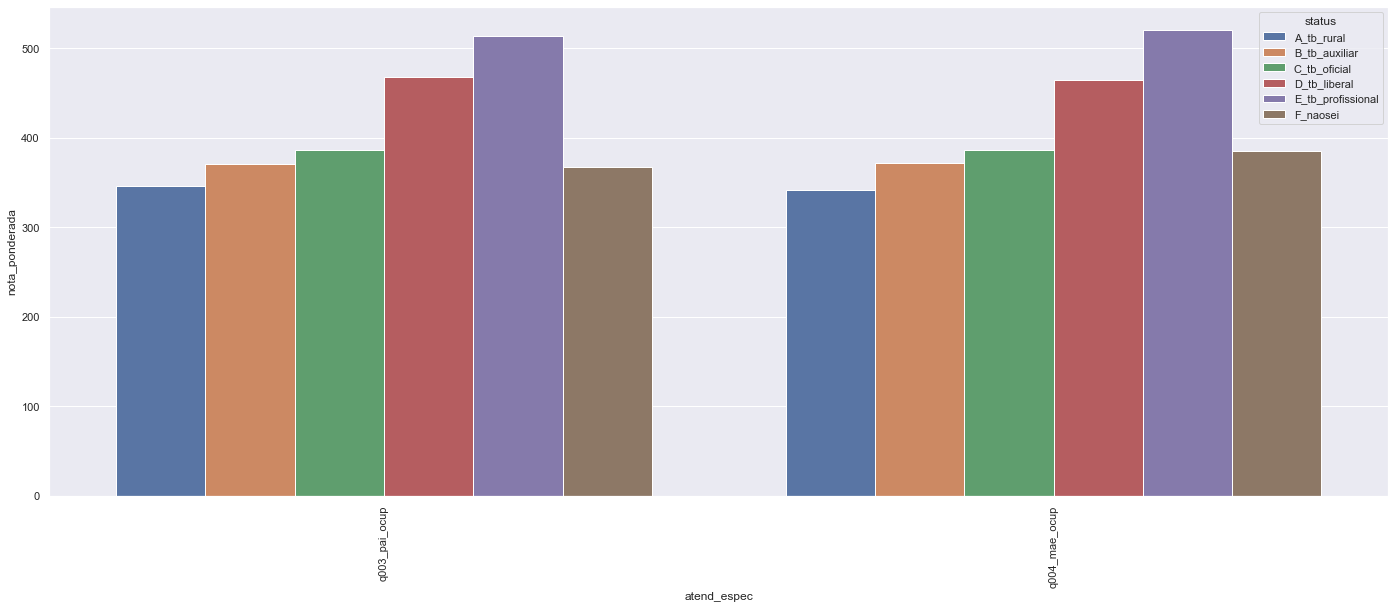

In [110]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [111]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,A_tb_rural,309.75,348.25,359.50,332.25,376.25,345.75,568394,q003_pai_ocup
1,B_tb_auxiliar,326.50,371.00,384.00,353.00,413.00,371.00,561446,q003_pai_ocup
2,C_tb_oficial,341.50,386.00,398.25,372.00,430.75,387.00,626006,q003_pai_ocup
3,D_tb_liberal,412.25,454.00,459.25,462.00,537.50,468.25,449866,q003_pai_ocup
4,E_tb_profissional,450.75,491.50,488.50,519.50,598.50,513.50,145257,q003_pai_ocup
5,F_naosei,325.75,371.00,383.50,353.00,404.25,368.00,298543,q003_pai_ocup
0,A_tb_rural,307.75,345.25,356.25,329.25,370.50,342.25,461600,q004_mae_ocup
1,B_tb_auxiliar,327.75,372.75,385.50,355.00,413.50,372.25,1147923,q004_mae_ocup
2,C_tb_oficial,340.75,385.50,397.25,372.25,428.75,386.00,181230,q004_mae_ocup
3,D_tb_liberal,409.50,451.00,456.75,458.25,534.00,465.25,532181,q004_mae_ocup


### 4.2.15 QUESTIONARIO SOCIAL VS NOTAS - Q005 - Total de Ocupantes
- A maioria dos participantes indicaram até 4 pessoas morando junto, no qual também representa a maior nota. Entretanto, não existe uma tendência de aumento ou queda conforme este número aumenta.

In [112]:
atend_espec = df4.iloc[:, 79:80].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

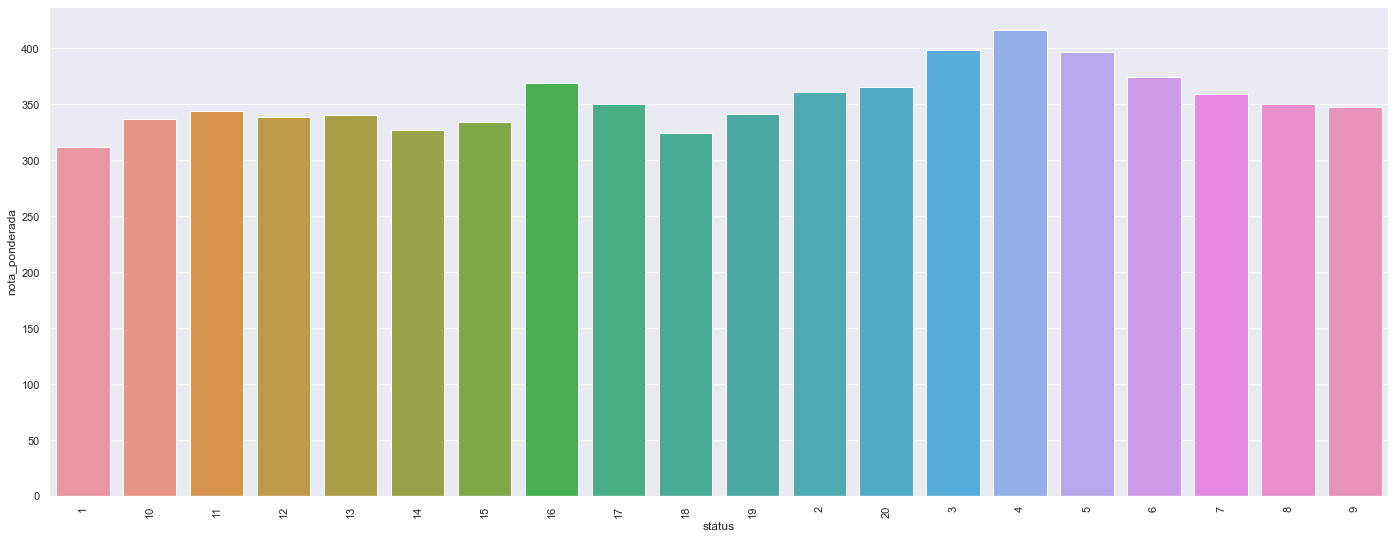

In [113]:
sns.barplot(data=nota_, x='status', y='nota_ponderada').tick_params(axis='x', labelrotation=90);

In [114]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,1,277.75,320.75,325.00,299.25,339.25,312.00,74086,q005_res_ocup
1,10,300.50,343.25,355.25,321.50,363.25,336.75,7347,q005_res_ocup
2,11,309.25,349.00,360.50,329.25,370.00,343.75,2311,q005_res_ocup
3,12,305.50,346.00,357.75,323.75,360.75,338.50,1500,q005_res_ocup
4,13,302.00,348.25,358.25,325.50,368.50,340.25,782,q005_res_ocup
5,14,290.00,336.25,349.25,306.00,353.00,327.00,407,q005_res_ocup
6,15,301.25,344.75,355.50,317.50,354.25,334.00,332,q005_res_ocup
7,16,331.75,384.75,396.50,356.00,388.75,369.50,161,q005_res_ocup
8,17,310.50,364.00,370.00,326.00,381.00,350.50,85,q005_res_ocup
9,18,284.25,342.25,354.00,302.25,345.50,324.25,74,q005_res_ocup


### 4.2.16 QUESTIONARIO SOCIAL VS NOTAS - Q006 - Renda Familiar
- Há uma clara correção da renda com o valor da nota final do aluno. Quanto maior renda, melhor a nota.

In [115]:
atend_espec = df4.iloc[:, 80:81].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

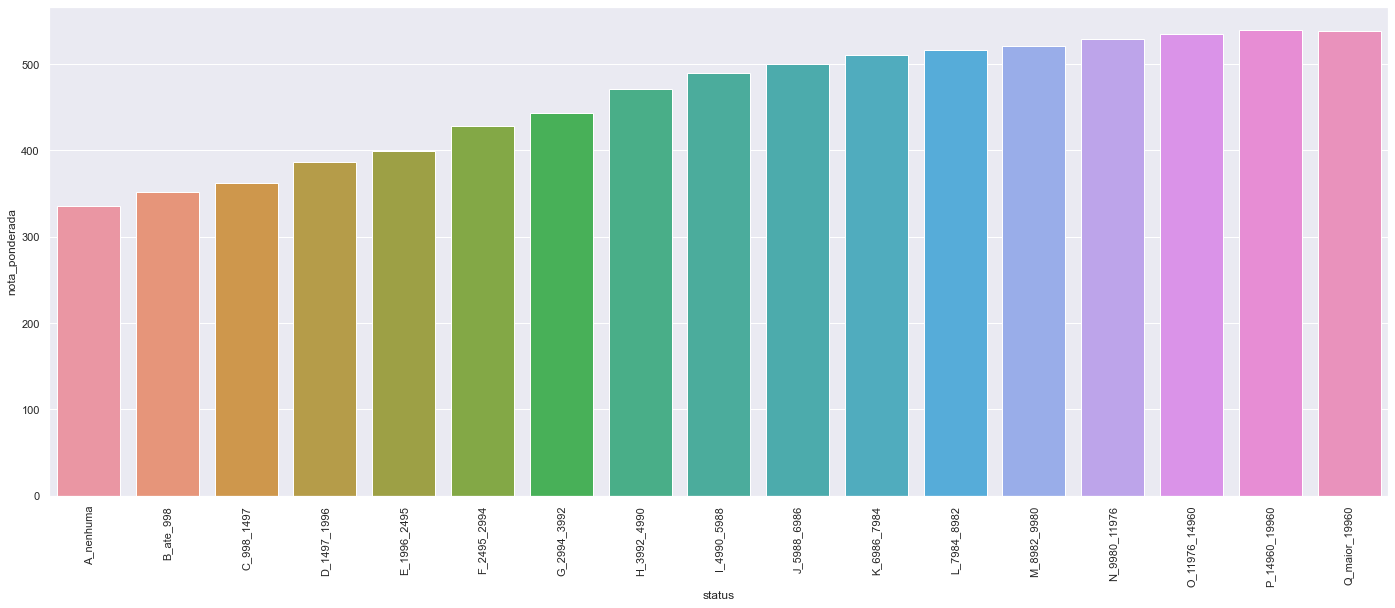

In [116]:
sns.barplot(data=nota_, x='status', y='nota_ponderada').tick_params(axis='x', labelrotation=90);

In [117]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,A_nenhuma,301.00,340.25,353.50,320.00,360.25,335.00,120391,q006_fam_renda
1,B_ate_998,312.75,354.25,368.75,334.25,385.25,352.00,662576,q006_fam_renda
2,C_998_1497,319.50,363.25,376.50,343.50,401.00,362.00,682416,q006_fam_renda
3,D_1497_1996,341.25,385.75,396.75,372.50,429.75,386.50,259305,q006_fam_renda
4,E_1996_2495,351.75,396.25,406.50,385.25,447.25,399.00,247240,q006_fam_renda
5,F_2495_2994,378.50,422.00,430.25,420.50,483.00,428.75,117477,q006_fam_renda
6,G_2994_3992,390.25,433.75,440.50,435.25,503.25,443.00,157137,q006_fam_renda
7,H_3992_4990,416.25,457.50,461.50,468.75,538.50,471.25,100274,q006_fam_renda
8,I_4990_5988,431.50,472.75,475.25,488.75,562.00,489.25,74669,q006_fam_renda
9,J_5988_6986,440.75,481.00,481.50,501.25,579.00,500.50,41931,q006_fam_renda


### 4.2.16 QUESTIONARIO SOCIAL VS NOTAS - Q007 - Empregados
- A existência de empregados domésticos indica um valor maior da nota. Provalvente também se correlaciona a renda.

In [118]:
atend_espec = df4.iloc[:, 81:82].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

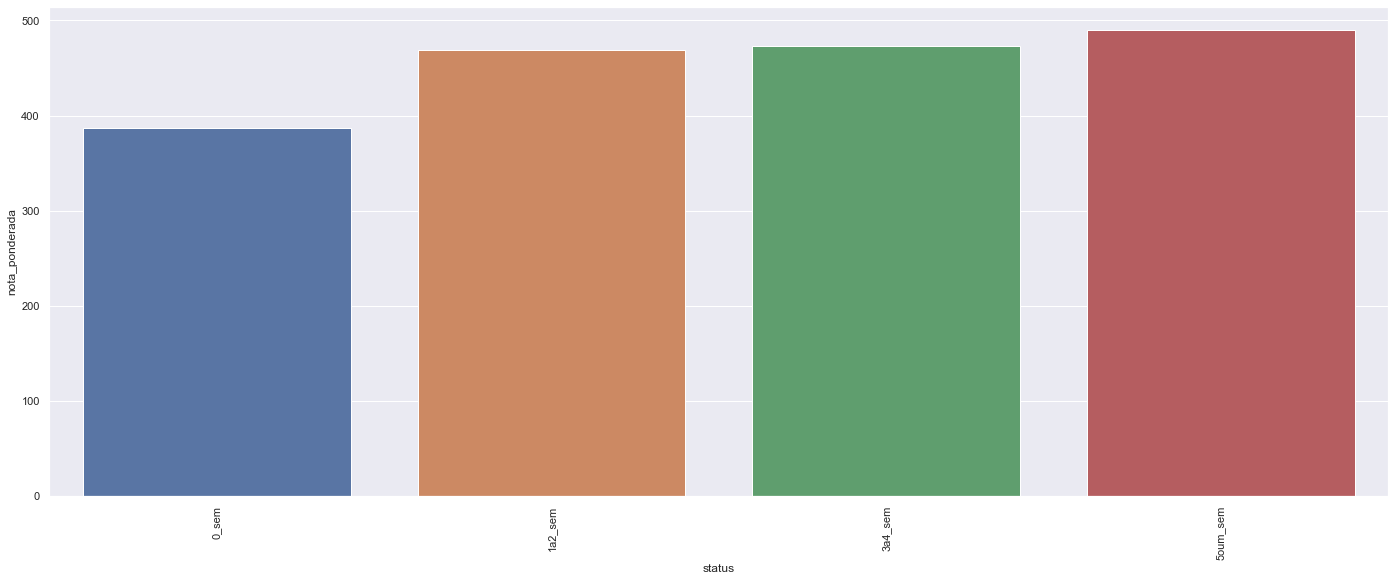

In [119]:
sns.barplot(data=nota_, x='status', y='nota_ponderada').tick_params(axis='x', labelrotation=90);

In [120]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,0_sem,342.25,385.00,395.75,373.00,430.75,386.75,2457300,q007_res_empreg
1,1a2_sem,412.75,454.00,455.25,470.75,540.00,469.25,102671,q007_res_empreg
2,3a4_sem,414.25,456.75,457.75,475.75,548.00,473.50,21882,q007_res_empreg
3,5oum_sem,428.50,470.00,470.25,493.75,570.00,490.00,67659,q007_res_empreg


### 4.2.14 QUESTIONARIO SOCIAL VS NOTAS - Q008 a Q025 - Itens residência
- Quanto mais banheiros, televisores, celulares e computadores melhor é a nota do candidato.
- A existência isolada da internet em si não é tão significativa (é melhor estutante ter tv por assinatura...)
- Os demais itens não possui uma crescente, variam a cada quantidade.


In [121]:
atend_espec = df4.iloc[:, 82:100].columns.tolist()
nota_ = pd.DataFrame()
mapa = {'0': 'nao', '1': 'sim'}
for i in atend_espec:
    aux = df4[[i, 'prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao', 'nota_ponderada']].copy()
    nota = aux.groupby(i).mean().reset_index()
    nota['participantes'] = aux[[i, 'nota_ponderada']].groupby(i).count()['nota_ponderada'].tolist()
    nota['atend_espec'] = nota.columns.tolist()[0]
    nota = nota.rename(columns={i:'status'})
    #nota['atend_espec'] = nota['atend_espec'] + "_" + nota['status'].map(mapa)
    nota_ = pd.concat([nota_, nota])

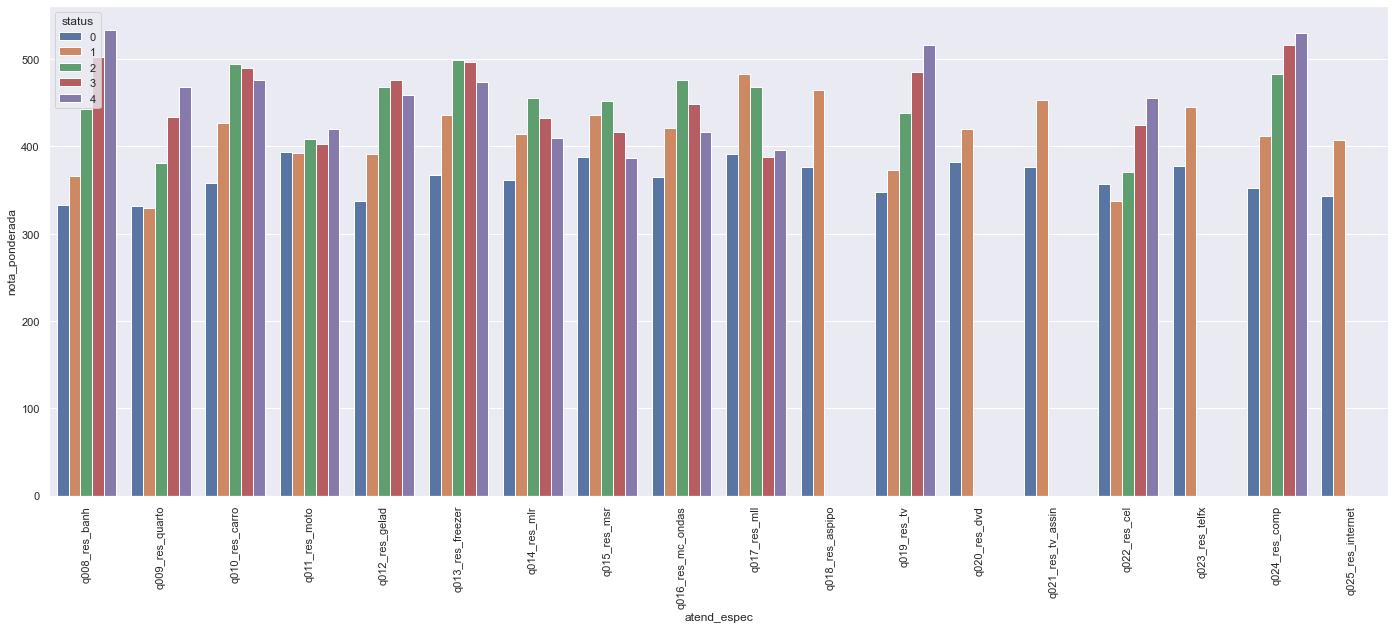

In [122]:
sns.barplot(data=nota_, x='atend_espec', y='nota_ponderada', hue='status').tick_params(axis='x', labelrotation=90);

In [123]:
nota_

,status,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada,participantes,atend_espec
0,0,299.75,339.25,350.25,320.00,358.50,333.50,25816,q008_res_banh
1,1,324.00,367.00,379.50,350.00,404.75,366.25,1871620,q008_res_banh
2,2,391.25,433.25,440.50,435.25,501.75,442.75,535833,q008_res_banh
3,3,442.50,482.50,483.75,504.50,581.00,502.50,142947,q008_res_banh
4,4,468.00,508.25,504.25,544.50,625.00,534.00,73296,q008_res_banh
0,0,294.75,339.75,350.25,314.00,360.00,331.75,21348,q009_res_quarto
1,1,291.25,335.25,346.75,311.25,359.50,329.25,362303,q009_res_quarto
2,2,336.50,379.50,391.25,365.75,423.50,380.75,1339809,q009_res_quarto
3,3,383.00,424.75,432.75,425.50,490.00,433.50,798340,q009_res_quarto
4,4,413.00,454.50,457.75,466.75,534.00,467.75,127712,q009_res_quarto


In [124]:
df4.iloc[:, 82:100].columns

Index(['q008_res_banh', 'q009_res_quarto', 'q010_res_carro', 'q011_res_moto',
       'q012_res_gelad', 'q013_res_freezer', 'q014_res_mlr', 'q015_res_msr',
       'q016_res_mc_ondas', 'q017_res_mll', 'q018_res_aspipo', 'q019_res_tv',
       'q020_res_dvd', 'q021_res_tv_assin', 'q022_res_cel', 'q023_res_telfx',
       'q024_res_comp', 'q025_res_internet'],
      dtype='object')

In [125]:
df4.head()

,pt_nu_inscricao,pt_co_municipio_residencia,pt_no_municipio_residencia,pt_co_uf_residencia,pt_sg_uf_residencia,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_co_municipio,prv_no_municipio,prv_co_uf,prv_sg_uf,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_lingua,prv_status_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada
0,9d982e42-a1f9-4b0e-9b4d-322ae42ef594,3205002,serra,32,ES,19.00,f,solteiro,parda,br_nato,term_ano_corrente,nd,privada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3205002,Serra,32,ES,faltou,faltou,faltou,faltou,espanhol,aus_elimin,H_naosabe,F_c_ens_sup,F_naosei,D_tb_liberal,3,C_998_1497,0_sem,2,2,1,0,1,1,1,0,1,0,0,2,1,0,3,1,0,1,0.00,0.00,0.00,0.00,0.00,0.00
1,376c1241-64e6-4ab0-8bad-3084ff5e26f9,1720903,taguatinga,17,TO,17.00,m,solteiro,parda,br_nato,term_prox_ano,nd,publica,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1720903,Taguatinga,17,TO,faltou,faltou,faltou,faltou,espanhol,aus_elimin,E_c_ens_medio,D_nc_ens_medio,A_tb_rural,A_tb_rural,4,A_nenhuma,0_sem,2,4,0,0,1,1,1,0,1,0,0,1,0,0,2,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,42d5342f-f625-450b-9e06-2168a112676c,1302603,manaus,13,AM,28.00,f,solteiro,parda,br_nato,concluido,2009,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1302603,Manaus,13,AM,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,E_c_ens_medio,C_tb_oficial,D_tb_liberal,4,H_3992_4990,0_sem,2,4,1,0,1,1,1,0,0,0,0,0,0,0,4,0,2,1,507.50,390.50,522.00,522.50,720.00,564.00
3,54c7d711-e938-461b-bebf-8f0f714fa61b,3118601,contagem,31,MG,20.00,f,solteiro,parda,br_nato,concluido,2017,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3118601,Contagem,31,MG,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,C_c_ens_fund,B_tb_auxiliar,C_tb_oficial,3,C_998_1497,0_sem,1,2,1,0,1,0,0,0,1,0,0,1,1,0,1,1,1,1,388.75,456.25,481.25,457.00,700.00,514.00
4,c91f6c69-fe8c-487e-b280-301f15d1707d,2411908,são francisco do oeste,24,RN,29.00,m,solteiro,branca,br_nato,concluido,2016,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2409407,Pau dos Ferros,24,RN,faltou,faltou,faltou,faltou,espanhol,aus_elimin,B_nc_ens_fund,B_nc_ens_fund,A_tb_rural,A_tb_rural,1,A_nenhuma,0_sem,1,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0.00,0.00,0.00,0.00,0.00,0.00


## 4.3. ANÁLISE MULTIVARIADA

### 4.3.1. NUMERICAL ATTIBUTES

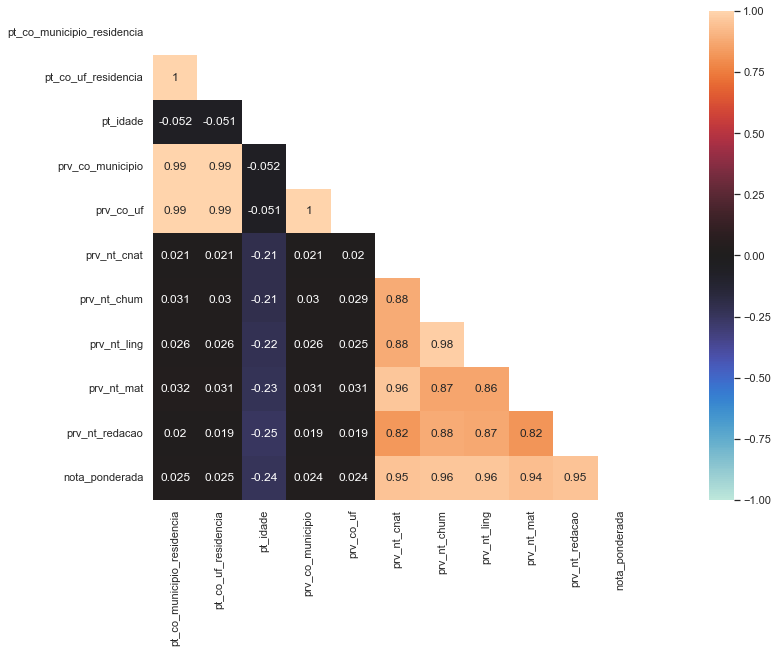

In [126]:
corr = num_attributes.corr(method ='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.3.2. CATEGORICAL ATTRIBUTES

In [127]:
cat_attributes = cat_attributes.drop('pt_nu_inscricao', axis=1)

#### DADOS PARTICIPANTE

C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


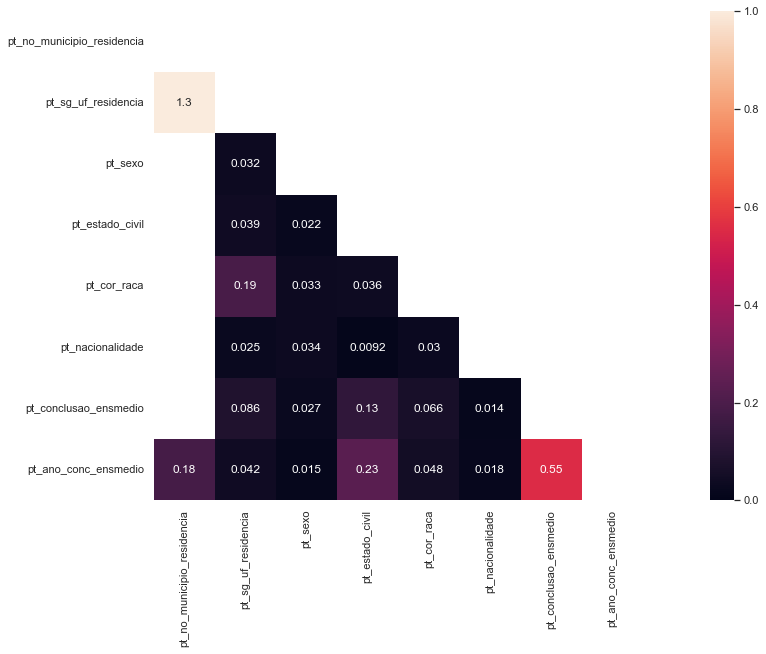

In [128]:
a = cat_attributes.iloc[:,0:8].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS ESPECIFICOS PARTICIPANTE

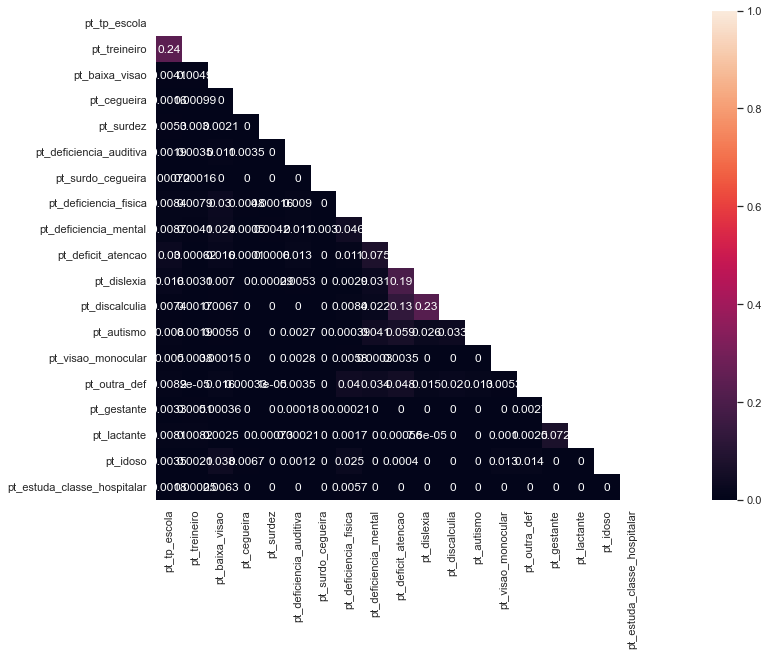

In [129]:
a = cat_attributes.iloc[:,8:27].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS ESPECIFICOS PROVA

C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value enco

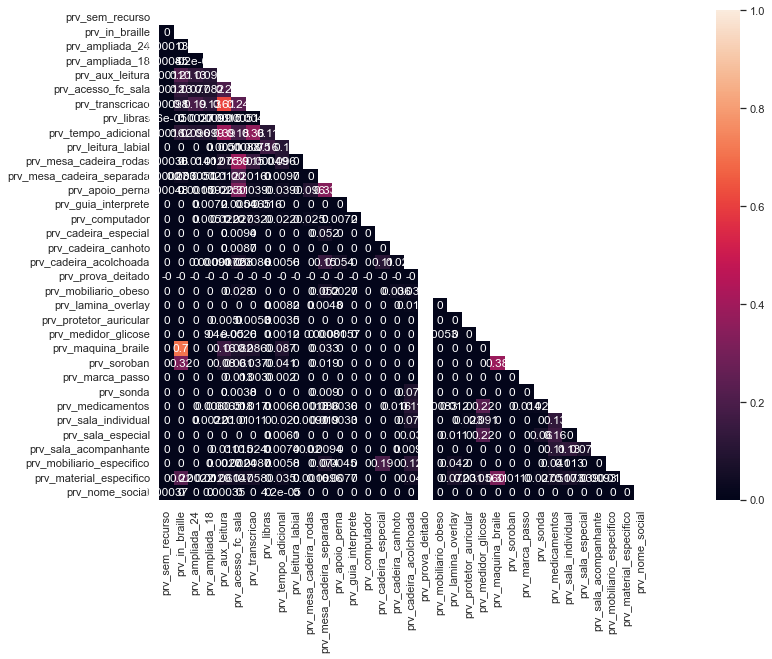

In [130]:
a = cat_attributes.iloc[:,27:61].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS LOCAL / PRESENÇA PROVA

C:\Users\kaotc\AppData\Local\Temp\ipykernel_2220\624951368.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


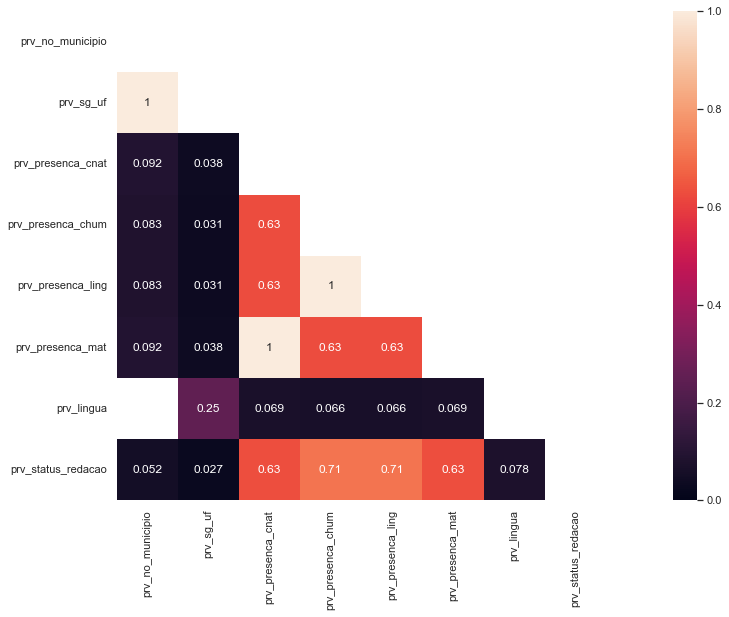

In [131]:
a = cat_attributes.iloc[:,61:69].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

#### DADOS LOCAL / PRESENÇA PROVA

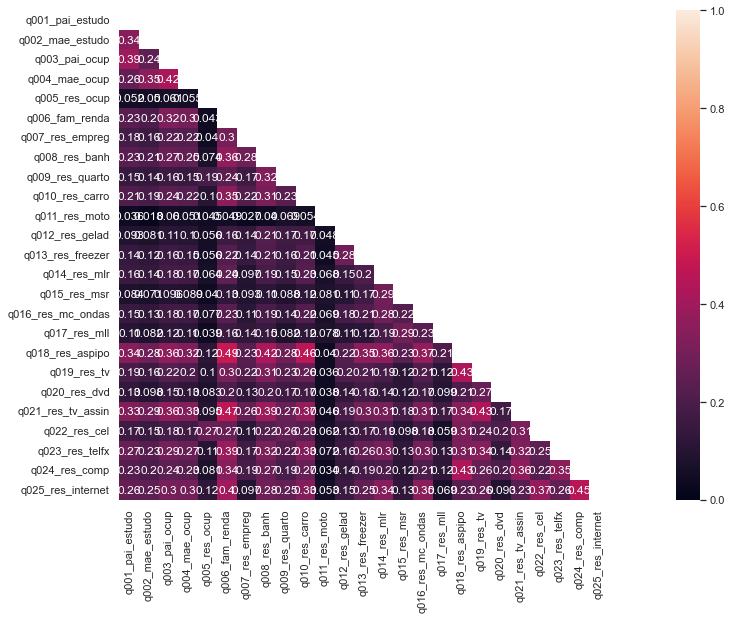

In [132]:
a = cat_attributes.iloc[:,69:].copy()
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
corr = pd.DataFrame(crm_l)
corr.columns = a_d
corr.index = a_d

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# <font color='red'> 5.0. Data Preparation </font>

In [7]:
df5 = df4.copy()
#df5['pt_munc_uf'] = df5['pt_sg_uf_residencia'] + "/" + df5['pt_no_municipio_residencia']
#df5['prv_munc_uf'] = df5['prv_sg_uf'] + "/" + df5['prv_no_municipio']
df5 = df5.drop(columns=['pt_co_municipio_residencia' ,'pt_no_municipio_residencia','pt_co_uf_residencia' ,'pt_sg_uf_residencia', 
                        'prv_co_municipio', 'prv_no_municipio', 'prv_co_uf', 'prv_sg_uf'])
df5.head()

,pt_nu_inscricao,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_lingua,prv_status_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada
0,9d982e42-a1f9-4b0e-9b4d-322ae42ef594,19.00,f,solteiro,parda,br_nato,term_ano_corrente,nd,privada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,faltou,faltou,faltou,faltou,espanhol,aus_elimin,H_naosabe,F_c_ens_sup,F_naosei,D_tb_liberal,3,C_998_1497,0_sem,2,2,1,0,1,1,1,0,1,0,0,2,1,0,3,1,0,1,0.00,0.00,0.00,0.00,0.00,0.00
1,376c1241-64e6-4ab0-8bad-3084ff5e26f9,17.00,m,solteiro,parda,br_nato,term_prox_ano,nd,publica,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,faltou,faltou,faltou,faltou,espanhol,aus_elimin,E_c_ens_medio,D_nc_ens_medio,A_tb_rural,A_tb_rural,4,A_nenhuma,0_sem,2,4,0,0,1,1,1,0,1,0,0,1,0,0,2,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,42d5342f-f625-450b-9e06-2168a112676c,28.00,f,solteiro,parda,br_nato,concluido,2009,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,E_c_ens_medio,C_tb_oficial,D_tb_liberal,4,H_3992_4990,0_sem,2,4,1,0,1,1,1,0,0,0,0,0,0,0,4,0,2,1,507.50,390.50,522.00,522.50,720.00,564.00
3,54c7d711-e938-461b-bebf-8f0f714fa61b,20.00,f,solteiro,parda,br_nato,concluido,2017,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,C_c_ens_fund,B_tb_auxiliar,C_tb_oficial,3,C_998_1497,0_sem,1,2,1,0,1,0,0,0,1,0,0,1,1,0,1,1,1,1,388.75,456.25,481.25,457.00,700.00,514.00
4,c91f6c69-fe8c-487e-b280-301f15d1707d,29.00,m,solteiro,branca,br_nato,concluido,2016,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,faltou,faltou,faltou,faltou,espanhol,aus_elimin,B_nc_ens_fund,B_nc_ens_fund,A_tb_rural,A_tb_rural,1,A_nenhuma,0_sem,1,2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
df5_r = df5.copy()

In [9]:
# DIA 1
df5_r_presente_dia1 = df5_r[(df5_r['prv_presenca_ling'] == 'presente')].copy()
df5_r_presente_dia1 = df5_r_presente_dia1.drop(columns=['prv_presenca_cnat', 'prv_presenca_ling', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_status_redacao','prv_nt_cnat', 'prv_nt_mat', 'prv_nt_redacao','nota_ponderada'])

df5_r_ausente_dia1 = df5_r[~(df5_r['prv_presenca_ling'] == 'presente')].copy()
df5_r_ausente_dia1 = df5_r_ausente_dia1[['pt_nu_inscricao', 'prv_nt_chum', 'prv_nt_ling']]

# DIA 2
df5_r_presente_dia2 = df5_r[(df5_r['prv_presenca_cnat'] == 'presente')].copy()
df5_r_presente_dia2 = df5_r_presente_dia2.drop(columns=['prv_presenca_cnat', 'prv_presenca_ling', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_status_redacao', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_redacao','nota_ponderada'])

df5_r_ausente_dia2 = df5_r[~(df5_r['prv_presenca_cnat'] == 'presente')].copy()
df5_r_ausente_dia2 = df5_r_ausente_dia2[['pt_nu_inscricao', 'prv_nt_cnat', 'prv_nt_mat']]

# REDAÇÂO
df5_r_presente_redacao = df5_r[(df5_r['prv_status_redacao'] == 'ok')].copy()
df5_r_presente_redacao = df5_r_presente_redacao.drop(columns=['prv_presenca_cnat', 'prv_presenca_ling', 'prv_presenca_chum', 'prv_presenca_ling', 'prv_presenca_mat', 'prv_status_redacao', 'prv_nt_cnat', 'prv_nt_mat', 'prv_nt_chum', 'prv_nt_ling','nota_ponderada'])

df5_r_ausente_redacao = df5_r[~(df5_r['prv_status_redacao'] == 'ok')].copy()
df5_r_ausente_redacao = df5_r_ausente_redacao[['pt_nu_inscricao', 'prv_nt_redacao']]

In [10]:
df5_r_ausente_redacao.head()

,pt_nu_inscricao,prv_nt_redacao
0,9d982e42-a1f9-4b0e-9b4d-322ae42ef594,0.00
1,376c1241-64e6-4ab0-8bad-3084ff5e26f9,0.00
4,c91f6c69-fe8c-487e-b280-301f15d1707d,0.00
7,b05afb45-4774-4ad3-b651-d226df07a6ac,0.00
8,867e598c-e627-410c-8ef3-20039ed9f368,0.00


DF Criados
* df5_r_presente_dia1
* df5_r_ausente_dia1
* df5_r_presente_dia2
* df5_r_ausente_dia2
* df5_r_presente_redacao
* df5_r_ausente_redacao

In [11]:
num_attributes = df5.select_dtypes(include=('int8', 'int32','float16'))
cat_attributes = df5.select_dtypes(exclude=('int8', 'int32', 'float16', 'datetime64[ns]'))

## 5.1. NORMALIZATION

In [12]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
pt_idade,2649512.00,NaN,0.00,10.00,18.00,19.00,24.00,91.00
pt_treineiro,2649512.00,0.12,0.33,0.00,0.00,0.00,0.00,1.00
pt_baixa_visao,2649512.00,0.00,0.03,0.00,0.00,0.00,0.00,1.00
pt_cegueira,2649512.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
pt_surdez,2649512.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
pt_deficiencia_auditiva,2649512.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
pt_surdo_cegueira,2649512.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
pt_deficiencia_fisica,2649512.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
pt_deficiencia_mental,2649512.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
pt_deficit_atencao,2649512.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00


## 5.2. RESCALLING

In [13]:
def rescalling(df5):
    #rs_columns = []
    mms_columns = ['pt_idade']
    
    #rs = RobustScaler()
    mms = MinMaxScaler()
    
    #Min-Max Scaler
    df5[mms_columns] = mms.fit_transform(df5[mms_columns])
    
    #Robest Scaler
    #df5_r[rs_columns] = rs.fit_transform(df5[rs_columns])
    return df5

In [14]:
df5_r_presente_dia1 = rescalling(df5_r_presente_dia1)
df5_r_presente_dia2 = rescalling(df5_r_presente_dia2)
df5_r_presente_redacao = rescalling(df5_r_presente_redacao)

## 5.3. TRANSFORMATION

### 5.3.1 ENCODING

In [15]:
cat_attributes.describe().T

,count,unique,top,freq
pt_nu_inscricao,2649512,2649512,000016f3-fdf1-4ba5-8974-91e5c8343f99,1
pt_sexo,2649512,2,f,1576666
pt_estado_civil,2649512,5,solteiro,2287023
pt_cor_raca,2649512,6,parda,1229928
pt_nacionalidade,2649512,5,br_nato,2574060
pt_conclusao_ensmedio,2649512,4,concluido,1556643
pt_ano_conc_ensmedio,2649512,14,nd,1145647
pt_tp_escola,2649512,3,publica,1887540
prv_presenca_cnat,2649512,3,presente,1928240
prv_presenca_chum,2649512,3,presente,2039091


In [16]:
#df5_r_presente_redacao.iloc[:, 9:61].head()

In [17]:
def encoding(df5):
    # Convertendo em int os dados sobre o participante e solicitações de prova (0 ou 1)
    df5.iloc[:, 9:61] = df5_r.iloc[:, 9:61].astype('int')
    
    # state_holiday - One Hot Encoding
    df5 = pd.get_dummies(df5, prefix=['pt_sexo'], columns=['pt_sexo'])
    df5 = pd.get_dummies(df5, prefix=['pt_estado_civil'], columns=['pt_estado_civil'])
    df5 = pd.get_dummies(df5, prefix=['pt_cor_raca'], columns=['pt_cor_raca'])
    df5 = pd.get_dummies(df5, prefix=['pt_nacionalidade'], columns=['pt_nacionalidade'])
    df5 = pd.get_dummies(df5, prefix=['pt_conclusao_ensmedio'], columns=['pt_conclusao_ensmedio'])
    df5 = pd.get_dummies(df5, prefix=['pt_ano_conc_ensmedio'], columns=['pt_ano_conc_ensmedio'])
    df5 = pd.get_dummies(df5, prefix=['pt_tp_escola'], columns=['pt_tp_escola'])
    
    # Dados relativos a prova - One Hot Encoding
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_cnat'], columns=['prv_presenca_cnat'])
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_chum'], columns=['prv_presenca_chum'])
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_ling'], columns=['prv_presenca_ling'])
    #df5 = pd.get_dummies(df5, prefix=['prv_presenca_mat'], columns=['prv_presenca_mat'])
    df5 = pd.get_dummies(df5, prefix=['prv_lingua'], columns=['prv_lingua'])
    #df5 = pd.get_dummies(df5, prefix=['prv_status_redacao'], columns=['prv_status_redacao'])
    
    # Dados relativos a questionário social - One Hot Encoding
    df5 = pd.get_dummies(df5, prefix=['q001_pai_estudo'], columns=['q001_pai_estudo'])
    df5 = pd.get_dummies(df5, prefix=['q002_mae_estudo'], columns=['q002_mae_estudo'])
    df5 = pd.get_dummies(df5, prefix=['q003_pai_ocup'], columns=['q003_pai_ocup'])
    df5 = pd.get_dummies(df5, prefix=['q004_mae_ocup'], columns=['q004_mae_ocup'])
    df5 = pd.get_dummies(df5, prefix=['q005_res_ocup'], columns=['q005_res_ocup'])
    df5 = pd.get_dummies(df5, prefix=['q006_fam_renda'], columns=['q006_fam_renda'])
    df5 = pd.get_dummies(df5, prefix=['q007_res_empreg'], columns=['q007_res_empreg'])
    df5 = pd.get_dummies(df5, prefix=['q008_res_banh'], columns=['q008_res_banh'])
    df5 = pd.get_dummies(df5, prefix=['q009_res_quarto'], columns=['q009_res_quarto'])
    df5 = pd.get_dummies(df5, prefix=['q010_res_carro'], columns=['q010_res_carro'])
    df5 = pd.get_dummies(df5, prefix=['q011_res_moto'], columns=['q011_res_moto'])
    df5 = pd.get_dummies(df5, prefix=['q012_res_gelad'], columns=['q012_res_gelad'])
    df5 = pd.get_dummies(df5, prefix=['q013_res_freezer'], columns=['q013_res_freezer'])
    df5 = pd.get_dummies(df5, prefix=['q014_res_mlr'], columns=['q014_res_mlr'])
    df5 = pd.get_dummies(df5, prefix=['q015_res_msr'], columns=['q015_res_msr'])
    df5 = pd.get_dummies(df5, prefix=['q016_res_mc_ondas'], columns=['q016_res_mc_ondas'])
    df5 = pd.get_dummies(df5, prefix=['q017_res_mll'], columns=['q017_res_mll'])
    df5 = pd.get_dummies(df5, prefix=['q018_res_aspipo'], columns=['q018_res_aspipo'])
    df5 = pd.get_dummies(df5, prefix=['q019_res_tv'], columns=['q019_res_tv'])
    df5 = pd.get_dummies(df5, prefix=['q020_res_dvd'], columns=['q020_res_dvd'])
    df5 = pd.get_dummies(df5, prefix=['q021_res_tv_assin'], columns=['q021_res_tv_assin'])
    df5 = pd.get_dummies(df5, prefix=['q022_res_cel'], columns=['q022_res_cel'])
    df5 = pd.get_dummies(df5, prefix=['q023_res_telfx'], columns=['q023_res_telfx'])
    df5 = pd.get_dummies(df5, prefix=['q024_res_comp'], columns=['q024_res_comp'])
    df5 = pd.get_dummies(df5, prefix=['q025_res_internet'], columns=['q025_res_internet'])
    return df5

In [18]:
df5_r_presente_dia1 = encoding(df5_r_presente_dia1)
df5_r_presente_dia2 = encoding(df5_r_presente_dia2)
df5_r_presente_redacao = encoding(df5_r_presente_redacao)

### 5.3.2. RESPONSE VARIABLE TRANSFORMATION

In [19]:
# DIA 01
df5_r_presente_dia1['prv_nt_ling'] = np.log1p(df5_r_presente_dia1['prv_nt_ling'])
df5_r_presente_dia1['prv_nt_chum'] = np.log1p(df5_r_presente_dia1['prv_nt_chum'])

# DIA 02
df5_r_presente_dia2['prv_nt_cnat'] = np.log1p(df5_r_presente_dia2['prv_nt_cnat'])
df5_r_presente_dia2['prv_nt_mat'] = np.log1p(df5_r_presente_dia2['prv_nt_mat'])

# REDAÇÃO
df5_r_presente_redacao['prv_nt_redacao'] = np.log1p(df5_r_presente_redacao['prv_nt_redacao'])

In [20]:
#df5_r.to_csv('../../data/c1/c01_05_enem_r.csv', index=False)
#df5.to_csv('../../data/c1/c01_05_enem.csv', index=False)

# <font color='red'> 6.0. Feature Selection </font>

In [21]:
#df6 = pd.read_csv('../../data/c1/c01_05_enem_r.csv')
df6 = df5_r_presente_dia1.copy()
df6.head(2)

,pt_nu_inscricao,pt_idade,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_nt_chum,prv_nt_ling,pt_sexo_f,pt_sexo_m,pt_estado_civil_casado,pt_estado_civil_divorciado,pt_estado_civil_nd,pt_estado_civil_solteiro,pt_estado_civil_viuvo,pt_cor_raca_amarela,pt_cor_raca_branca,pt_cor_raca_indigina,pt_cor_raca_nd,pt_cor_raca_parda,pt_cor_raca_preta,pt_nacionalidade_br_nasc_estrang,pt_nacionalidade_br_nato,pt_nacionalidade_br_natur,pt_nacionalidade_estrang,pt_nacionalidade_nd,pt_conclusao_ensmedio_concluido,pt_conclusao_ensmedio_nao_conc_n_ensmed,pt_conclusao_ensmedio_term_ano_corrente,pt_conclusao_ensmedio_term_prox_ano,pt_ano_conc_ensmedio_2007,pt_ano_conc_ensmedio_2008,pt_ano_conc_ensmedio_2009,pt_ano_conc_ensmedio_2010,pt_ano_conc_ensmedio_2011,pt_ano_conc_ensmedio_2012,pt_ano_conc_ensmedio_2013,pt_ano_conc_ensmedio_2014,pt_ano_conc_ensmedio_2015,pt_ano_conc_ensmedio_2016,pt_ano_conc_ensmedio_2017,pt_ano_conc_ensmedio_2018,pt_ano_conc_ensmedio_antes_2007,pt_ano_conc_ensmedio_nd,pt_tp_escola_exterior,pt_tp_escola_privada,pt_tp_escola_publica,prv_lingua_espanhol,prv_lingua_ingles,q001_pai_estudo_A_s_estudo,q001_pai_estudo_B_nc_ens_fund,q001_pai_estudo_C_c_ens_fund,q001_pai_estudo_D_nc_ens_medio,q001_pai_estudo_E_c_ens_medio,q001_pai_estudo_F_c_ens_sup,q001_pai_estudo_G_c_pos_grad,q001_pai_estudo_H_naosabe,q002_mae_estudo_A_s_estudo,q002_mae_estudo_B_nc_ens_fund,q002_mae_estudo_C_c_ens_fund,q002_mae_estudo_D_nc_ens_medio,q002_mae_estudo_E_c_ens_medio,q002_mae_estudo_F_c_ens_sup,q002_mae_estudo_G_c_pos_grad,q002_mae_estudo_H_naosabe,q003_pai_ocup_A_tb_rural,q003_pai_ocup_B_tb_auxiliar,q003_pai_ocup_C_tb_oficial,q003_pai_ocup_D_tb_liberal,q003_pai_ocup_E_tb_profissional,q003_pai_ocup_F_naosei,q004_mae_ocup_A_tb_rural,q004_mae_ocup_B_tb_auxiliar,q004_mae_ocup_C_tb_oficial,q004_mae_ocup_D_tb_liberal,q004_mae_ocup_E_tb_profissional,q004_mae_ocup_F_naosei,q005_res_ocup_1,q005_res_ocup_2,q005_res_ocup_3,q005_res_ocup_4,q005_res_ocup_5,q005_res_ocup_6,q005_res_ocup_7,q005_res_ocup_8,q005_res_ocup_9,q005_res_ocup_10,q005_res_ocup_11,q005_res_ocup_12,q005_res_ocup_13,q005_res_ocup_14,q005_res_ocup_15,q005_res_ocup_16,q005_res_ocup_17,q005_res_ocup_18,q005_res_ocup_19,q005_res_ocup_20,q006_fam_renda_A_nenhuma,q006_fam_renda_B_ate_998,q006_fam_renda_C_998_1497,q006_fam_renda_D_1497_1996,q006_fam_renda_E_1996_2495,q006_fam_renda_F_2495_2994,q006_fam_renda_G_2994_3992,q006_fam_renda_H_3992_4990,q006_fam_renda_I_4990_5988,q006_fam_renda_J_5988_6986,q006_fam_renda_K_6986_7984,q006_fam_renda_L_7984_8982,q006_fam_renda_M_8982_9980,q006_fam_renda_N_9980_11976,q006_fam_renda_O_11976_14960,q006_fam_renda_P_14960_19960,q006_fam_renda_Q_maior_19960,q007_res_empreg_0_sem,q007_res_empreg_1a2_sem,q007_res_empreg_3a4_sem,q007_res_empreg_5oum_sem,q008_res_banh_0,q008_res_banh_1,q008_res_banh_2,q008_res_banh_3,q008_res_banh_4,q009_res_quarto_0,q009_res_quarto_1,q009_res_quarto_2,q009_res_quarto_3,q009_res_quarto_4,q010_res_carro_0,q010_res_carro_1,q010_res_carro_2,q010_res_carro_3,q010_res_carro_4,q011_res_moto_0,q011_res_moto_1,q011_res_moto_2,q011_res_moto_3,q011_res_moto_4,q012_res_gelad_0,q012_res_gelad_1,q

In [22]:
#Training dataset
X = df6.drop(['pt_nu_inscricao', 'prv_nt_chum', 'prv_nt_ling'], axis=1 )
y = df6[['prv_nt_chum', 'prv_nt_ling']].copy()

In [23]:
y.head()

,prv_nt_chum,prv_nt_ling
2,5.97,6.26
3,6.12,6.18
5,6.46,6.44
6,6.29,6.21
9,6.32,6.33


In [26]:
# Ciências Naturais
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1529318, 238) (1529318, 2)
(509773, 238) (509773, 2)


In [28]:
len(y_train.values[:,0])

1529318

## 6.2. BORUTA AS FEATURE SELECTOR

In [ ]:
##training and test dataset for Boruta
#X_train_n = X_train.values
#y_train_n = y_train.values[:,0] #ravel coverter em vetor
#
##define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
##define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

#### 6.2.1.1 BEST FEATURES FROM BORUTA

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [ ]:
#cols_selected_boruta

## 6.3 EXTRA TREE CLASSIFIER

In [ ]:
#model definition
forest = ExtraTreesRegressor(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = X_train
y_train_n = y_train.values

forest.fit(x_train_n, y_train_n)

In [ ]:
importances = forest.feature_importances_ #get the values of features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) #take the std from the feature selector
indices = np.argsort(importances)[::-1] #organize the indice by descendent

# Print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n.columns.values, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    df = df.sort_values('importance', ascending=False)
    df['acumulative'] = df['importance'].cumsum()
    
print (df)

# Plot the impurity-bases feature importances of the forest
plt.figure()
plt.title('Feature importantes')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r',
        yerr=std[indices], align='center')
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

Feature ranking: 
                                   feature  importance  acumulative
0               prv_presenca_cnat_presente        0.35         0.35
0                prv_presenca_mat_presente        0.34         0.69
0                    prv_status_redacao_ok        0.24         0.93
0               prv_presenca_chum_presente        0.01         0.94
0               prv_presenca_ling_presente        0.01         0.95
0            prv_status_redacao_aus_elimin        0.01         0.96
0                          q024_res_comp_0        0.00         0.96
0                                 pt_idade        0.00         0.96
0                          q008_res_banh_1        0.00         0.96
0                      prv_lingua_espanhol        0.00         0.96
0            q002_mae_estudo_E_c_ens_medio        0.00         0.96
0                          q005_res_ocup_4        0.00         0.96
0             q001_pai_estudo_C_c_ens_fund        0.00         0.96
0                          q00

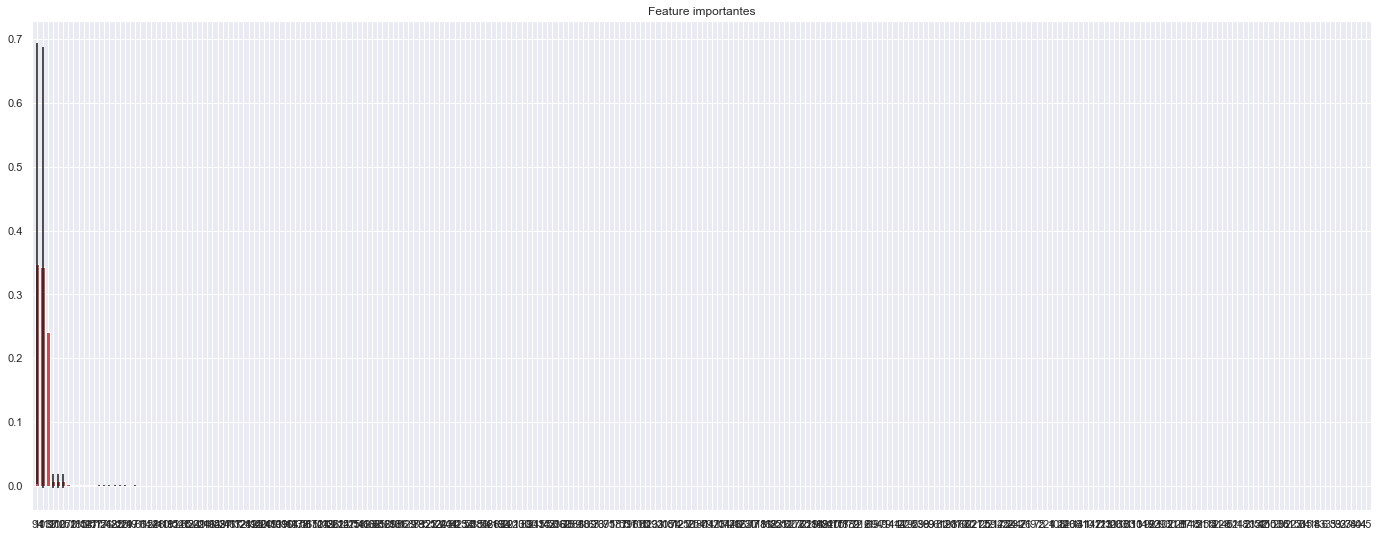

In [186]:
importances = forest.feature_importances_ #get the values of features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) #take the std from the feature selector
indices = np.argsort(importances)[::-1] #organize the indice by descendent

# Print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n.columns.values, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    df = df.sort_values('importance', ascending=False)
    df['acumulative'] = df['importance'].cumsum()
    
print (df)

# Plot the impurity-bases feature importances of the forest
plt.figure()
plt.title('Feature importantes')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r',
        yerr=std[indices], align='center')
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

In [187]:
extra_tree_feat = df.iloc[0:68, ]['feature'].tolist()
extra_tree_feat

['prv_presenca_cnat_presente',
 'prv_presenca_mat_presente',
 'prv_status_redacao_ok',
 'prv_presenca_chum_presente',
 'prv_presenca_ling_presente',
 'prv_status_redacao_aus_elimin',
 'q024_res_comp_0',
 'pt_idade',
 'q008_res_banh_1',
 'prv_lingua_espanhol',
 'q002_mae_estudo_E_c_ens_medio',
 'q005_res_ocup_4',
 'q001_pai_estudo_C_c_ens_fund',
 'q005_res_ocup_3',
 'q022_res_cel_3',
 'q002_mae_estudo_C_c_ens_fund',
 'q016_res_mc_ondas_1',
 'q001_pai_estudo_E_c_ens_medio',
 'q022_res_cel_2',
 'q009_res_quarto_2',
 'pt_cor_raca_branca',
 'pt_cor_raca_parda',
 'q005_res_ocup_5',
 'q022_res_cel_1',
 'q013_res_freezer_1',
 'q001_pai_estudo_D_nc_ens_medio',
 'q009_res_quarto_3',
 'q005_res_ocup_2',
 'q002_mae_estudo_D_nc_ens_medio',
 'pt_cor_raca_preta',
 'q003_pai_ocup_D_tb_liberal',
 'q013_res_freezer_0',
 'q016_res_mc_ondas_0',
 'q001_pai_estudo_B_nc_ens_fund',
 'q010_res_carro_0',
 'q005_res_ocup_6',
 'q019_res_tv_1',
 'q020_res_dvd_0',
 'q006_fam_renda_E_1996_2495',
 'q003_pai_ocup_B_tb

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [188]:
x_train = X_train[extra_tree_feat].copy()
X_val = X_val[extra_tree_feat].copy()

In [189]:
x_training = x_train.copy()
x_training[['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']] = y_train[['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']]

## 7.1 LINEAR REGRESSION MODEL

In [190]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(X_val)

yhat_lr_df = pd.DataFrame(yhat_lr, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])

#performance
lr_result, lr_mcrmse  = ml_error('Linear Regression', np.expm1(y_val), np.expm1(yhat_lr_df))
lr_result

MCRMSE:  84.23333114425809


,MAE,MAPE,RMSE
Linear Regression,,,
prv_nt_cnat,50.56,inf,64.06
prv_nt_chum,57.88,inf,72.51
prv_nt_ling,42.67,inf,55.17
prv_nt_mat,70.72,inf,90.71
prv_nt_redacao,105.90,inf,138.72


### 7.2.1. LINEAR REGRESSION MODEL - CROSS VALIDATION

In [191]:
lr_result_cv, lr_mcrmse_cv = cross_validation(lr, 5, x_training, Verbose = True)
lr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
MCRMSE: 84.27722151265908 +/ -0.19523646734572736


,MAE,MAPE,RMSE
LinearRegression,,,
prv_nt_cnat,50.6709 +/ -0.2702,inf +/ -nan,64.2592 +/ -0.3765
prv_nt_chum,58.0564 +/ -0.2226,inf +/ -nan,72.7727 +/ -0.3121
prv_nt_ling,42.6286 +/ -0.157,inf +/ -nan,55.3695 +/ -0.3303
prv_nt_mat,70.6642 +/ -0.2125,inf +/ -nan,90.6285 +/ -0.2668
prv_nt_redacao,105.6484 +/ -0.3217,inf +/ -nan,138.3563 +/ -0.2536


## 7.3 LINEAR REGRESSION REGULARIZED MODEL - LASSO

In [192]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(X_val)

yhat_lrr_df = pd.DataFrame(yhat_lrr, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])

#performance
lrr_result, lrr_mcrmse = ml_error('Linear Regression - Lasso', np.expm1(y_val), np.expm1(yhat_lrr_df))
lrr_result

MCRMSE:  90.64704995834879


,MAE,MAPE,RMSE
Linear Regression - Lasso,,,
prv_nt_cnat,55.35,inf,69.77
prv_nt_chum,63.50,inf,78.19
prv_nt_ling,48.08,inf,60.75
prv_nt_mat,76.25,inf,97.78
prv_nt_redacao,110.87,inf,146.73


### 7.3.1. LINEAR REGRESSION REGULARIZED MODEL - LASSO - CROSS VALIDATION

In [193]:
lrr_result_cv, lrr_mcrmse_cv = cross_validation(lrr, 5, x_training, Verbose = True)
lrr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
MCRMSE: 90.58773723751071 +/ -0.129647022500812


,MAE,MAPE,RMSE
Lasso,,,
prv_nt_cnat,55.378 +/ -0.2391,inf +/ -nan,69.8733 +/ -0.3235
prv_nt_chum,63.5102 +/ -0.2112,inf +/ -nan,78.2151 +/ -0.2489
prv_nt_ling,48.0792 +/ -0.2017,inf +/ -nan,60.9436 +/ -0.4078
prv_nt_mat,75.9865 +/ -0.1696,inf +/ -nan,97.5833 +/ -0.185
prv_nt_redacao,110.4201 +/ -0.321,inf +/ -nan,146.3234 +/ -0.3335


## 7.4. RANDOM FOREST REGRESSOR

In [194]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(X_val)

yhat_rf_df = pd.DataFrame(yhat_rf, columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao'])

#performance
rf_result, rf_mcrmse = ml_error('Random Forest Regressor', np.expm1(y_val), np.expm1(yhat_rf_df))
rf_result

MCRMSE:  87.40274279839451


,MAE,MAPE,RMSE
Random Forest Regressor,,,
prv_nt_cnat,51.25,inf,65.88
prv_nt_chum,60.06,inf,77.45
prv_nt_ling,44.29,inf,59.12
prv_nt_mat,71.26,inf,92.28
prv_nt_redacao,108.90,inf,142.29


### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [195]:
rf_result_cv, rf_mcrmse_cv = cross_validation(rf, 5, x_training, Verbose = True)
rf_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5
MCRMSE: 87.54433362762431 +/ -0.16471852434629336


,MAE,MAPE,RMSE
RandomForestRegressor,,,
prv_nt_cnat,51.3576 +/ -0.2636,inf +/ -nan,66.0482 +/ -0.4207
prv_nt_chum,60.6454 +/ -0.1315,inf +/ -nan,78.4275 +/ -0.3392
prv_nt_ling,44.509 +/ -0.1563,inf +/ -nan,59.6423 +/ -0.3528
prv_nt_mat,71.0996 +/ -0.2781,inf +/ -nan,92.0434 +/ -0.3189
prv_nt_redacao,108.4227 +/ -0.2449,inf +/ -nan,141.5603 +/ -0.1733


## 7.5. XGBOOST REGRESSOR

###### MODEL

In [196]:
y_indice = y_train.columns.tolist()
yhat_xgb = []
for i in y_indice:
    #model
    model_xgb = xgb.XGBRegressor().fit(x_train, y_train[i])
    
    #prediction
    yhat_xgb_ = model_xgb.predict(X_val)
    yhat_xgb.append(yhat_xgb_)

yhat_xgb_df = pd.DataFrame(yhat_xgb).T
yhat_xgb_df.columns = ['prv_nt_cnat', 'prv_nt_chum', 'prv_nt_ling', 'prv_nt_mat', 'prv_nt_redacao']

#performance
xgb_result, xgb_mcrmse = ml_error('XGBoost Regressor', np.expm1(y_val), np.expm1(yhat_xgb_df))
xgb_result

D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MCRMSE:  84.63453910241172


,MAE,MAPE,RMSE
XGBoost Regressor,,,
prv_nt_cnat,49.81,inf,63.66
prv_nt_chum,58.28,inf,74.62
prv_nt_ling,43.20,inf,57.87
prv_nt_mat,69.31,inf,89.46
prv_nt_redacao,105.00,inf,137.56


### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [197]:
xgb_result_cv, xgb_mcrmse_cv = cross_validation(xgb, 5, x_training, Verbose = True)
xgb_result_cv

Fold Number 1/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 2/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 3/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 4/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fold Number 5/5


D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MCRMSE: 84.89253757451286 +/ -0.17680956276776832


,MAE,MAPE,RMSE
module,,,
prv_nt_cnat,50.1033 +/ -0.2854,inf +/ -nan,64.0232 +/ -0.323
prv_nt_chum,58.7449 +/ -0.2622,inf +/ -nan,75.563 +/ -0.2616
prv_nt_ling,43.309 +/ -0.2005,inf +/ -nan,58.0846 +/ -0.3796
prv_nt_mat,69.3315 +/ -0.2466,inf +/ -nan,89.5547 +/ -0.3185
prv_nt_redacao,104.9331 +/ -0.3266,inf +/ -nan,137.2372 +/ -0.2148


## 7.6 COMPARE MODEL´S PERFORMANCE

### 7.6.1 SINGLE PERFORMANCE

In [198]:
modelling_result = pd.DataFrame([lr_mcrmse, lrr_mcrmse, rf_mcrmse, xgb_mcrmse])
modelling_result.columns = ['MCRMSE']
modelling_result.index = ['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost']
modelling_result.sort_values('MCRMSE')

,MCRMSE
Linear Regression,84.23
XGBoost,84.63
Random Forest,87.40
Lasso,90.65


### 7.6.2 REAL PERFORMANCE - CROSS VALIDATION

In [199]:
modelling_result_cv = pd.concat([lr_mcrmse_cv, lrr_mcrmse_cv, rf_mcrmse_cv, xgb_mcrmse_cv])
modelling_result_cv.columns = ['MCRMSE CV', 'SD']
modelling_result_cv.index = ['Linear Regression', 'Lasso', 'Random Forest', 'XGBoost']
modelling_result_cv.sort_values('MCRMSE CV')

,MCRMSE CV,SD
Linear Regression,84.28,0.20
XGBoost,84.89,0.18
Random Forest,87.54,0.16
Lasso,90.59,0.13


### 7.6.3. Teste Final

In [200]:
df5_r.head()

,pt_nu_inscricao,pt_idade,pt_sexo,pt_estado_civil,pt_cor_raca,pt_nacionalidade,pt_conclusao_ensmedio,pt_ano_conc_ensmedio,pt_tp_escola,pt_treineiro,pt_baixa_visao,pt_cegueira,pt_surdez,pt_deficiencia_auditiva,pt_surdo_cegueira,pt_deficiencia_fisica,pt_deficiencia_mental,pt_deficit_atencao,pt_dislexia,pt_discalculia,pt_autismo,pt_visao_monocular,pt_outra_def,pt_gestante,pt_lactante,pt_idoso,pt_estuda_classe_hospitalar,prv_sem_recurso,prv_in_braille,prv_ampliada_24,prv_ampliada_18,prv_aux_leitura,prv_acesso_fc_sala,prv_transcricao,prv_libras,prv_tempo_adicional,prv_leitura_labial,prv_mesa_cadeira_rodas,prv_mesa_cadeira_separada,prv_apoio_perna,prv_guia_interprete,prv_computador,prv_cadeira_especial,prv_cadeira_canhoto,prv_cadeira_acolchoada,prv_prova_deitado,prv_mobiliario_obeso,prv_lamina_overlay,prv_protetor_auricular,prv_medidor_glicose,prv_maquina_braile,prv_soroban,prv_marca_passo,prv_sonda,prv_medicamentos,prv_sala_individual,prv_sala_especial,prv_sala_acompanhante,prv_mobiliario_especifico,prv_material_especifico,prv_nome_social,prv_presenca_cnat,prv_presenca_chum,prv_presenca_ling,prv_presenca_mat,prv_lingua,prv_status_redacao,q001_pai_estudo,q002_mae_estudo,q003_pai_ocup,q004_mae_ocup,q005_res_ocup,q006_fam_renda,q007_res_empreg,q008_res_banh,q009_res_quarto,q010_res_carro,q011_res_moto,q012_res_gelad,q013_res_freezer,q014_res_mlr,q015_res_msr,q016_res_mc_ondas,q017_res_mll,q018_res_aspipo,q019_res_tv,q020_res_dvd,q021_res_tv_assin,q022_res_cel,q023_res_telfx,q024_res_comp,q025_res_internet,prv_nt_cnat,prv_nt_chum,prv_nt_ling,prv_nt_mat,prv_nt_redacao,nota_ponderada
3,1ebc29c1-570e-40f4-a580-1d509e24bc91,26.00,f,solteiro,parda,br_nato,concluido,2015,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,presente,presente,presente,presente,espanhol,ok,H_naosabe,B_nc_ens_fund,A_tb_rural,B_tb_auxiliar,6,B_ate_998,0_sem,1,3,0,0,1,0,1,0,1,0,0,1,0,0,3,0,1,1,392.20,387.30,414.40,492.20,560.00,456.49
5,5f2c2f24-5088-4248-bd2a-89a219d1d8e8,18.00,f,solteiro,parda,br_nato,term_ano_corrente,nd,privada,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,presente,presente,presente,presente,ingles,ok,B_nc_ens_fund,C_c_ens_fund,A_tb_rural,A_tb_rural,5,B_ate_998,0_sem,1,2,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,366.00,427.30,472.10,415.80,600.00,468.53
6,1179c4b2-026c-439d-932f-67f1d5061bc4,23.00,f,solteiro,amarela,br_nato,concluido,2013,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,E_c_ens_medio,D_tb_liberal,D_tb_liberal,3,E_1996_2495,0_sem,2,3,1,0,1,0,1,0,1,0,1,3,1,1,3,1,2,1,605.60,659.70,649.90,675.40,720.00,661.17
8,e1d22e83-b9d5-403c-a9d9-3f56fbd604c5,16.00,f,solteiro,branca,br_nato,term_ano_corrente,nd,exterior,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,F_c_ens_sup,E_tb_profissional,D_tb_liberal,3,F_2495_2994,0_sem,2,2,1,0,1,0,0,0,1,0,0,2,0,0,3,0,1,1,572.60,648.20,590.60,625.70,920.00,693.29
10,4f756d96-213b-49cb-8be3-a6e042fbc549,39.00,f,divorciado,parda,br_nato,concluido,nd,publica,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,presente,presente,presente,presente,ingles,ok,E_c_ens_medio,D_nc_ens_medio,C_tb_oficial,F_naosei,4,G_2994_3992,0_sem,1,1,0,0,1,0,1,0,0,0,0,1,0,1,1,0,1,1,435.30,562.90,584.30,516.50,620.00,541.39


# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

# <font color='red'> 9.0. TEST DATASET </font>

In [ ]:
def data_description(df0):
    df1 = df0.copy()
    df1.head()
    
    ## 1.1. Rename columuns
    
    df1.columns
    
    # storing columns names
    cols_old = [
        #01 DADOS DO PARTICIPANTE
        'PT_NU_INSCRICAO', 'PT_CO_MUNICIPIO_RESIDENCIA', 'PT_NO_MUNICIPIO_RESIDENCIA', 'PT_CO_UF_RESIDENCIA', 'PT_SG_UF_RESIDENCIA', 'PT_IDADE', 'PT_SEXO', 
        'PT_ESTADO_CIVIL', 'PT_COR_RACA', 'PT_NACIONALIDADE','PT_CO_MUNICIPIO_NASCIMENTO', 'PT_NM_MUNICIPIO_NASCIMENTO', 'PT_CO_UF_NASCIMENTO', 'PT_SG_UF_NASCIMENTO', 
        'PT_CONCLUSAO_ENSMEDIO', 'PT_ANO_CONC_ENSMEDIO', 'PT_TP_ESCOLA', 'PT_TP_ENSINO', 'PT_TREINEIRO',
        #02 DADOS DA ESCOLA
        'ESC_CODIGO', 'ESC_CO_MUNICIPIO', 'ESC_NO_MUNICIPIO', 'ESC_CO_UF', 'ESC_SG_UF', 'ESC_TP_DEPENDENCIA_ADM', 'ESC_TP_LOCALIZACAO', 'ESC_SIT_FUNC',
        #03 DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIALIZADO
        'PT_BAIXA_VISAO', 'PT_CEGUEIRA', 'PT_SURDEZ', 'PT_DEFICIENCIA_AUDITIVA', 'PT_SURDO_CEGUEIRA', 'PT_DEFICIENCIA_FISICA', 'PT_DEFICIENCIA_MENTAL', 'PT_DEFICIT_ATENCAO', 'PT_DISLEXIA',
        'PT_DISCALCULIA', 'PT_AUTISMO', 'PT_VISAO_MONOCULAR', 'PT_OUTRA_DEF',
        #DADOS DOS PEDIDOS DE ATENDIMENTO ESPECIFICO
        'PT_GESTANTE', 'PT_LACTANTE', 'PT_IDOSO', 'PT_ESTUDA_CLASSE_HOSPITALAR',
        #DADOS DOS PEDIDOS DE RECURSOS ESPECIALIZADOS E ESPECÍFICOS PARA REALIZAÇÃO DAS PROVAS
        'PRV_SEM_RECURSO', 'PRV_IN_BRAILLE', 'PRV_AMPLIADA_24', 'PRV_AMPLIADA_18', 'PRV_AUX_LEITURA', 'PRV_ACESSO_FC_SALA', 'PRV_TRANSCRICAO', 'PRV_LIBRAS', 'PRV_TEMPO_ADICIONAL', 
        'PRV_LEITURA_LABIAL', 'PRV_MESA_CADEIRA_RODAS', 'PRV_MESA_CADEIRA_SEPARADA', 'PRV_APOIO_PERNA', 'PRV_GUIA_INTERPRETE', 'PRV_COMPUTADOR', 'PRV_CADEIRA_ESPECIAL', 
        'PRV_CADEIRA_CANHOTO', 'PRV_CADEIRA_ACOLCHOADA', 'PRV_PROVA_DEITADO', 'PRV_MOBILIARIO_OBESO',  'PRV_LAMINA_OVERLAY', 'PRV_PROTETOR_AURICULAR', 'PRV_MEDIDOR_GLICOSE', 
        'PRV_MAQUINA_BRAILE', 'PRV_SOROBAN', 'PRV_MARCA_PASSO', 'PRV_SONDA', 'PRV_MEDICAMENTOS', 'PRV_SALA_INDIVIDUAL', 'PRV_SALA_ESPECIAL',
        'PRV_SALA_ACOMPANHANTE', 'PRV_MOBILIARIO_ESPECIFICO', 'PRV_MATERIAL_ESPECIFICO', 'PRV_NOME_SOCIAL',
        #DADOS DO LOCAL DE APLICAÇÃO DA PROVA
        'PRV_CO_MUNICIPIO', 'PRV_NO_MUNICIPIO', 'PRV_CO_UF', 'PRV_SG_UF',
        #DADOS DA PROVA OBJETIVA
        'PRV_PRESENCA_CNAT', 'PRV_PRESENCA_CHUM', 'PRV_PRESENCA_LING', 'PRV_PRESENCA_MAT', 'PRV_NT_CNAT', 'PRV_NT_CHUM', 'PRV_NT_LING', 'PRV_NT_MAT', 'PRV_LINGUA',
        #DADOS DA REDAÇÃO
        'PRV_STATUS_REDACAO', 'PRV_NT_REDACAO',
        #DADOS DO QUESTIONÁRIO SOCIOECONÔMICO
        'Q001_pai_estudo', 'Q002_mae_estudo', 'Q003_pai_ocup', 'Q004_mae_ocup', 'Q005_res_ocup', 
        'Q006_fam_renda', 'Q007_res_empreg', 'Q008_res_banh', 'Q009_res_quarto', 'Q010_res_carro',
        'Q011_res_moto', 'Q012_res_gelad', 'Q013_res_freezer', 'Q014_res_mlr', 'Q015_res_msr', 
        'Q016_res_mc_ondas', 'Q017_res_mll', 'Q018_res_aspipo', 'Q019_res_tv', 'Q020_res_dvd',
        'Q021_res_tv_assin', 'Q022_res_cel', 'Q023_res_telfx', 'Q024_res_comp', 'Q025_res_internet']
    
    # transforming to underscore the names and put into lowcase
    snakecase = lambda x: inflection.underscore( x )
    
    # creating a list with a new snakecase columns name and indicating the new one
    cols_new = list( map( snakecase, cols_old ) )
    
    #renaming columns name
    df1.columns = cols_new
    
    ### 1.5.1. Analise NA
    
    df1_ = df1.copy()
    
    # como são pouco os valores, será removido os NA de idade
    df1_ = df1_.dropna(subset='pt_idade')
    
    # Para este ciclo será removido as features relacionadas a dados de nascimento
    df1_ = df1_.drop(columns=['pt_co_municipio_nascimento', 'pt_nm_municipio_nascimento', 'pt_co_uf_nascimento', 'pt_sg_uf_nascimento'])
    
    df1_ = df1_.drop(columns=['pt_tp_ensino'])
    
    # remover os dados da escola - avaliar no próximo ciclo
    df1_ = df1_.drop(columns=['esc_codigo', 'esc_co_municipio', 'esc_no_municipio', 'esc_co_uf', 'esc_sg_uf', 'esc_tp_dependencia_adm', 'esc_tp_localizacao', 'esc_sit_func'])
    
    #### nota das provas: Ciências da Natureza / Ciências Humanas / Linguagens e Codigos / Matematica - Os valores NA referem-se a ausência ou eliminação da prova
    
    # prova de ciências naturais
    df1_['prv_nt_cnat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_cnat'] == 0) | (x['prv_presenca_cnat'] == 2) else x['prv_nt_cnat'], axis=1)
    
    # prova de ciências naturais
    df1_['prv_nt_chum'] = df1_.apply(lambda x: 0 if (x['prv_presenca_chum'] == 0) | (x['prv_presenca_chum'] == 2) else x['prv_nt_chum'], axis=1)
    
    # prova de linguagens e codigo
    df1_['prv_nt_ling'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_ling'], axis=1)
    
    # prova de matematica
    df1_['prv_nt_mat'] = df1_.apply(lambda x: 0 if (x['prv_presenca_mat'] == 0) | (x['prv_presenca_mat'] == 2) else x['prv_nt_mat'], axis=1)
    
    #### nota das provas: Redação - Os valores NA referem-se a ausência ou eliminação da prova
    
    # prova de redação
    df1_['prv_nt_redacao'] = df1_.apply(lambda x: 0 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_nt_redacao'], axis=1)
    
    df1_['prv_status_redacao'] = df1_.apply(lambda x: 10 if (x['prv_presenca_ling'] == 0) | (x['prv_presenca_ling'] == 2) else x['prv_status_redacao'], axis=1)
    
    # existe uma anula que esteve presente em todas as provas, porém não é indicada a nota da redação. Este dado será removido do DF
    df1_[df1_['prv_status_redacao'].isna()]
    
    df1_ = df1_.dropna(subset='prv_status_redacao')
    return df1_

def feature_engeneering(df1):
    df2 = df1.copy()
    
    ##  2.1. PARTICIPANTE - LOCAL
    df2['pt_no_municipio_residencia'] = df2['pt_no_municipio_residencia'].apply(lambda x: x.lower())
    
    ##  2.1. PARTICIPANTE - DADOS PESSOAIS
    ### pt_sexo
    
    df2['pt_sexo'] = df2['pt_sexo'].apply(lambda x: x.lower())
    
    ### pt_estado_civil
    dict_ = {0:'nd', 1:'solteiro', 2:'casado', 3:'divorciado', 4:'viuvo'}
    df2['pt_estado_civil'] = df2['pt_estado_civil'].map(dict_)
    
    ### pt_cor_raca
    dict_ = {0:'nd', 1:'branca', 2:'preta', 3:'parda', 4:'amarela', 5:'indigina'}
    df2['pt_cor_raca'] = df2['pt_cor_raca'].map(dict_)
    
    ### pt_nacionalidade
    dict_ = {0:'nd', 1:'br_nato', 2:'br_natur', 3:'estrang', 4:'br_nasc_estrang'}
    df2['pt_nacionalidade'] = df2['pt_nacionalidade'].map(dict_)
    
    ### pt_conclusao_ensmedio
    dict_ = {1:'concluido', 2:'term_ano_corrente', 3:'term_prox_ano', 4:'nao_conc_n_ensmed'}
    df2['pt_conclusao_ensmedio'] = df2['pt_conclusao_ensmedio'].map(dict_)
    
    ### pt_ano_conc_ensmedio
    dict_ = {0:'nd', 1:'2018', 2:'2017', 3:'2016', 4:'2015', 5:'2014', 6:'2013', 7:'2012', 8:'2011', 9:'2010', 10:'2009',11:'2008', 12:'2007', 13:'antes_2007'}
    df2['pt_ano_conc_ensmedio'] = df2['pt_ano_conc_ensmedio'].map(dict_)
    
    ### pt_tp_escola
    dict_ = {0:'nd', 1:'publica', 2:'privada', 3:'exterior'}
    df2['pt_tp_escola'] = df2['pt_tp_escola'].map(dict_)
    
    ##  2.2. DADOS DA ESCOLA
    
    ##  2.4. ATENDIMENTO ESPECIFICO
    
    ##  2.5. RECURSOS ESPECIALIZADOS PARA REALIZAÇÃO DAS PROVAS
    
    ##  2.6. LOCAL DE APLICAÇÃO DA PROVA
    
    ##  2.7. DADOS DA PROVA
    dict_ = {0: 'faltou', 1: 'presente', 2: 'eliminado'}
    df2['prv_presenca_cnat'] = df2['prv_presenca_cnat'].map(dict_)
    df2['prv_presenca_chum'] = df2['prv_presenca_chum'].map(dict_)
    df2['prv_presenca_ling'] = df2['prv_presenca_ling'].map(dict_)
    df2['prv_presenca_mat'] = df2['prv_presenca_mat'].map(dict_)
    
    dict_ = {0: 'ingles', 1: 'espanhol'}
    df2['prv_lingua'] = df2['prv_lingua'].map(dict_)
    
    dict_ = {1: 'ok', 2: 'anulada', 3: 'cptxt_motivador', 4: 'em_branco', 6: 'fuga_tema', 7: 'n_atend_textual', 8: 'txt_insuf', 9: 'pt_desconec', 10: 'aus_elimin'}
    df2['prv_status_redacao'] = df2['prv_status_redacao'].map(dict_)
    
    ### 2.7.1. Nota Ponderada
    df2['nota_ponderada'] = (df2['prv_nt_cnat']*3 + df2['prv_nt_chum']*1 + df2['prv_nt_ling']*2 + df2['prv_nt_mat']*1 + df2['prv_nt_redacao']*3)/10
    
    ##  2.8. QUESTIONARIOS SOCIOECONOMICOS
    dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
    df2['q001_pai_estudo'] = df2['q001_pai_estudo'].map(dict_)
    
    dict_ = {'A': 'A_s_estudo', 'B': 'B_nc_ens_fund', 'C': 'C_c_ens_fund', 'D': 'D_nc_ens_medio', 'E': 'E_c_ens_medio', 'F': 'F_c_ens_sup', 'G': 'G_c_pos_grad', 'H': 'H_naosabe'}
    df2['q002_mae_estudo'] = df2['q002_mae_estudo'].map(dict_)
    
    dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
    df2['q003_pai_ocup'] = df2['q003_pai_ocup'].map(dict_)
    
    dict_ = {'A': 'A_tb_rural', 'B': 'B_tb_auxiliar', 'C': 'C_tb_oficial', 'D': 'D_tb_liberal', 'E': 'E_tb_profissional', 'F': 'F_naosei'}
    df2['q004_mae_ocup'] = df2['q004_mae_ocup'].map(dict_)
    
    dict_ = {'A': 'A_nenhuma', 'B': 'B_ate_998', 'C': 'C_998_1497', 'D': 'D_1497_1996', 'E': 'E_1996_2495', 'F': 'F_2495_2994', 'G': 'G_2994_3992', 'H': 'H_3992_4990', 'I': 'I_4990_5988', 'J': 'J_5988_6986', 'K': 'K_6986_7984', 'L': 'L_7984_8982',
             'M': 'M_8982_9980', 'N': 'N_9980_11976', 'O': 'O_11976_14960', 'P': 'P_14960_19960', 'Q': 'Q_maior_19960'}
    df2['q006_fam_renda'] = df2['q006_fam_renda'].map(dict_)
    
    dict_ = {'A': '0_sem', 'B': '1a2_sem', 'C': '3a4_sem', 'D': '5oum_sem'}
    df2['q007_res_empreg'] = df2['q007_res_empreg'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q008_res_banh'] = df2['q008_res_banh'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q009_res_quarto'] = df2['q009_res_quarto'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q010_res_carro'] = df2['q010_res_carro'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q011_res_moto'] = df2['q011_res_moto'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q012_res_gelad'] = df2['q012_res_gelad'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q013_res_freezer'] = df2['q013_res_freezer'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q014_res_mlr'] = df2['q014_res_mlr'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q015_res_msr'] = df2['q015_res_msr'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q016_res_mc_ondas'] = df2['q016_res_mc_ondas'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q017_res_mll'] = df2['q017_res_mll'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q018_res_aspipo'] = df2['q018_res_aspipo'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q019_res_tv'] = df2['q019_res_tv'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q020_res_dvd'] = df2['q020_res_dvd'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q021_res_tv_assin'] = df2['q021_res_tv_assin'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q022_res_cel'] = df2['q022_res_cel'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q023_res_telfx'] = df2['q023_res_telfx'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    df2['q024_res_comp'] = df2['q024_res_comp'].map(dict_)
    
    dict_ = {'A': 0, 'B': 1}
    df2['q025_res_internet'] = df2['q025_res_internet'].map(dict_)
    
    return df2

def data_preparation(df4):
    df5 = df4.copy()
    # covertendo os dados para string - PARTICIPANTE
    df5.iloc[:, 13:65] = df5.iloc[:, 13:65].astype('str')
    df5.iloc[:, 75:-6] = df5.iloc[:, 75:-6].astype('str')
    
    df5 = df5.drop(columns=['pt_co_municipio_residencia' ,'pt_no_municipio_residencia','pt_co_uf_residencia' ,'pt_sg_uf_residencia', 
                            'prv_co_municipio', 'prv_no_municipio', 'prv_co_uf', 'prv_sg_uf'])
    
    df5_r = df5.copy()
    
    df5_r_presente = df5_r[(df5_r['prv_presenca_ling'] == 'presente') | (df5_r['prv_presenca_cnat'] == 'presente')].copy()
    
    df5_r_ausente = df5_r[~((df5_r['prv_presenca_ling'] == 'presente') | (df5_r['prv_presenca_cnat'] == 'presente'))].copy()
    
    ## 5.1. NORMALIZATION
    
    ## 5.2. RESCALLING
    mms_columns = ['pt_idade']
    
    #Min-Max Scaler
    mms = MinMaxScaler()
    df5_r_presente[mms_columns] = mms.fit_transform(df5_r_presente[mms_columns])
    
    ## 5.3. TRANSFORMATION
    ### 5.3.1 ENCODING
    # Convertendo em int os dados sobre o participante e solicitações de prova (0 ou 1)
    df5_r_presente.iloc[:, 9:61] = df5_r.iloc[:, 9:61].astype('int')
    
    # state_holiday - One Hot Encoding
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_sexo'], columns=['pt_sexo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_estado_civil'], columns=['pt_estado_civil'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_cor_raca'], columns=['pt_cor_raca'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_nacionalidade'], columns=['pt_nacionalidade'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_conclusao_ensmedio'], columns=['pt_conclusao_ensmedio'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_ano_conc_ensmedio'], columns=['pt_ano_conc_ensmedio'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['pt_tp_escola'], columns=['pt_tp_escola'])
    
    # Dados relativos a prova - One Hot Encoding
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_cnat'], columns=['prv_presenca_cnat'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_chum'], columns=['prv_presenca_chum'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_ling'], columns=['prv_presenca_ling'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_presenca_mat'], columns=['prv_presenca_mat'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_lingua'], columns=['prv_lingua'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['prv_status_redacao'], columns=['prv_status_redacao'])
    
    # Dados relativos a questionário social - One Hot Encoding
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q001_pai_estudo'], columns=['q001_pai_estudo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q002_mae_estudo'], columns=['q002_mae_estudo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q003_pai_ocup'], columns=['q003_pai_ocup'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q004_mae_ocup'], columns=['q004_mae_ocup'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q005_res_ocup'], columns=['q005_res_ocup'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q006_fam_renda'], columns=['q006_fam_renda'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q007_res_empreg'], columns=['q007_res_empreg'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q008_res_banh'], columns=['q008_res_banh'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q009_res_quarto'], columns=['q009_res_quarto'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q010_res_carro'], columns=['q010_res_carro'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q011_res_moto'], columns=['q011_res_moto'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q012_res_gelad'], columns=['q012_res_gelad'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q013_res_freezer'], columns=['q013_res_freezer'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q014_res_mlr'], columns=['q014_res_mlr'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q015_res_msr'], columns=['q015_res_msr'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q016_res_mc_ondas'], columns=['q016_res_mc_ondas'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q017_res_mll'], columns=['q017_res_mll'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q018_res_aspipo'], columns=['q018_res_aspipo'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q019_res_tv'], columns=['q019_res_tv'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q020_res_dvd'], columns=['q020_res_dvd'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q021_res_tv_assin'], columns=['q021_res_tv_assin'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q022_res_cel'], columns=['q022_res_cel'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q023_res_telfx'], columns=['q023_res_telfx'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q024_res_comp'], columns=['q024_res_comp'])
    df5_r_presente = pd.get_dummies(df5_r_presente, prefix=['q025_res_internet'], columns=['q025_res_internet'])
    
    ### 5.3.2. RESPONSE VARIABLE TRANSFORMATION
    df5_r_presente['prv_nt_cnat'] = np.log1p(df5_r_presente['prv_nt_cnat'])
    df5_r_presente['prv_nt_chum'] = np.log1p(df5_r_presente['prv_nt_chum'])
    df5_r_presente['prv_nt_ling'] = np.log1p(df5_r_presente['prv_nt_ling'])
    df5_r_presente['prv_nt_mat'] = np.log1p(df5_r_presente['prv_nt_mat'])
    df5_r_presente['prv_nt_redacao'] = np.log1p(df5_r_presente['prv_nt_redacao'])
    df5_r_presente = df5_r_presente.drop(columns='nota_ponderada')
    return df5_r_presente, df5_r_ausente, df5_r


In [ ]:
df1 = pd.read_csv('../../data/c1/c01_01_enem_treino.csv')

In [ ]:
df2 = feature_engeneering(df1)
df5_pr, df5_au, df5_r = data_preparation(df2)
df5_pr.head()

# <font color='red'> 10.0. EDA </font>

# <font color='red'> 11.0. BUSINESS PROBLEM ANSWER </font>